# Louvain methods and analysis

Cell below analyses the results in the Louvain index file using the sensitivity analysis methods from previous work

Overall results for Louvain version 1
Mean f-score for Louvain community detection for v1/v2 sigma across all results is 0.5616749352884092/0.4525424436946441
Mean f-score when only counting populations of similar individuals is 0.5584302116060661/0.538871756094406
Overall results for Louvain version 2
Mean f-score for Louvain community detection for v1/v2 sigma across all results is 0.5840372664071919/0.49305996460158386
Mean f-score when only counting populations of similar individuals is 0.5823867206978386/0.6407803713584481
Overall results for Louvain version 3
Mean f-score for Louvain community detection for v1/v2 sigma across all results is 0.6385849909487242/0.49121414901366445
Mean f-score when only counting populations of similar individuals is 0.6385450458806562/0.6239939486810773
Overall results for Louvain version 4
Mean f-score for Louvain community detection for v1/v2 sigma across all results is 0.6437151875399546/0.4942722612562839
Mean f-score when only counting populat

,Louvain 1,Louvain 2,Louvain 3,Louvain 4
sigma1 all runs,0.56,0.58,0.64,0.64
sigma2 all runs,0.45,0.49,0.49,0.49
sigma1 similar individuals,0.56,0.58,0.64,0.64
sigma2 similar individuals,0.54,0.64,0.62,0.63
control f score,0.36,0.34,0.35,0.35


Mutual information between parameters and column(s) ['v1f_score', 'v2f_score']


,v1f_score,v2f_score
feature,,
log ratio,0.29,0.22
expected noise:event ratio,0.28,0.25
number of time series compared,0.22,0.33
number_of_comparisons,0.20,0.47
sqrt number_of_comparisons,0.20,0.47
number of populations,0.20,0.30
incidence std,<0.1,0.11
length of time series,<0.1,<0.1
individuals across populations similar,<0.1,<0.1


Scattergraphs for associations between parameters and version 1.000 sigma results


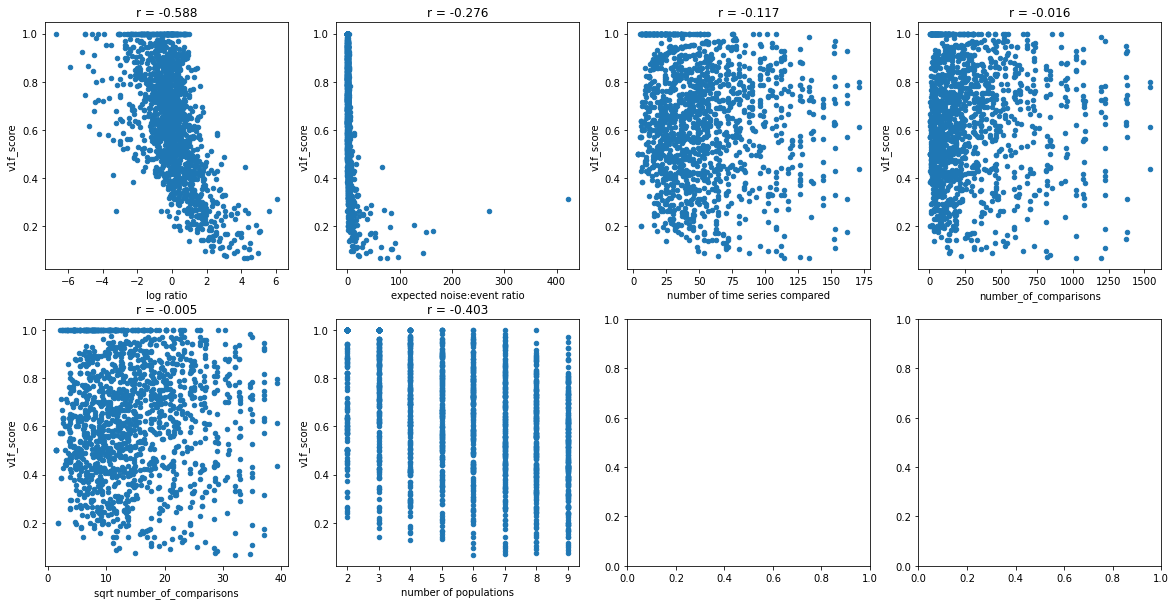

Scattergraphs for associations between parameters and version 2.000 sigma results


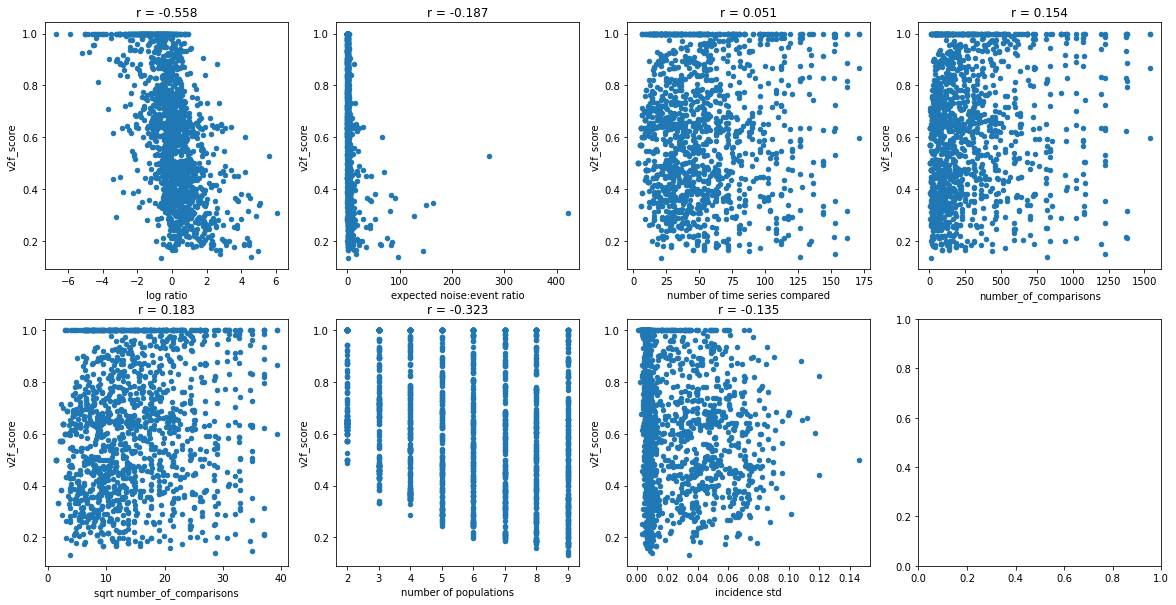

,v1f_score,v2f_score
log ratio,-0.59,-0.56
number of populations,-0.40,-0.32
expected noise:event ratio,-0.28,-0.19
incidence std,-0.13,-0.13
number of time series compared,-0.12,0.05
max lag,-0.10,-0.05
number_of_comparisons,-0.02,0.15
sqrt number_of_comparisons,-0.01,0.18
incidence mean,0.02,-0.18
individuals across populations similar,0.05,0.04


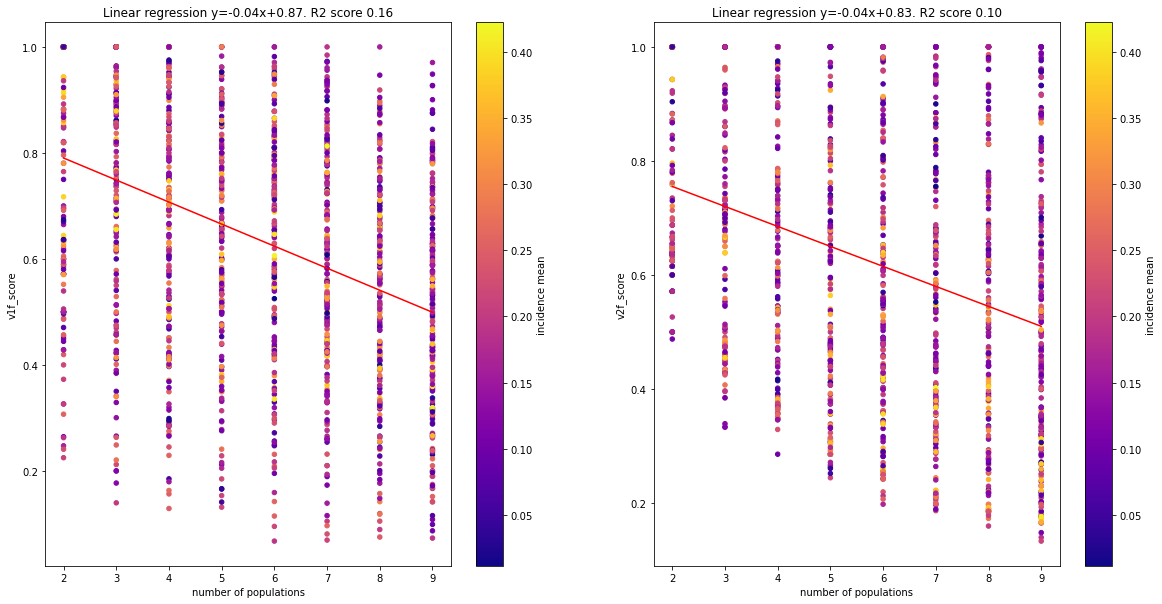

In [10]:
import sensitivity_analysis_functions as saf
import pandas as pd
#print(pd.__version__)
MI_analysis = True
linear_reg = True
regression_on_cols = ['v1f_score','v2f_score']
target_results_cols = ['v1f_score','v2f_score']
regression_feature = 'log ratio'
regression_feature = 'number of populations'

df_results = pd.DataFrame()
for version in ['1','2','3','4']:
    Louvain_version = version
    df_correlations=pd.read_csv("..\Results\multiple_pop_correlations_index.csv",index_col = 0)
    df_Louvain = pd.read_csv("..\Results\Louvain_{0}_results.csv".format(Louvain_version),index_col = 0)
    #display(df_correlations.head(5))
    #display(df_Louvain.head(5))
    df = pd.concat([df_correlations,df_Louvain], axis = 1)
    #print(df.columns)
    # show overall results 
    meanv1_fscore = df['v1f_score'].mean()
    meanv2_fscore = df['v2f_score'].mean()
    df_similar = df.loc[df['individuals within populations similar'] == True]
    df_dissimilar = df.loc[df['individuals within populations similar'] == False]
    meanv1_sim = df_similar['v1f_score'].mean()
    meanv2_sim = df_similar['v2f_score'].mean()
    control_mean = df_dissimilar['v2f_score'].mean()
    df_results['Louvain {0}'.format(Louvain_version)] = [meanv1_fscore,meanv2_fscore,meanv1_sim,meanv2_sim, control_mean]
    print("Overall results for Louvain version {0}".format(Louvain_version))
    print("Mean f-score for Louvain community detection for v1/v2 sigma across all results is {0}/{1}".format(meanv1_fscore,meanv2_fscore))
    print("Mean f-score when only counting populations of similar individuals is {0}/{1}".format(meanv1_sim,meanv2_sim))
df_results.index = ['sigma1 all runs', 'sigma2 all runs', 'sigma1 similar individuals', 'sigma2 similar individuals',' control f score']
display(df_results)

if MI_analysis:
    # for explanations of parameters/results headings set verbose to True
    # for MI comparisons against all versions of the results, set all_results to True
    # to display more/fewer MI values, reduce/increase cutoff
    # to display scattergraphs of all associations above cutoff value, set display_scattergraphs to True
    saf.mutual_information_analysis(df,verbose=False,all_results=False,target_results_cols = target_results_cols,cutoff=0.1,display_scattergraphs=True)
    
if linear_reg:
    # linear regression will be on the feature passed as 'regression_feature' (useful to see scattergraphs even if regression line not meaningful in most cases)
    # if only_similar_individuals is True, half the runs will be discarded (those which cannot be meaningfully analysed using v2 sigma)
    # if only_similar_individuals is False, all runs will be included (so half of the v2 sigma results will be noise).
    # color_map_col can be changed to any feature parameter and will color the scatterplot by this parameter.
    saf.linear_regression_analysis(df,regression_feature = regression_feature, regression_on_cols = regression_on_cols, only_similar_individuals = True,
                               color_map_col = 'incidence mean')




Cell below reads in the index file for Louvain results and continues to run Louvain on the corresponding correlation raw data from the last index.  An index can be passed in if it is required to repeat from a certain point.

In [4]:
import pointwise_correlation as pc
import testing_and_analysis_functions as taf
import pandas as pd
import Louvain
import numpy as np
import os

Louvain_version = '4'
Louvain_index_file = "{0}/Louvain_{1}_results.csv".format(pc.RESULTS_DIR,Louvain_version)
next_index = None
start_again = False
store_results = False

# turn index of correlation results into dataframe
i = np.random.randint(2999)

index_df=pd.read_csv("{0}".format(pc.INDEX_FILE),index_col = 0)
# load completed results csv into dataframe if it already exists
try:
    Louvain_results = pd.read_csv(Louvain_index_file, index_col = 0)
    # set next_index to the index to start running from
    if next_index:
        Louvain_results = Louvain_results.head(next_index)    
    else:
        next_index = Louvain_results.index[-1] + 1    
except FileNotFoundError:
    Louvain_results = pd.DataFrame()
    next_index = 0

if start_again:
    Louvain_results = pd.DataFrame()
    next_index = 0
    

# iterate through the stored index file, load the corresponding raw data and carry out Louvain community detection
# the partition and the scores are written to csv files in a sub-directory of the raw data directory
for index in index_df.index[next_index:]:
    data_dir = index_df.loc[index,'raw data directory']
    number_of_populations = index_df.loc[index,'number of populations']
    results_path = os.path.join(data_dir,"Louvain_{0}".format(Louvain_version))
    try:
        os.mkdir(results_path)
    except FileExistsError:
        pass
    
    if not store_results:
        results_path = ""
        
    v1_df, v2_df = taf.load_results_to_dfs(data_dir)
    meta_params = pd.read_csv("{0}/meta_params.csv".format(data_dir))
    params = pd.read_csv("{0}/population_parameters.csv".format(data_dir))
    
    results = {}
    for i, df in enumerate([v1_df, v2_df]):
        sigma_version = "v" + str(i+1)
        L_methods = Louvain.Louvain_methods(df,p_values_graph_setup_option = 'weights',resolution = 1,
                                                    store_results_dir = results_path, version = sigma_version, 
                                                    Louvain_version = Louvain_version, verbose=False)
    
        results[sigma_version] = L_methods.score_partition()#n.make_partition_and_score(df,test_random_graph=False,pass_weights=True,resolution = 1,
                                                    #store_results_dir = results_path, version = sigma_version, Louvain_version = Louvain_version, verbose=False)
    
    # append v2 results to v1 results in dict
    results['v1'].update(results['v2'])

    new_row = pd.DataFrame.from_dict(results['v1'])
    new_row['Louvain results path'] = results_path
    new_row['n'] = number_of_populations
    new_row.index = [index]
    if len(Louvain_results.index):
        Louvain_results = pd.concat([Louvain_results, new_row])
    else:
        Louvain_results = new_row
    
    if index == index_df.index[-1] or not index%30:
        # store accumulated results in csv file
        if store_results:
            Louvain_results.to_csv(Louvain_index_file)
            
        print("{0}%".format(int(index/30), end = ","))
        display(Louvain_results.tail(5))
        
        print("Testing by reloading stored results....")
        print("Scores for v1...")
        display(pd.read_csv("{0}/Louvain_{1}/v1recall_precision_fscores.csv".format(data_dir, Louvain_version)))
        print("...and v2")
        display(pd.read_csv("{0}/Louvain_{1}/v2recall_precision_fscores.csv".format(data_dir, Louvain_version)))
        print("Confusion matrices for v1...")
        display(pd.read_csv("{0}/Louvain_{1}/v1confusion_matrix.csv".format(data_dir, Louvain_version)))
        print("...and v2")
        display(pd.read_csv("{0}/Louvain_{1}/v2confusion_matrix.csv".format(data_dir, Louvain_version)))
        
           
    
    
    
    

0%


,v1clusters,v1recall,v1precision,v1f_score,v2clusters,v2recall,v2precision,v2f_score,Louvain results path,n
0,2,0.545,1.0,0.706,3,0.333,0.367,0.349,C:/Users/owen/Machine learning projects/Luc_tw...,3


Testing by reloading stored results....
Scores for v1...


,Unnamed: 0,Elena,Owen,Rosa,Overall
0,Recall,1.0,0.286,0.286,0.545
1,Precison,1.0,1.000,1.000,1.000
2,F-score,1.0,0.444,0.444,0.706


...and v2


,Unnamed: 0,Elena,Owen,Rosa,Overall
0,Recall,0.105,0.20,0.286,0.333
1,Precison,0.200,0.30,0.600,0.367
2,F-score,0.138,0.24,0.387,0.349


Confusion matrices for v1...


,Unnamed: 0,Rosa,Owen,Elena
0,cluster 0,5.0,5.0,NaN
1,cluster 1,NaN,NaN,5.0


...and v2


,Unnamed: 0,Rosa,Owen,Elena
0,cluster 0,4.0,1,2
1,cluster 2,1.0,1,2
2,cluster 1,NaN,3,1


1%


,v1clusters,v1recall,v1precision,v1f_score,v2clusters,v2recall,v2precision,v2f_score,Louvain results path,n
26,8,0.428,0.482,0.453,7,0.508,0.617,0.557,C:/Users/owen/Machine learning projects/Luc_tw...,9
27,4,0.978,0.943,0.960,4,0.364,0.482,0.415,C:/Users/owen/Machine learning projects/Luc_tw...,4
28,6,0.701,0.551,0.617,4,0.246,0.255,0.250,C:/Users/owen/Machine learning projects/Luc_tw...,4
29,4,0.556,0.744,0.637,3,0.204,0.389,0.268,C:/Users/owen/Machine learning projects/Luc_tw...,5
30,8,0.208,0.218,0.213,5,0.195,0.345,0.250,C:/Users/owen/Machine learning projects/Luc_tw...,8


Testing by reloading stored results....
Scores for v1...


,Unnamed: 0,0,1,2,3,4,5,6,7,Overall
0,Recall,0.028,0.0,0.061,0.061,0.081,0.190,0.116,0.325,0.208
1,Precison,0.067,0.0,0.200,0.143,0.139,0.524,0.145,0.361,0.218
2,F-score,0.039,0.0,0.093,0.086,0.102,0.278,0.129,0.342,0.213


...and v2


,Unnamed: 0,0,1,2,3,4,5,6,7,Overall
0,Recall,0.062,0.042,0.053,0.097,0.081,0.099,0.095,0.362,0.195
1,Precison,0.267,0.333,0.400,0.476,0.194,0.429,0.218,0.583,0.345
2,F-score,0.100,0.074,0.094,0.161,0.115,0.161,0.133,0.447,0.250


Confusion matrices for v1...


,Unnamed: 0,4,0,3,1,5,6,2,7
0,cluster 0,2.0,1.0,1.0,1.0,5.0,2.0,NaN,NaN
1,cluster 1,3.0,NaN,1.0,NaN,2.0,NaN,2.0,NaN
2,cluster 2,1.0,1.0,3.0,NaN,NaN,3.0,2.0,NaN
3,cluster 4,2.0,2.0,1.0,NaN,NaN,NaN,NaN,NaN
4,cluster 5,1.0,NaN,NaN,1.0,NaN,3.0,NaN,3.0
5,cluster 3,NaN,1.0,1.0,NaN,NaN,1.0,1.0,NaN
6,cluster 6,NaN,1.0,NaN,1.0,NaN,NaN,NaN,5.0
7,cluster 7,NaN,NaN,NaN,NaN,NaN,2.0,NaN,1.0


...and v2


,Unnamed: 0,5,2,6,0,3,7,4,1
0,cluster 0,4.0,3.0,4.0,2.0,5.0,1.0,1,NaN
1,cluster 1,3.0,NaN,1.0,3.0,NaN,NaN,2,NaN
2,cluster 3,NaN,2.0,3.0,NaN,1.0,1.0,4,1.0
3,cluster 2,NaN,NaN,3.0,1.0,1.0,NaN,1,2.0
4,cluster 4,NaN,NaN,NaN,NaN,NaN,7.0,1,NaN


2%


,v1clusters,v1recall,v1precision,v1f_score,v2clusters,v2recall,v2precision,v2f_score,Louvain results path,n
56,5,0.290,0.600,0.391,2,0.111,0.883,0.198,C:/Users/owen/Machine learning projects/Luc_tw...,8
57,4,0.749,0.982,0.849,5,0.944,0.927,0.935,C:/Users/owen/Machine learning projects/Luc_tw...,5
58,2,1.000,1.000,1.000,1,0.455,1.000,0.625,C:/Users/owen/Machine learning projects/Luc_tw...,2
59,5,0.378,0.643,0.476,1,0.118,1.000,0.211,C:/Users/owen/Machine learning projects/Luc_tw...,7
60,8,0.487,0.554,0.518,4,0.103,0.238,0.144,C:/Users/owen/Machine learning projects/Luc_tw...,8


Testing by reloading stored results....
Scores for v1...


,Unnamed: 0,0,1,2,3,4,5,6,7,Overall
0,Recall,0.241,0.455,0.125,0.304,0.429,0.140,0.345,0.60,0.487
1,Precison,0.333,0.714,0.286,0.333,1.000,0.286,0.476,1.00,0.554
2,F-score,0.280,0.556,0.174,0.318,0.600,0.188,0.400,0.75,0.518


...and v2


,Unnamed: 0,0,1,2,3,4,5,6,7,Overall
0,Recall,0.045,0.033,0.069,0.049,0.034,0.064,0.058,0.079,0.103
1,Precison,0.190,0.143,0.333,0.190,0.143,0.286,0.286,0.333,0.238
2,F-score,0.073,0.054,0.115,0.078,0.055,0.104,0.097,0.127,0.144


Confusion matrices for v1...


,Unnamed: 0,7,0,5,3,2,1,6,4
0,cluster 0,7.0,1.0,1.0,NaN,NaN,NaN,NaN,NaN
1,cluster 6,NaN,2.0,NaN,NaN,NaN,NaN,1.0,NaN
2,cluster 7,NaN,4.0,NaN,NaN,3.0,NaN,NaN,NaN
3,cluster 1,NaN,NaN,4.0,2.0,1.0,NaN,NaN,NaN
4,cluster 3,NaN,NaN,1.0,NaN,NaN,6.0,1.0,NaN
5,cluster 5,NaN,NaN,1.0,NaN,3.0,NaN,NaN,7.0
6,cluster 2,NaN,NaN,NaN,4.0,NaN,NaN,NaN,NaN
7,cluster 4,NaN,NaN,NaN,1.0,NaN,1.0,5.0,NaN


...and v2


,Unnamed: 0,4,7,5,6,2,0,1,3
0,cluster 0,2,2.0,3.0,4,4.0,2,2,1
1,cluster 1,2,NaN,3.0,1,NaN,3,2,1
2,cluster 2,1,4.0,NaN,1,1.0,1,2,3
3,cluster 3,2,1.0,1.0,1,2.0,1,1,2


3%


,v1clusters,v1recall,v1precision,v1f_score,v2clusters,v2recall,v2precision,v2f_score,Louvain results path,n
86,5,0.586,0.804,0.678,3,0.418,0.993,0.588,C:/Users/owen/Machine learning projects/Luc_tw...,8
87,7,0.439,0.644,0.523,4,0.313,0.844,0.457,C:/Users/owen/Machine learning projects/Luc_tw...,9
88,2,0.923,0.929,0.926,4,0.525,0.286,0.370,C:/Users/owen/Machine learning projects/Luc_tw...,2
89,13,0.424,0.235,0.302,5,0.137,0.237,0.174,C:/Users/owen/Machine learning projects/Luc_tw...,7
90,2,1.000,1.000,1.000,2,1.000,1.000,1.000,C:/Users/owen/Machine learning projects/Luc_tw...,2


Testing by reloading stored results....
Scores for v1...


,Unnamed: 0,Owen,Flo,Overall
0,Recall,1.0,1.0,1.0
1,Precison,1.0,1.0,1.0
2,F-score,1.0,1.0,1.0


...and v2


,Unnamed: 0,Owen,Flo,Overall
0,Recall,1.0,1.0,1.0
1,Precison,1.0,1.0,1.0
2,F-score,1.0,1.0,1.0


Confusion matrices for v1...


,Unnamed: 0,Flo,Owen
0,cluster 0,15.0,NaN
1,cluster 1,NaN,15.0


...and v2


,Unnamed: 0,Flo,Owen
0,cluster 0,15.0,NaN
1,cluster 1,NaN,15.0


4%


,v1clusters,v1recall,v1precision,v1f_score,v2clusters,v2recall,v2precision,v2f_score,Louvain results path,n
116,2,0.570,0.934,0.708,3,1.000,1.000,1.000,C:/Users/owen/Machine learning projects/Luc_tw...,3
117,7,0.537,0.619,0.575,4,0.128,0.281,0.176,C:/Users/owen/Machine learning projects/Luc_tw...,9
118,5,0.680,0.738,0.708,5,0.188,0.217,0.201,C:/Users/owen/Machine learning projects/Luc_tw...,5
119,5,0.558,0.694,0.619,4,0.332,0.500,0.399,C:/Users/owen/Machine learning projects/Luc_tw...,6
120,8,0.624,0.662,0.642,5,0.108,0.229,0.147,C:/Users/owen/Machine learning projects/Luc_tw...,8


Testing by reloading stored results....
Scores for v1...


,Unnamed: 0,0,1,2,3,4,5,6,7,Overall
0,Recall,0.148,0.667,0.351,0.579,0.733,0.437,0.550,0.279,0.624
1,Precison,0.218,0.846,0.590,0.846,0.846,0.846,0.705,0.397,0.662
2,F-score,0.176,0.746,0.440,0.688,0.786,0.576,0.618,0.328,0.642


...and v2


,Unnamed: 0,0,1,2,3,4,5,6,7,Overall
0,Recall,0.053,0.061,0.059,0.065,0.048,0.055,0.059,0.051,0.108
1,Precison,0.218,0.269,0.244,0.282,0.141,0.218,0.256,0.205,0.229
2,F-score,0.086,0.100,0.095,0.106,0.071,0.088,0.096,0.082,0.147


Confusion matrices for v1...


,Unnamed: 0,7,1,0,4,3,6,5,2
0,cluster 0,8.0,1.0,1.0,NaN,NaN,NaN,NaN,NaN
1,cluster 4,1.0,NaN,2.0,NaN,NaN,1.0,12.0,2.0
2,cluster 5,1.0,NaN,2.0,NaN,12.0,NaN,NaN,NaN
3,cluster 7,3.0,NaN,1.0,NaN,NaN,NaN,NaN,10.0
4,cluster 6,NaN,12.0,NaN,NaN,NaN,NaN,1.0,1.0
5,cluster 2,NaN,NaN,6.0,NaN,NaN,1.0,NaN,NaN
6,cluster 3,NaN,NaN,1.0,1.0,NaN,11.0,NaN,NaN
7,cluster 1,NaN,NaN,NaN,12.0,1.0,NaN,NaN,NaN


...and v2


,Unnamed: 0,7,6,4,3,2,5,1,0
0,cluster 0,4.0,6.0,2,6.0,5.0,5,6.0,5
1,cluster 1,3.0,3.0,2,1.0,4.0,1,3.0,1
2,cluster 3,2.0,2.0,3,4.0,1.0,4,1.0,2
3,cluster 4,4.0,2.0,3,2.0,3.0,2,3.0,4
4,cluster 2,NaN,NaN,3,NaN,NaN,1,NaN,1


5%


,v1clusters,v1recall,v1precision,v1f_score,v2clusters,v2recall,v2precision,v2f_score,Louvain results path,n
146,3,0.512,0.840,0.636,2,0.246,0.640,0.356,C:/Users/owen/Machine learning projects/Luc_tw...,4
147,6,0.674,0.619,0.645,3,0.604,0.908,0.726,C:/Users/owen/Machine learning projects/Luc_tw...,5
148,4,0.781,0.835,0.807,3,0.652,0.915,0.762,C:/Users/owen/Machine learning projects/Luc_tw...,4
149,7,0.828,0.840,0.834,4,0.141,0.262,0.183,C:/Users/owen/Machine learning projects/Luc_tw...,7
150,6,0.522,0.669,0.586,5,0.143,0.258,0.184,C:/Users/owen/Machine learning projects/Luc_tw...,8


Testing by reloading stored results....
Scores for v1...


,Unnamed: 0,0,1,2,3,4,5,6,7,Overall
0,Recall,0.333,0.0,0.536,0.583,0.440,0.032,0.455,0.273,0.522
1,Precison,1.000,0.0,0.714,0.778,0.524,0.333,1.000,0.400,0.669
2,F-score,0.500,0.0,0.612,0.667,0.478,0.059,0.625,0.324,0.586


...and v2


,Unnamed: 0,0,1,2,3,4,5,6,7,Overall
0,Recall,0.067,0.0,0.093,0.180,0.065,0.030,0.067,0.062,0.143
1,Precison,0.286,0.0,0.429,0.306,0.238,0.333,0.267,0.133,0.258
2,F-score,0.108,0.0,0.153,0.227,0.102,0.056,0.107,0.085,0.184


Confusion matrices for v1...


,Unnamed: 0,3,1,0,7,5,6,4,2
0,cluster 0,8.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN
1,cluster 1,1.0,NaN,7.0,3.0,2.0,NaN,NaN,NaN
2,cluster 4,NaN,1.0,NaN,6.0,NaN,NaN,NaN,1.0
3,cluster 5,NaN,NaN,NaN,1.0,NaN,NaN,NaN,6.0
4,cluster 2,NaN,NaN,NaN,NaN,1.0,6.0,2.0,NaN
5,cluster 3,NaN,NaN,NaN,NaN,NaN,NaN,5.0,NaN


...and v2


,Unnamed: 0,3,0,2,1,4,7,6,5
0,cluster 0,2.0,3.0,4.0,1.0,2.0,3,2.0,NaN
1,cluster 1,5.0,NaN,NaN,NaN,NaN,2,NaN,NaN
2,cluster 2,1.0,NaN,NaN,NaN,2.0,2,NaN,NaN
3,cluster 3,1.0,1.0,NaN,NaN,NaN,1,3.0,1.0
4,cluster 4,NaN,3.0,3.0,1.0,3.0,2,1.0,2.0


6%


,v1clusters,v1recall,v1precision,v1f_score,v2clusters,v2recall,v2precision,v2f_score,Louvain results path,n
176,3,0.189,0.667,0.294,2,0.151,0.933,0.259,C:/Users/owen/Machine learning projects/Luc_tw...,8
177,2,1.000,1.000,1.000,2,0.417,0.500,0.455,C:/Users/owen/Machine learning projects/Luc_tw...,2
178,3,0.583,0.894,0.706,3,0.236,0.362,0.286,C:/Users/owen/Machine learning projects/Luc_tw...,5
179,8,0.321,0.209,0.253,6,0.166,0.145,0.155,C:/Users/owen/Machine learning projects/Luc_tw...,5
180,8,0.876,0.895,0.885,8,0.275,0.536,0.364,C:/Users/owen/Machine learning projects/Luc_tw...,8


Testing by reloading stored results....
Scores for v1...


,Unnamed: 0,0,1,2,3,4,5,6,7,Overall
0,Recall,1.0,0.643,0.869,0.890,0.714,0.900,0.818,0.500,0.876
1,Precison,1.0,1.000,0.895,0.895,0.801,1.000,1.000,0.567,0.895
2,F-score,1.0,0.783,0.882,0.892,0.755,0.947,0.900,0.532,0.885


...and v2


,Unnamed: 0,0,1,2,3,4,5,6,7,Overall
0,Recall,0.090,0.398,0.113,0.140,0.411,0.427,0.117,0.097,0.275
1,Precison,0.304,0.409,0.567,0.795,0.620,0.632,0.632,0.327,0.536
2,F-score,0.139,0.403,0.189,0.238,0.494,0.509,0.198,0.150,0.364


Confusion matrices for v1...


,Unnamed: 0,5,3,6,4,2,7,1,0
0,cluster 0,19.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN
1,cluster 1,NaN,18.0,NaN,NaN,NaN,NaN,NaN,NaN
2,cluster 2,NaN,NaN,19.0,2.0,NaN,NaN,NaN,NaN
3,cluster 5,NaN,NaN,NaN,17.0,NaN,1.0,NaN,NaN
4,cluster 3,NaN,NaN,NaN,NaN,18.0,NaN,NaN,NaN
5,cluster 6,NaN,NaN,NaN,NaN,1.0,4.0,19.0,NaN
6,cluster 4,NaN,NaN,NaN,NaN,NaN,14.0,NaN,NaN
7,cluster 7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,19.0


...and v2


,Unnamed: 0,6,3,0,7,2,5,4,1
0,cluster 0,15.0,17.0,8.0,8.0,14.0,1.0,1.0,1.0
1,cluster 6,1.0,1.0,NaN,NaN,NaN,15.0,1.0,NaN
2,cluster 7,3.0,NaN,NaN,NaN,NaN,NaN,15.0,NaN
3,cluster 5,NaN,1.0,3.0,NaN,NaN,NaN,NaN,NaN
4,cluster 1,NaN,NaN,7.0,1.0,1.0,3.0,2.0,1.0
5,cluster 4,NaN,NaN,1.0,1.0,NaN,NaN,NaN,11.0
6,cluster 2,NaN,NaN,NaN,1.0,NaN,NaN,NaN,6.0
7,cluster 3,NaN,NaN,NaN,8.0,4.0,NaN,NaN,NaN


7%


,v1clusters,v1recall,v1precision,v1f_score,v2clusters,v2recall,v2precision,v2f_score,Louvain results path,n
206,8,0.413,0.386,0.399,5,0.158,0.248,0.193,C:/Users/owen/Machine learning projects/Luc_tw...,9
207,11,0.140,0.098,0.116,3,0.136,0.365,0.198,C:/Users/owen/Machine learning projects/Luc_tw...,7
208,5,0.485,0.943,0.641,4,0.103,0.200,0.136,C:/Users/owen/Machine learning projects/Luc_tw...,7
209,2,0.806,0.833,0.820,1,0.455,1.000,0.625,C:/Users/owen/Machine learning projects/Luc_tw...,2
210,5,0.641,0.900,0.749,5,0.467,0.617,0.532,C:/Users/owen/Machine learning projects/Luc_tw...,9


Testing by reloading stored results....
Scores for v1...


,Unnamed: 0,0,1,2,3,4,5,6,7,8,Overall
0,Recall,0.734,0.733,0.053,0.034,0.040,0.538,0.250,0.111,0.25,0.641
1,Precison,0.867,1.000,1.000,1.000,1.000,1.000,0.500,1.000,1.00,0.900
2,F-score,0.795,0.846,0.100,0.067,0.077,0.700,0.333,0.200,0.40,0.749


...and v2


,Unnamed: 0,0,1,2,3,4,5,6,7,8,Overall
0,Recall,0.875,0.245,0.091,0.0,0.0,0.330,0.138,0.0,0.031,0.467
1,Precison,1.000,0.591,1.000,0.0,0.0,0.324,0.444,0.0,0.333,0.617
2,F-score,0.933,0.347,0.167,0.0,0.0,0.327,0.211,0.0,0.057,0.532


Confusion matrices for v1...


,Unnamed: 0,2,6,5,4,1,0,8,7,3
0,cluster 0,3.0,3.0,15.0,NaN,NaN,NaN,NaN,NaN,NaN
1,cluster 2,NaN,6.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,cluster 1,NaN,NaN,NaN,2.0,12.0,NaN,NaN,NaN,NaN
3,cluster 3,NaN,NaN,NaN,NaN,NaN,1.0,3.0,2.0,NaN
4,cluster 4,NaN,NaN,NaN,NaN,NaN,14.0,NaN,NaN,2.0


...and v2


,Unnamed: 0,5,8,4,7,6,1,3,2,0
0,cluster 0,5.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,cluster 1,7.0,1.0,1.0,1.0,NaN,NaN,NaN,NaN,NaN
2,cluster 2,3.0,NaN,1.0,1.0,4.0,9.0,1.0,NaN,NaN
3,cluster 3,NaN,2.0,NaN,NaN,5.0,3.0,NaN,3.0,NaN
4,cluster 4,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,15.0


8%


,v1clusters,v1recall,v1precision,v1f_score,v2clusters,v2recall,v2precision,v2f_score,Louvain results path,n
236,5,0.970,0.833,0.897,4,0.269,0.346,0.303,C:/Users/owen/Machine learning projects/Luc_tw...,4
237,5,0.579,0.830,0.682,5,0.579,0.830,0.682,C:/Users/owen/Machine learning projects/Luc_tw...,7
238,9,0.195,0.160,0.176,4,0.153,0.350,0.213,C:/Users/owen/Machine learning projects/Luc_tw...,9
239,4,0.642,0.565,0.601,3,0.287,0.330,0.307,C:/Users/owen/Machine learning projects/Luc_tw...,4
240,3,0.531,1.000,0.694,4,1.000,1.000,1.000,C:/Users/owen/Machine learning projects/Luc_tw...,4


Testing by reloading stored results....
Scores for v1...


,Unnamed: 0,Owen,Rosa,Tom,Elena,Overall
0,Recall,1.0,0.167,0.400,1.0,0.531
1,Precison,1.0,1.000,1.000,1.0,1.000
2,F-score,1.0,0.286,0.571,1.0,0.694


...and v2


,Unnamed: 0,Owen,Rosa,Tom,Elena,Overall
0,Recall,1.0,1.0,1.0,1.0,1.0
1,Precison,1.0,1.0,1.0,1.0,1.0
2,F-score,1.0,1.0,1.0,1.0,1.0


Confusion matrices for v1...


,Unnamed: 0,Elena,Tom,Rosa,Owen
0,cluster 0,2.0,NaN,NaN,NaN
1,cluster 1,NaN,5.0,3.0,NaN
2,cluster 2,NaN,NaN,NaN,3.0


...and v2


,Unnamed: 0,Elena,Tom,Rosa,Owen
0,cluster 0,2.0,NaN,NaN,NaN
1,cluster 1,NaN,5.0,NaN,NaN
2,cluster 2,NaN,NaN,3.0,NaN
3,cluster 3,NaN,NaN,NaN,3.0


9%


,v1clusters,v1recall,v1precision,v1f_score,v2clusters,v2recall,v2precision,v2f_score,Louvain results path,n
266,7,0.496,0.633,0.556,5,0.272,0.522,0.357,C:/Users/owen/Machine learning projects/Luc_tw...,9
267,6,0.625,0.703,0.662,3,0.383,0.766,0.510,C:/Users/owen/Machine learning projects/Luc_tw...,6
268,4,0.520,0.737,0.610,3,0.470,1.000,0.640,C:/Users/owen/Machine learning projects/Luc_tw...,7
269,7,0.737,0.853,0.791,7,0.879,0.959,0.917,C:/Users/owen/Machine learning projects/Luc_tw...,8
270,5,0.607,0.910,0.728,6,0.972,0.974,0.973,C:/Users/owen/Machine learning projects/Luc_tw...,6


Testing by reloading stored results....
Scores for v1...


,Unnamed: 0,Jill,Owen,Luke,Rosa,Tom,Flo,Overall
0,Recall,0.695,0.261,1.0,1.0,0.261,0.372,0.607
1,Precison,0.846,1.000,1.0,1.0,1.000,0.615,0.910
2,F-score,0.763,0.414,1.0,1.0,0.414,0.464,0.728


...and v2


,Unnamed: 0,Jill,Owen,Luke,Rosa,Tom,Flo,Overall
0,Recall,0.835,1.0,1.0,1.0,0.857,1.0,0.972
1,Precison,0.846,1.0,1.0,1.0,1.000,1.0,0.974
2,F-score,0.841,1.0,1.0,1.0,0.923,1.0,0.973


Confusion matrices for v1...


,Unnamed: 0,Rosa,Flo,Owen,Tom,Jill,Luke
0,cluster 0,13.0,NaN,NaN,NaN,NaN,NaN
1,cluster 1,NaN,3.0,13.0,13.0,1.0,NaN
2,cluster 2,NaN,10.0,NaN,NaN,NaN,NaN
3,cluster 4,NaN,NaN,NaN,NaN,12.0,NaN
4,cluster 3,NaN,NaN,NaN,NaN,NaN,13.0


...and v2


,Unnamed: 0,Rosa,Flo,Jill,Luke,Owen,Tom
0,cluster 0,13.0,NaN,NaN,NaN,NaN,NaN
1,cluster 1,NaN,13.0,NaN,NaN,NaN,NaN
2,cluster 2,NaN,NaN,12.0,NaN,NaN,NaN
3,cluster 5,NaN,NaN,1.0,NaN,NaN,13.0
4,cluster 3,NaN,NaN,NaN,13.0,NaN,NaN
5,cluster 4,NaN,NaN,NaN,NaN,13.0,NaN


10%


,v1clusters,v1recall,v1precision,v1f_score,v2clusters,v2recall,v2precision,v2f_score,Louvain results path,n
296,7,0.876,0.898,0.887,4,0.136,0.267,0.180,C:/Users/owen/Machine learning projects/Luc_tw...,7
297,3,0.462,0.429,0.444,3,0.417,0.357,0.385,C:/Users/owen/Machine learning projects/Luc_tw...,3
298,6,0.460,0.770,0.576,3,0.228,0.885,0.362,C:/Users/owen/Machine learning projects/Luc_tw...,9
299,4,0.805,1.000,0.892,4,0.750,0.909,0.822,C:/Users/owen/Machine learning projects/Luc_tw...,5
300,2,0.846,0.688,0.759,2,0.538,0.438,0.483,C:/Users/owen/Machine learning projects/Luc_tw...,2


Testing by reloading stored results....
Scores for v1...


,Unnamed: 0,Rosa,Jill,Overall
0,Recall,0.333,0.833,0.846
1,Precison,1.000,0.667,0.688
2,F-score,0.500,0.741,0.759


...and v2


,Unnamed: 0,Rosa,Jill,Overall
0,Recall,0.143,0.500,0.538
1,Precison,1.000,0.400,0.438
2,F-score,0.250,0.444,0.483


Confusion matrices for v1...


,Unnamed: 0,Rosa,Jill
0,cluster 0,2.0,1
1,cluster 1,NaN,5


...and v2


,Unnamed: 0,Jill,Rosa
0,cluster 0,3,2.0
1,cluster 1,3,NaN


11%


,v1clusters,v1recall,v1precision,v1f_score,v2clusters,v2recall,v2precision,v2f_score,Louvain results path,n
326,3,0.870,0.556,0.678,3,0.481,0.347,0.403,C:/Users/owen/Machine learning projects/Luc_tw...,2
327,3,0.373,0.609,0.463,3,0.422,0.587,0.491,C:/Users/owen/Machine learning projects/Luc_tw...,4
328,3,0.723,0.477,0.575,3,0.488,0.330,0.394,C:/Users/owen/Machine learning projects/Luc_tw...,2
329,7,0.427,0.298,0.351,2,0.222,0.596,0.323,C:/Users/owen/Machine learning projects/Luc_tw...,5
330,5,0.577,0.865,0.692,5,0.579,0.810,0.675,C:/Users/owen/Machine learning projects/Luc_tw...,7


Testing by reloading stored results....
Scores for v1...


,Unnamed: 0,0,1,2,3,4,5,6,Overall
0,Recall,0.209,0.556,0.444,0.784,0.0,0.093,0.400,0.577
1,Precison,1.000,1.000,1.000,0.758,0.0,0.190,1.000,0.865
2,F-score,0.346,0.714,0.615,0.771,0.0,0.125,0.571,0.692


...and v2


,Unnamed: 0,0,1,2,3,4,5,6,Overall
0,Recall,0.167,0.294,0.960,0.418,0.022,0.122,1.0,0.579
1,Precison,0.444,1.000,0.882,0.875,1.000,0.524,1.0,0.810
2,F-score,0.242,0.455,0.920,0.566,0.043,0.198,1.0,0.675


Confusion matrices for v1...


,Unnamed: 0,5,6,3,1,4,2,0
0,cluster 0,2.0,5.0,1.0,NaN,NaN,NaN,NaN
1,cluster 1,1.0,NaN,NaN,6.0,1.0,NaN,NaN
2,cluster 3,3.0,NaN,1.0,NaN,1.0,NaN,NaN
3,cluster 4,1.0,NaN,14.0,NaN,NaN,NaN,NaN
4,cluster 2,NaN,NaN,NaN,NaN,NaN,17.0,10.0


...and v2


,Unnamed: 0,3,5,0,4,1,6,2
0,cluster 0,15.0,2.0,5.0,2.0,NaN,NaN,NaN
1,cluster 1,1.0,5.0,NaN,NaN,6.0,NaN,NaN
2,cluster 4,NaN,NaN,5.0,NaN,NaN,NaN,1.0
3,cluster 2,NaN,NaN,NaN,NaN,NaN,5.0,NaN
4,cluster 3,NaN,NaN,NaN,NaN,NaN,NaN,16.0


12%


,v1clusters,v1recall,v1precision,v1f_score,v2clusters,v2recall,v2precision,v2f_score,Louvain results path,n
356,2,0.945,0.947,0.946,3,0.468,0.383,0.421,C:/Users/owen/Machine learning projects/Luc_tw...,2
357,4,0.835,0.865,0.850,4,0.267,0.273,0.270,C:/Users/owen/Machine learning projects/Luc_tw...,4
358,7,0.518,0.782,0.623,4,0.155,0.397,0.223,C:/Users/owen/Machine learning projects/Luc_tw...,9
359,2,0.556,1.000,0.714,1,0.278,1.000,0.435,C:/Users/owen/Machine learning projects/Luc_tw...,3
360,3,0.513,0.851,0.640,2,0.326,0.979,0.489,C:/Users/owen/Machine learning projects/Luc_tw...,5


Testing by reloading stored results....
Scores for v1...


,Unnamed: 0,Owen,Rosa,Tom,Elena,Flo,Overall
0,Recall,0.455,0.714,0.333,0.0,0.133,0.513
1,Precison,1.000,1.000,1.000,0.0,0.400,0.851
2,F-score,0.625,0.833,0.500,0.0,0.200,0.640


...and v2


,Unnamed: 0,Owen,Rosa,Tom,Elena,Flo,Overall
0,Recall,0.200,0.714,0.111,0.0,0.154,0.326
1,Precison,1.000,1.000,1.000,0.0,1.000,0.979
2,F-score,0.333,0.833,0.200,0.0,0.267,0.489


Confusion matrices for v1...


,Unnamed: 0,Owen,Flo,Elena,Tom,Rosa
0,cluster 0,6.0,2.0,1.0,NaN,NaN
1,cluster 1,NaN,3.0,NaN,4.0,NaN
2,cluster 2,NaN,NaN,1.0,NaN,6.0


...and v2


,Unnamed: 0,Flo,Owen,Tom,Elena,Rosa
0,cluster 0,5.0,6.0,4.0,1,NaN
1,cluster 1,NaN,NaN,NaN,1,6.0


13%


,v1clusters,v1recall,v1precision,v1f_score,v2clusters,v2recall,v2precision,v2f_score,Louvain results path,n
386,2,1.000,1.000,1.000,3,0.457,0.352,0.398,C:/Users/owen/Machine learning projects/Luc_tw...,2
387,4,0.427,0.970,0.593,8,1.000,1.000,1.000,C:/Users/owen/Machine learning projects/Luc_tw...,8
388,7,0.765,0.692,0.727,4,0.164,0.255,0.200,C:/Users/owen/Machine learning projects/Luc_tw...,6
389,3,0.547,0.747,0.631,4,1.000,1.000,1.000,C:/Users/owen/Machine learning projects/Luc_tw...,4
390,3,0.925,0.902,0.914,2,0.732,1.000,0.845,C:/Users/owen/Machine learning projects/Luc_tw...,3


Testing by reloading stored results....
Scores for v1...


,Unnamed: 0,Flo,Owen,Rosa,Overall
0,Recall,0.667,0.500,1.0,0.925
1,Precison,0.600,1.000,1.0,0.902
2,F-score,0.632,0.667,1.0,0.914


...and v2


,Unnamed: 0,Flo,Owen,Rosa,Overall
0,Recall,0.400,0.167,1.0,0.732
1,Precison,1.000,1.000,1.0,1.000
2,F-score,0.571,0.286,1.0,0.845


Confusion matrices for v1...


,Unnamed: 0,Rosa,Flo,Owen
0,cluster 0,8.0,NaN,NaN
1,cluster 1,NaN,4.0,NaN
2,cluster 2,NaN,1.0,3.0


...and v2


,Unnamed: 0,Rosa,Flo,Owen
0,cluster 0,8.0,NaN,NaN
1,cluster 1,NaN,5.0,3.0


14%


,v1clusters,v1recall,v1precision,v1f_score,v2clusters,v2recall,v2precision,v2f_score,Louvain results path,n
416,7,0.357,0.418,0.385,4,0.118,0.311,0.172,C:/Users/owen/Machine learning projects/Luc_tw...,9
417,4,0.915,0.924,0.919,3,0.240,0.449,0.313,C:/Users/owen/Machine learning projects/Luc_tw...,4
418,5,0.720,0.881,0.792,4,0.555,0.910,0.689,C:/Users/owen/Machine learning projects/Luc_tw...,6
419,5,0.488,0.778,0.600,2,0.200,1.000,0.333,C:/Users/owen/Machine learning projects/Luc_tw...,7
420,3,0.429,0.900,0.581,4,0.349,0.461,0.397,C:/Users/owen/Machine learning projects/Luc_tw...,5


Testing by reloading stored results....
Scores for v1...


,Unnamed: 0,Jill,Owen,Rosa,Tom,Elena,Overall
0,Recall,0.118,0.571,1.0,0.211,0.211,0.429
1,Precison,0.500,1.000,1.0,1.000,1.000,0.900
2,F-score,0.190,0.727,1.0,0.348,0.348,0.581


...and v2


,Unnamed: 0,Jill,Owen,Rosa,Tom,Elena,Overall
0,Recall,0.095,0.180,0.412,0.198,0.211,0.349
1,Precison,0.222,0.444,0.778,0.444,0.417,0.461
2,F-score,0.133,0.256,0.538,0.274,0.280,0.397


Confusion matrices for v1...


,Unnamed: 0,Rosa,Owen,Jill,Elena,Tom
0,cluster 0,9.0,NaN,NaN,NaN,NaN
1,cluster 1,NaN,9.0,3.0,NaN,NaN
2,cluster 2,NaN,NaN,6.0,9.0,9.0


...and v2


,Unnamed: 0,Rosa,Owen,Tom,Jill,Elena
0,cluster 0,1.0,2.0,4.0,1,1
1,cluster 1,8.0,1.0,NaN,2,1
2,cluster 2,NaN,6.0,5.0,2,1
3,cluster 3,NaN,NaN,NaN,4,6


15%


,v1clusters,v1recall,v1precision,v1f_score,v2clusters,v2recall,v2precision,v2f_score,Louvain results path,n
446,8,0.272,0.240,0.255,4,0.267,0.538,0.357,C:/Users/owen/Machine learning projects/Luc_tw...,8
447,5,0.302,0.629,0.408,4,0.367,0.784,0.500,C:/Users/owen/Machine learning projects/Luc_tw...,8
448,7,0.940,0.874,0.906,6,0.900,1.000,0.947,C:/Users/owen/Machine learning projects/Luc_tw...,7
449,8,0.625,0.474,0.539,4,0.156,0.240,0.189,C:/Users/owen/Machine learning projects/Luc_tw...,6
450,3,1.000,1.000,1.000,3,0.319,0.348,0.333,C:/Users/owen/Machine learning projects/Luc_tw...,3


Testing by reloading stored results....
Scores for v1...


,Unnamed: 0,Flo,Jill,Rosa,Overall
0,Recall,1.0,1.0,1.0,1.0
1,Precison,1.0,1.0,1.0,1.0
2,F-score,1.0,1.0,1.0,1.0


...and v2


,Unnamed: 0,Flo,Jill,Rosa,Overall
0,Recall,0.183,0.181,0.205,0.319
1,Precison,0.338,0.309,0.397,0.348
2,F-score,0.237,0.228,0.270,0.333


Confusion matrices for v1...


,Unnamed: 0,Jill,Flo,Rosa
0,cluster 0,17.0,NaN,NaN
1,cluster 1,NaN,17.0,NaN
2,cluster 2,NaN,NaN,17.0


...and v2


,Unnamed: 0,Jill,Rosa,Flo
0,cluster 0,4,4,6
1,cluster 1,7,3,3
2,cluster 2,6,10,8


16%


,v1clusters,v1recall,v1precision,v1f_score,v2clusters,v2recall,v2precision,v2f_score,Louvain results path,n
476,2,0.917,0.759,0.830,2,0.667,0.552,0.604,C:/Users/owen/Machine learning projects/Luc_tw...,2
477,7,0.262,0.169,0.205,4,0.250,0.287,0.267,C:/Users/owen/Machine learning projects/Luc_tw...,5
478,6,0.350,0.503,0.413,5,0.143,0.269,0.187,C:/Users/owen/Machine learning projects/Luc_tw...,9
479,6,0.962,0.942,0.952,6,0.933,0.889,0.911,C:/Users/owen/Machine learning projects/Luc_tw...,6
480,3,0.845,0.623,0.717,2,0.758,0.760,0.759,C:/Users/owen/Machine learning projects/Luc_tw...,2


Testing by reloading stored results....
Scores for v1...


,Unnamed: 0,Owen,Elena,Overall
0,Recall,0.778,0.661,0.845
1,Precison,0.801,0.444,0.623
2,F-score,0.790,0.531,0.717


...and v2


,Unnamed: 0,Owen,Elena,Overall
0,Recall,0.623,0.597,0.758
1,Precison,0.801,0.719,0.760
2,F-score,0.701,0.653,0.759


Confusion matrices for v1...


,Unnamed: 0,Owen,Elena
0,cluster 0,17.0,1
1,cluster 2,2.0,11
2,cluster 1,NaN,7


...and v2


,Unnamed: 0,Elena,Owen
0,cluster 0,16,2
1,cluster 1,3,17


17%


,v1clusters,v1recall,v1precision,v1f_score,v2clusters,v2recall,v2precision,v2f_score,Louvain results path,n
506,3,1.000,1.000,1.000,3,0.459,0.436,0.447,C:/Users/owen/Machine learning projects/Luc_tw...,3
507,2,1.000,1.000,1.000,2,1.000,1.000,1.000,C:/Users/owen/Machine learning projects/Luc_tw...,2
508,3,0.667,1.000,0.800,2,0.333,1.000,0.500,C:/Users/owen/Machine learning projects/Luc_tw...,4
509,6,0.629,0.317,0.422,1,0.318,1.000,0.483,C:/Users/owen/Machine learning projects/Luc_tw...,3
510,3,1.000,1.000,1.000,2,0.868,1.000,0.930,C:/Users/owen/Machine learning projects/Luc_tw...,3


Testing by reloading stored results....
Scores for v1...


,Unnamed: 0,Tom,Owen,Rosa,Overall
0,Recall,1.0,1.0,1.0,1.0
1,Precison,1.0,1.0,1.0,1.0
2,F-score,1.0,1.0,1.0,1.0


...and v2


,Unnamed: 0,Tom,Owen,Rosa,Overall
0,Recall,0.500,0.091,1.0,0.868
1,Precison,1.000,1.000,1.0,1.000
2,F-score,0.667,0.167,1.0,0.930


Confusion matrices for v1...


,Unnamed: 0,Tom,Owen,Rosa
0,cluster 0,5.0,NaN,NaN
1,cluster 1,NaN,2.0,NaN
2,cluster 2,NaN,NaN,11.0


...and v2


,Unnamed: 0,Tom,Owen,Rosa
0,cluster 0,5.0,2.0,NaN
1,cluster 1,NaN,NaN,11.0


18%


,v1clusters,v1recall,v1precision,v1f_score,v2clusters,v2recall,v2precision,v2f_score,Louvain results path,n
536,3,0.963,0.965,0.964,3,1.000,1.000,1.000,C:/Users/owen/Machine learning projects/Luc_tw...,3
537,3,0.761,0.558,0.644,1,0.484,1.000,0.652,C:/Users/owen/Machine learning projects/Luc_tw...,2
538,3,0.799,0.834,0.816,3,0.853,0.885,0.869,C:/Users/owen/Machine learning projects/Luc_tw...,3
539,5,0.229,0.293,0.257,3,0.160,0.400,0.229,C:/Users/owen/Machine learning projects/Luc_tw...,6
540,8,0.547,0.608,0.576,7,0.469,0.639,0.541,C:/Users/owen/Machine learning projects/Luc_tw...,9


Testing by reloading stored results....
Scores for v1...


,Unnamed: 0,0,1,2,3,4,5,6,7,8,Overall
0,Recall,0.591,0.267,0.238,0.057,0.778,0.511,0.0,1.0,0.300,0.547
1,Precison,0.333,0.396,1.000,0.200,1.000,0.818,0.0,1.0,1.000,0.608
2,F-score,0.426,0.319,0.385,0.088,0.875,0.629,0.0,1.0,0.462,0.576


...and v2


,Unnamed: 0,0,1,2,3,4,5,6,7,8,Overall
0,Recall,0.362,0.220,0.333,0.096,0.538,0.312,0.024,1.0,0.478,0.469
1,Precison,0.487,0.286,1.000,0.667,1.000,1.000,1.000,1.0,0.524,0.639
2,F-score,0.415,0.249,0.500,0.168,0.700,0.476,0.048,1.0,0.500,0.541


Confusion matrices for v1...


,Unnamed: 0,1,6,8,2,5,3,7,0,4
0,cluster 0,6.0,1.0,7.0,NaN,NaN,NaN,NaN,NaN,NaN
1,cluster 1,7.0,NaN,NaN,6.0,1.0,NaN,NaN,NaN,NaN
2,cluster 4,1.0,NaN,NaN,NaN,NaN,NaN,NaN,2.0,NaN
3,cluster 7,NaN,1.0,NaN,NaN,NaN,1.0,NaN,5.0,NaN
4,cluster 2,NaN,NaN,NaN,NaN,10.0,3.0,NaN,NaN,NaN
5,cluster 5,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,8.0
6,cluster 6,NaN,NaN,NaN,NaN,NaN,1.0,NaN,6.0,NaN
7,cluster 3,NaN,NaN,NaN,NaN,NaN,NaN,8.0,NaN,NaN


...and v2


,Unnamed: 0,8,1,0,3,7,4,2,5,6
0,cluster 0,2.0,6.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,cluster 1,5.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,cluster 4,NaN,1.0,2.0,NaN,NaN,8.0,NaN,NaN,NaN
3,cluster 5,NaN,5.0,NaN,NaN,NaN,NaN,6.0,NaN,NaN
4,cluster 6,NaN,2.0,2.0,5.0,NaN,NaN,NaN,11.0,2.0
5,cluster 2,NaN,NaN,9.0,1.0,NaN,NaN,NaN,NaN,NaN
6,cluster 3,NaN,NaN,NaN,NaN,8.0,NaN,NaN,NaN,NaN


19%


,v1clusters,v1recall,v1precision,v1f_score,v2clusters,v2recall,v2precision,v2f_score,Louvain results path,n
566,4,0.765,0.578,0.658,1,0.310,1.000,0.474,C:/Users/owen/Machine learning projects/Luc_tw...,3
567,8,0.644,0.763,0.698,3,0.085,0.289,0.131,C:/Users/owen/Machine learning projects/Luc_tw...,9
568,9,0.862,0.848,0.855,6,0.635,0.949,0.761,C:/Users/owen/Machine learning projects/Luc_tw...,8
569,6,0.243,0.293,0.266,2,0.173,0.690,0.277,C:/Users/owen/Machine learning projects/Luc_tw...,7
570,2,0.559,1.000,0.717,2,0.412,0.737,0.528,C:/Users/owen/Machine learning projects/Luc_tw...,3


Testing by reloading stored results....
Scores for v1...


,Unnamed: 0,Tom,Flo,Elena,Overall
0,Recall,1.0,0.167,0.400,0.559
1,Precison,1.0,1.000,1.000,1.000
2,F-score,1.0,0.286,0.571,0.717


...and v2


,Unnamed: 0,Tom,Elena,Flo,Overall
0,Recall,0.231,0.400,0.062,0.412
1,Precison,0.500,1.000,0.333,0.737
2,F-score,0.316,0.571,0.105,0.528


Confusion matrices for v1...


,Unnamed: 0,Elena,Flo,Tom
0,cluster 0,5.0,3.0,NaN
1,cluster 1,NaN,NaN,4.0


...and v2


,Unnamed: 0,Tom,Elena,Flo
0,cluster 0,1,5.0,2
1,cluster 1,3,NaN,1


20%


,v1clusters,v1recall,v1precision,v1f_score,v2clusters,v2recall,v2precision,v2f_score,Louvain results path,n
596,2,1.000,1.000,1.000,2,0.462,0.462,0.462,C:/Users/owen/Machine learning projects/Luc_tw...,2
597,11,0.902,0.792,0.843,5,0.138,0.325,0.194,C:/Users/owen/Machine learning projects/Luc_tw...,9
598,2,0.915,1.000,0.956,3,0.483,0.289,0.361,C:/Users/owen/Machine learning projects/Luc_tw...,3
599,2,1.000,1.000,1.000,2,0.438,0.444,0.441,C:/Users/owen/Machine learning projects/Luc_tw...,2
600,8,0.500,0.468,0.483,6,0.210,0.272,0.237,C:/Users/owen/Machine learning projects/Luc_tw...,8


Testing by reloading stored results....
Scores for v1...


,Unnamed: 0,0,1,2,3,4,5,6,7,Overall
0,Recall,0.500,0.395,0.0,0.270,0.467,0.075,0.324,0.538,0.500
1,Precison,1.000,0.714,0.0,0.667,1.000,0.090,0.210,1.000,0.468
2,F-score,0.667,0.508,0.0,0.385,0.636,0.082,0.254,0.700,0.483


...and v2


,Unnamed: 0,0,1,2,3,4,5,6,7,Overall
0,Recall,0.045,0.125,0.0,0.078,0.254,0.150,0.165,0.043,0.210
1,Precison,0.139,0.476,0.0,0.400,0.536,0.218,0.267,0.143,0.272
2,F-score,0.068,0.198,0.0,0.130,0.345,0.178,0.204,0.067,0.237


Confusion matrices for v1...


,Unnamed: 0,7,5,6,1,2,0,3,4
0,cluster 0,8.0,2,1.0,NaN,NaN,NaN,NaN,NaN
1,cluster 1,NaN,1,NaN,6.0,1.0,NaN,NaN,NaN
2,cluster 2,NaN,3,1.0,NaN,NaN,NaN,NaN,NaN
3,cluster 3,NaN,3,NaN,NaN,NaN,9.0,1.0,NaN
4,cluster 4,NaN,1,2.0,NaN,NaN,NaN,5.0,NaN
5,cluster 5,NaN,1,4.0,NaN,NaN,NaN,NaN,NaN
6,cluster 6,NaN,1,1.0,1.0,1.0,NaN,NaN,8.0
7,cluster 7,NaN,1,6.0,NaN,NaN,NaN,NaN,NaN


...and v2


,Unnamed: 0,4,3,0,6,2,7,1,5
0,cluster 0,6.0,1.0,1.0,1.0,1.0,NaN,NaN,NaN
1,cluster 1,1.0,NaN,NaN,1.0,NaN,2.0,1.0,1.0
2,cluster 2,1.0,4.0,3.0,2.0,1.0,2.0,1.0,2.0
3,cluster 4,NaN,1.0,2.0,4.0,NaN,2.0,5.0,1.0
4,cluster 3,NaN,NaN,2.0,7.0,NaN,2.0,NaN,4.0
5,cluster 5,NaN,NaN,1.0,NaN,NaN,NaN,NaN,5.0


21%


,v1clusters,v1recall,v1precision,v1f_score,v2clusters,v2recall,v2precision,v2f_score,Louvain results path,n
626,2,0.941,0.944,0.943,2,0.941,0.944,0.943,C:/Users/owen/Machine learning projects/Luc_tw...,2
627,6,0.435,0.704,0.537,4,0.300,0.889,0.449,C:/Users/owen/Machine learning projects/Luc_tw...,9
628,5,0.756,0.680,0.716,4,0.868,0.873,0.870,C:/Users/owen/Machine learning projects/Luc_tw...,4
629,6,0.437,0.706,0.540,7,0.605,0.889,0.720,C:/Users/owen/Machine learning projects/Luc_tw...,9
630,4,0.382,0.520,0.441,1,0.167,1.000,0.286,C:/Users/owen/Machine learning projects/Luc_tw...,5


Testing by reloading stored results....
Scores for v1...


,Unnamed: 0,Jill,Owen,Luke,Rosa,Flo,Overall
0,Recall,0.222,1.0,0.125,0.125,0.160,0.382
1,Precison,0.600,1.0,0.300,0.300,0.400,0.520
2,F-score,0.324,1.0,0.176,0.176,0.229,0.441


...and v2


,Unnamed: 0,Jill,Owen,Luke,Rosa,Flo,Overall
0,Recall,0.091,0.091,0.091,0.091,0.091,0.167
1,Precison,1.000,1.000,1.000,1.000,1.000,1.000
2,F-score,0.167,0.167,0.167,0.167,0.167,0.286


Confusion matrices for v1...


,Unnamed: 0,Rosa,Luke,Owen,Jill,Flo
0,cluster 0,3.0,3.0,NaN,NaN,NaN
1,cluster 2,1.0,1.0,NaN,4.0,2.0
2,cluster 3,1.0,1.0,NaN,1.0,3.0
3,cluster 1,NaN,NaN,5.0,NaN,NaN


...and v2


,Unnamed: 0,Rosa,Flo,Luke,Jill,Owen
0,cluster 0,5,5,5,5,5


22%


,v1clusters,v1recall,v1precision,v1f_score,v2clusters,v2recall,v2precision,v2f_score,Louvain results path,n
656,6,0.472,0.788,0.590,5,0.435,1.000,0.607,C:/Users/owen/Machine learning projects/Luc_tw...,9
657,6,0.692,0.958,0.804,5,0.287,0.551,0.378,C:/Users/owen/Machine learning projects/Luc_tw...,9
658,4,0.457,1.000,0.627,6,0.808,1.000,0.894,C:/Users/owen/Machine learning projects/Luc_tw...,8
659,6,0.422,0.623,0.503,4,0.154,0.331,0.210,C:/Users/owen/Machine learning projects/Luc_tw...,9
660,5,0.362,0.457,0.404,4,0.169,0.261,0.205,C:/Users/owen/Machine learning projects/Luc_tw...,7


Testing by reloading stored results....
Scores for v1...


,Unnamed: 0,0,1,2,3,4,5,6,Overall
0,Recall,0.286,0.300,0.062,0.188,0.053,0.351,0.0,0.362
1,Precison,0.400,0.714,0.333,0.400,1.000,0.361,0.0,0.457
2,F-score,0.333,0.423,0.105,0.255,0.100,0.356,0.0,0.404


...and v2


,Unnamed: 0,0,1,2,3,4,5,6,Overall
0,Recall,0.062,0.109,0.037,0.171,0.091,0.091,0.0,0.169
1,Precison,0.200,0.286,0.333,0.467,1.000,0.167,0.0,0.261
2,F-score,0.095,0.158,0.067,0.250,0.167,0.118,0.0,0.205


Confusion matrices for v1...


,Unnamed: 0,1,5,6,2,0,4,3
0,cluster 0,1.0,3.0,1.0,1.0,NaN,NaN,NaN
1,cluster 2,6.0,1.0,1.0,NaN,NaN,2.0,1.0
2,cluster 1,NaN,5.0,NaN,NaN,1.0,NaN,NaN
3,cluster 3,NaN,NaN,NaN,2.0,1.0,NaN,4.0
4,cluster 4,NaN,NaN,NaN,NaN,4.0,NaN,1.0


...and v2


,Unnamed: 0,5,3,2,1,0,6,4
0,cluster 0,2,4.0,2.0,1,1,NaN,NaN
1,cluster 1,3,NaN,1.0,4,3,NaN,NaN
2,cluster 2,2,2.0,NaN,1,1,1.0,NaN
3,cluster 3,2,NaN,NaN,1,1,1.0,2.0


23%


,v1clusters,v1recall,v1precision,v1f_score,v2clusters,v2recall,v2precision,v2f_score,Louvain results path,n
686,5,0.289,0.537,0.376,1,0.101,1.000,0.183,C:/Users/owen/Machine learning projects/Luc_tw...,8
687,3,0.754,0.478,0.585,1,0.474,1.000,0.643,C:/Users/owen/Machine learning projects/Luc_tw...,2
688,3,0.724,0.811,0.765,4,0.517,0.426,0.467,C:/Users/owen/Machine learning projects/Luc_tw...,4
689,4,0.581,0.662,0.619,2,0.381,0.876,0.531,C:/Users/owen/Machine learning projects/Luc_tw...,4
690,7,0.437,0.656,0.524,4,0.111,0.322,0.165,C:/Users/owen/Machine learning projects/Luc_tw...,9


Testing by reloading stored results....
Scores for v1...


,Unnamed: 0,0,1,2,3,4,5,6,7,8,Overall
0,Recall,1.0,0.061,0.286,0.138,0.174,0.400,0.353,1.0,0.103,0.437
1,Precison,1.0,0.200,1.000,0.400,0.400,1.000,0.600,1.0,0.300,0.656
2,F-score,1.0,0.093,0.444,0.205,0.242,0.571,0.444,1.0,0.154,0.524


...and v2


,Unnamed: 0,0,1,2,3,4,5,6,7,8,Overall
0,Recall,0.066,0.067,0.046,0.022,0.051,0.065,0.061,0.140,0.020,0.111
1,Precison,0.400,0.300,0.300,0.100,0.300,0.400,0.400,0.600,0.100,0.322
2,F-score,0.113,0.109,0.080,0.036,0.087,0.111,0.105,0.226,0.034,0.165


Confusion matrices for v1...


,Unnamed: 0,4,2,1,8,0,7,5,3,6
0,cluster 0,2.0,5.0,2.0,1.0,NaN,NaN,NaN,NaN,NaN
1,cluster 5,3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0
2,cluster 4,NaN,NaN,2.0,3.0,NaN,NaN,NaN,2.0,NaN
3,cluster 6,NaN,NaN,1.0,1.0,NaN,NaN,NaN,NaN,4.0
4,cluster 1,NaN,NaN,NaN,NaN,5.0,NaN,NaN,NaN,NaN
5,cluster 2,NaN,NaN,NaN,NaN,NaN,5.0,NaN,NaN,NaN
6,cluster 3,NaN,NaN,NaN,NaN,NaN,NaN,5.0,3.0,NaN


...and v2


,Unnamed: 0,4,0,2,5,6,8,3,1,7
0,cluster 0,3.0,2.0,3.0,3.0,3.0,1,1,1.0,NaN
1,cluster 1,1.0,NaN,1.0,2.0,NaN,2,1,3.0,NaN
2,cluster 2,1.0,NaN,NaN,NaN,NaN,1,2,1.0,1.0
3,cluster 3,NaN,3.0,1.0,NaN,2.0,1,1,NaN,4.0


24%


,v1clusters,v1recall,v1precision,v1f_score,v2clusters,v2recall,v2precision,v2f_score,Louvain results path,n
716,9,0.481,0.510,0.495,5,0.174,0.289,0.217,C:/Users/owen/Machine learning projects/Luc_tw...,9
717,2,0.560,0.875,0.683,2,0.640,1.000,0.780,C:/Users/owen/Machine learning projects/Luc_tw...,3
718,2,1.000,1.000,1.000,2,0.907,0.932,0.919,C:/Users/owen/Machine learning projects/Luc_tw...,2
719,4,1.000,0.670,0.803,3,1.000,1.000,1.000,C:/Users/owen/Machine learning projects/Luc_tw...,3
720,6,0.538,0.296,0.382,3,0.299,0.301,0.300,C:/Users/owen/Machine learning projects/Luc_tw...,3


Testing by reloading stored results....
Scores for v1...


,Unnamed: 0,Jill,Owen,Rosa,Overall
0,Recall,0.509,0.330,0.288,0.538
1,Precison,0.373,0.242,0.275,0.296
2,F-score,0.430,0.279,0.281,0.382


...and v2


,Unnamed: 0,Jill,Owen,Rosa,Overall
0,Recall,0.175,0.177,0.175,0.299
1,Precison,0.301,0.301,0.301,0.301
2,F-score,0.221,0.223,0.221,0.300


Confusion matrices for v1...


,Unnamed: 0,Owen,Rosa,Jill
0,cluster 0,4.0,1,NaN
1,cluster 2,1.0,3,7.0
2,cluster 3,7.0,1,NaN
3,cluster 4,1.0,3,1.0
4,cluster 5,5.0,9,1.0
5,cluster 1,NaN,1,9.0


...and v2


,Unnamed: 0,Owen,Jill,Rosa
0,cluster 0,5,6,6
1,cluster 1,7,5,5
2,cluster 2,6,7,7


25%


,v1clusters,v1recall,v1precision,v1f_score,v2clusters,v2recall,v2precision,v2f_score,Louvain results path,n
746,10,0.754,0.686,0.718,4,0.126,0.267,0.172,C:/Users/owen/Machine learning projects/Luc_tw...,8
747,11,0.383,0.300,0.336,3,0.173,0.598,0.268,C:/Users/owen/Machine learning projects/Luc_tw...,8
748,3,1.000,1.000,1.000,1,0.300,1.000,0.462,C:/Users/owen/Machine learning projects/Luc_tw...,3
749,2,1.000,1.000,1.000,2,1.000,1.000,1.000,C:/Users/owen/Machine learning projects/Luc_tw...,2
750,2,0.639,0.907,0.750,2,0.580,0.930,0.714,C:/Users/owen/Machine learning projects/Luc_tw...,3


Testing by reloading stored results....
Scores for v1...


,Unnamed: 0,Elena,Jill,Luke,Overall
0,Recall,0.083,0.667,0.200,0.639
1,Precison,0.333,1.000,1.000,0.907
2,F-score,0.133,0.800,0.333,0.750


...and v2


,Unnamed: 0,Elena,Jill,Luke,Overall
0,Recall,0.094,0.571,0.333,0.580
1,Precison,0.500,1.000,1.000,0.930
2,F-score,0.158,0.727,0.500,0.714


Confusion matrices for v1...


,Unnamed: 0,Elena,Luke,Jill
0,cluster 0,2,2.0,NaN
1,cluster 1,2,NaN,9.0


...and v2


,Unnamed: 0,Jill,Elena,Luke
0,cluster 0,9.0,3,NaN
1,cluster 1,NaN,1,2.0


26%


,v1clusters,v1recall,v1precision,v1f_score,v2clusters,v2recall,v2precision,v2f_score,Louvain results path,n
776,2,1.000,1.000,1.000,2,0.455,0.455,0.455,C:/Users/owen/Machine learning projects/Luc_tw...,2
777,6,0.543,0.722,0.619,5,0.259,0.433,0.324,C:/Users/owen/Machine learning projects/Luc_tw...,9
778,5,0.433,0.639,0.516,5,0.121,0.259,0.165,C:/Users/owen/Machine learning projects/Luc_tw...,7
779,4,0.871,0.917,0.894,3,0.601,0.917,0.726,C:/Users/owen/Machine learning projects/Luc_tw...,5
780,15,0.170,0.066,0.095,4,0.189,0.365,0.249,C:/Users/owen/Machine learning projects/Luc_tw...,6


Testing by reloading stored results....
Scores for v1...


,Unnamed: 0,Jill,Luke,Rosa,Tom,Flo,Elena,Overall
0,Recall,0.117,0.068,0.126,0.066,0.103,0.077,0.170
1,Precison,0.096,0.051,0.081,0.044,0.074,0.051,0.066
2,F-score,0.105,0.059,0.099,0.053,0.086,0.062,0.095


...and v2


,Unnamed: 0,Jill,Luke,Rosa,Tom,Elena,Flo,Overall
0,Recall,0.126,0.080,0.093,0.082,0.112,0.130,0.189
1,Precison,0.500,0.272,0.294,0.294,0.353,0.478,0.365
2,F-score,0.202,0.124,0.141,0.128,0.170,0.204,0.249


Confusion matrices for v1...


,Unnamed: 0,Tom,Rosa,Flo,Luke,Elena,Jill
0,cluster 0,2.0,2.0,1.0,NaN,NaN,NaN
1,cluster 2,2.0,1.0,1.0,1.0,1.0,NaN
2,cluster 3,1.0,NaN,4.0,1.0,1.0,NaN
3,cluster 4,1.0,1.0,1.0,2.0,1.0,1.0
4,cluster 5,1.0,1.0,1.0,NaN,1.0,2.0
5,cluster 6,1.0,2.0,1.0,2.0,1.0,4.0
6,cluster 7,2.0,1.0,NaN,2.0,1.0,1.0
7,cluster 8,2.0,NaN,1.0,1.0,1.0,1.0
8,cluster 9,2.0,1.0,2.0,1.0,NaN,1.0
9,cluster 10,1.0,NaN,NaN,NaN,3.0,1.0


...and v2


,Unnamed: 0,Flo,Tom,Rosa,Luke,Jill,Elena
0,cluster 0,11.0,4,8,7,2,NaN
1,cluster 1,5.0,8,4,5,12,9.0
2,cluster 3,1.0,4,1,4,2,4.0
3,cluster 2,NaN,1,4,1,1,4.0


27%


,v1clusters,v1recall,v1precision,v1f_score,v2clusters,v2recall,v2precision,v2f_score,Louvain results path,n
806,8,0.172,0.181,0.176,5,0.187,0.362,0.246,C:/Users/owen/Machine learning projects/Luc_tw...,9
807,3,0.346,0.750,0.474,2,0.205,0.667,0.314,C:/Users/owen/Machine learning projects/Luc_tw...,6
808,1,0.238,1.000,0.385,1,0.238,1.000,0.385,C:/Users/owen/Machine learning projects/Luc_tw...,3
809,3,0.610,0.956,0.745,3,0.267,0.407,0.323,C:/Users/owen/Machine learning projects/Luc_tw...,5
810,4,0.208,0.167,0.185,2,0.245,0.400,0.304,C:/Users/owen/Machine learning projects/Luc_tw...,3


Testing by reloading stored results....
Scores for v1...


,Unnamed: 0,Tom,Flo,Owen,Overall
0,Recall,0.067,0.143,0.143,0.208
1,Precison,0.100,0.200,0.200,0.167
2,F-score,0.080,0.167,0.167,0.185


...and v2


,Unnamed: 0,Tom,Flo,Owen,Overall
0,Recall,0.138,0.143,0.138,0.245
1,Precison,0.400,0.400,0.400,0.400
2,F-score,0.205,0.211,0.205,0.304


Confusion matrices for v1...


,Unnamed: 0,Tom,Flo,Owen
0,cluster 0,2,2.0,2.0
1,cluster 1,1,NaN,2.0
2,cluster 2,1,2.0,NaN
3,cluster 3,1,1.0,1.0


...and v2


,Unnamed: 0,Flo,Tom,Owen
0,cluster 0,3,2,2
1,cluster 1,2,3,3


28%


,v1clusters,v1recall,v1precision,v1f_score,v2clusters,v2recall,v2precision,v2f_score,Louvain results path,n
836,9,0.373,0.272,0.314,4,0.334,0.651,0.441,C:/Users/owen/Machine learning projects/Luc_tw...,9
837,9,0.904,0.906,0.905,4,0.129,0.346,0.188,C:/Users/owen/Machine learning projects/Luc_tw...,9
838,2,0.515,0.833,0.636,3,0.308,0.333,0.320,C:/Users/owen/Machine learning projects/Luc_tw...,3
839,6,0.350,0.366,0.357,2,0.156,0.769,0.260,C:/Users/owen/Machine learning projects/Luc_tw...,6
840,9,0.848,0.867,0.857,7,0.882,0.980,0.928,C:/Users/owen/Machine learning projects/Luc_tw...,8


Testing by reloading stored results....
Scores for v1...


,Unnamed: 0,0,1,2,3,4,5,6,7,Overall
0,Recall,0.714,0.904,0.750,0.875,0.125,1.0,1.0,0.556,0.848
1,Precison,1.000,0.846,0.382,1.000,0.321,1.0,1.0,1.000,0.867
2,F-score,0.833,0.874,0.506,0.933,0.180,1.0,1.0,0.714,0.857


...and v2


,Unnamed: 0,0,1,2,3,4,5,6,7,Overall
0,Recall,1.0,1.0,1.0,1.0,0.412,0.733,0.147,1.0,0.882
1,Precison,1.0,1.0,1.0,1.0,1.000,1.000,0.524,1.0,0.980
2,F-score,1.0,1.0,1.0,1.0,0.583,0.846,0.229,1.0,0.928


Confusion matrices for v1...


,Unnamed: 0,1,0,4,3,2,7,5,6
0,cluster 0,12.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,cluster 5,1.0,NaN,NaN,NaN,1.0,6.0,NaN,NaN
2,cluster 1,NaN,16.0,3.0,NaN,NaN,NaN,NaN,NaN
3,cluster 2,NaN,NaN,1.0,15.0,NaN,NaN,NaN,NaN
4,cluster 7,NaN,NaN,4.0,NaN,NaN,NaN,NaN,NaN
5,cluster 3,NaN,NaN,NaN,NaN,6.0,NaN,NaN,NaN
6,cluster 4,NaN,NaN,NaN,NaN,4.0,NaN,NaN,NaN
7,cluster 6,NaN,NaN,NaN,NaN,NaN,NaN,12.0,NaN
8,cluster 8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,7.0


...and v2


,Unnamed: 0,1,3,2,7,0,4,6,5
0,cluster 0,13.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,cluster 1,NaN,15.0,NaN,NaN,NaN,NaN,NaN,NaN
2,cluster 2,NaN,NaN,11.0,NaN,NaN,NaN,NaN,NaN
3,cluster 3,NaN,NaN,NaN,6.0,NaN,NaN,NaN,NaN
4,cluster 4,NaN,NaN,NaN,NaN,16.0,NaN,NaN,NaN
5,cluster 5,NaN,NaN,NaN,NaN,NaN,8.0,5.0,NaN
6,cluster 6,NaN,NaN,NaN,NaN,NaN,NaN,2.0,12.0


29%


,v1clusters,v1recall,v1precision,v1f_score,v2clusters,v2recall,v2precision,v2f_score,Louvain results path,n
866,4,0.202,0.386,0.266,3,0.225,0.659,0.335,C:/Users/owen/Machine learning projects/Luc_tw...,8
867,14,0.187,0.109,0.138,6,0.108,0.168,0.131,C:/Users/owen/Machine learning projects/Luc_tw...,8
868,3,1.000,1.000,1.000,4,0.547,0.430,0.481,C:/Users/owen/Machine learning projects/Luc_tw...,3
869,4,0.669,0.943,0.783,4,0.249,0.410,0.309,C:/Users/owen/Machine learning projects/Luc_tw...,5
870,8,0.356,0.303,0.327,5,0.274,0.425,0.333,C:/Users/owen/Machine learning projects/Luc_tw...,8


Testing by reloading stored results....
Scores for v1...


,Unnamed: 0,0,1,2,3,4,5,6,7,Overall
0,Recall,0.190,0.273,0.333,0.221,0.15,0.038,0.244,0.263,0.356
1,Precison,0.191,0.500,1.000,0.238,0.60,0.133,0.250,1.000,0.303
2,F-score,0.190,0.353,0.500,0.229,0.24,0.060,0.247,0.417,0.327


...and v2


,Unnamed: 0,0,1,2,3,4,5,6,7,Overall
0,Recall,0.201,0.262,0.714,0.107,0.048,0.058,0.175,0.116,0.274
1,Precison,0.412,0.611,1.000,0.267,0.300,0.400,0.392,1.000,0.425
2,F-score,0.271,0.367,0.833,0.153,0.083,0.101,0.242,0.208,0.333


Confusion matrices for v1...


,Unnamed: 0,4,0,6,3,5,2,7,1
0,cluster 0,1.0,5.0,1.0,NaN,NaN,NaN,NaN,NaN
1,cluster 7,4.0,1.0,1.0,1.0,1.0,NaN,NaN,3.0
2,cluster 2,NaN,3.0,NaN,NaN,2.0,6.0,NaN,NaN
3,cluster 4,NaN,3.0,8.0,1.0,NaN,NaN,NaN,NaN
4,cluster 5,NaN,5.0,1.0,1.0,NaN,NaN,6.0,NaN
5,cluster 1,NaN,NaN,2.0,2.0,1.0,NaN,NaN,NaN
6,cluster 3,NaN,NaN,2.0,7.0,2.0,NaN,NaN,NaN
7,cluster 6,NaN,NaN,1.0,3.0,NaN,NaN,NaN,6.0


...and v2


,Unnamed: 0,4,0,5,6,3,2,7,1
0,cluster 0,1.0,8.0,4.0,2.0,3.0,NaN,NaN,NaN
1,cluster 3,1.0,NaN,1.0,9.0,6.0,NaN,NaN,2.0
2,cluster 4,3.0,NaN,NaN,NaN,1.0,NaN,NaN,7.0
3,cluster 1,NaN,1.0,NaN,NaN,NaN,6.0,NaN,NaN
4,cluster 2,NaN,8.0,1.0,5.0,5.0,NaN,6.0,NaN


30%


,v1clusters,v1recall,v1precision,v1f_score,v2clusters,v2recall,v2precision,v2f_score,Louvain results path,n
896,2,0.804,1.000,0.891,2,0.804,1.000,0.891,C:/Users/owen/Machine learning projects/Luc_tw...,3
897,3,0.963,0.965,0.964,3,1.000,1.000,1.000,C:/Users/owen/Machine learning projects/Luc_tw...,3
898,4,0.691,0.772,0.729,1,0.235,1.000,0.381,C:/Users/owen/Machine learning projects/Luc_tw...,4
899,7,1.000,1.000,1.000,7,1.000,1.000,1.000,C:/Users/owen/Machine learning projects/Luc_tw...,7
900,5,0.804,0.840,0.822,4,0.197,0.302,0.238,C:/Users/owen/Machine learning projects/Luc_tw...,5


Testing by reloading stored results....
Scores for v1...


,Unnamed: 0,Jill,Luke,Rosa,Tom,Flo,Overall
0,Recall,0.857,1.0,0.60,0.281,0.818,0.804
1,Precison,0.800,1.0,1.00,0.400,1.000,0.840
2,F-score,0.828,1.0,0.75,0.330,0.900,0.822


...and v2


,Unnamed: 0,Jill,Luke,Rosa,Tom,Flo,Overall
0,Recall,0.161,0.110,0.098,0.089,0.079,0.197
1,Precison,0.533,0.222,0.267,0.267,0.222,0.302
2,F-score,0.247,0.147,0.144,0.133,0.116,0.238


Confusion matrices for v1...


,Unnamed: 0,Flo,Tom,Luke,Rosa,Jill
0,cluster 0,10.0,1.0,NaN,NaN,NaN
1,cluster 2,NaN,3.0,NaN,10.0,NaN
2,cluster 3,NaN,6.0,NaN,NaN,1.0
3,cluster 1,NaN,NaN,10.0,NaN,NaN
4,cluster 4,NaN,NaN,NaN,NaN,9.0


...and v2


,Unnamed: 0,Luke,Rosa,Flo,Tom,Jill
0,cluster 0,3,3.0,3,2,NaN
1,cluster 1,4,NaN,1,1,NaN
2,cluster 2,2,3.0,4,5,7.0
3,cluster 3,1,4.0,2,2,3.0


31%


,v1clusters,v1recall,v1precision,v1f_score,v2clusters,v2recall,v2precision,v2f_score,Louvain results path,n
926,9,0.505,0.219,0.306,5,0.261,0.224,0.241,C:/Users/owen/Machine learning projects/Luc_tw...,4
927,8,0.153,0.185,0.168,2,0.098,0.533,0.165,C:/Users/owen/Machine learning projects/Luc_tw...,9
928,9,0.616,0.637,0.627,4,0.124,0.300,0.175,C:/Users/owen/Machine learning projects/Luc_tw...,9
929,9,0.847,0.732,0.785,7,0.983,0.984,0.984,C:/Users/owen/Machine learning projects/Luc_tw...,7
930,6,0.271,0.533,0.360,4,0.162,0.489,0.244,C:/Users/owen/Machine learning projects/Luc_tw...,9


Testing by reloading stored results....
Scores for v1...


,Unnamed: 0,0,1,2,3,4,5,6,7,8,Overall
0,Recall,0.048,0.074,0.375,0.500,0.182,0.115,0.129,0.054,0.231,0.271
1,Precison,0.200,0.200,0.600,1.000,1.000,0.600,0.400,0.200,0.600,0.533
2,F-score,0.077,0.108,0.462,0.667,0.308,0.194,0.195,0.085,0.333,0.360


...and v2


,Unnamed: 0,0,1,2,3,4,5,6,7,8,Overall
0,Recall,0.167,0.097,0.034,0.018,0.167,0.103,0.056,0.097,0.092,0.162
1,Precison,0.400,0.600,0.200,0.100,1.000,0.600,0.300,0.600,0.600,0.489
2,F-score,0.235,0.167,0.059,0.031,0.286,0.176,0.094,0.167,0.160,0.244


Confusion matrices for v1...


,Unnamed: 0,7,1,0,2,5,8,6,4,3
0,cluster 0,2.0,2.0,1.0,1.0,1.0,NaN,NaN,NaN,NaN
1,cluster 3,2.0,2.0,NaN,NaN,NaN,4.0,NaN,NaN,NaN
2,cluster 4,1.0,NaN,2.0,NaN,4.0,NaN,2.0,5.0,NaN
3,cluster 2,NaN,1.0,NaN,NaN,NaN,NaN,3.0,NaN,NaN
4,cluster 5,NaN,NaN,2.0,NaN,NaN,NaN,NaN,NaN,5.0
5,cluster 1,NaN,NaN,NaN,4.0,NaN,1.0,NaN,NaN,NaN


...and v2


,Unnamed: 0,7,6,1,8,2,3,0,5,4
0,cluster 0,4.0,3.0,4.0,1.0,2.0,2,NaN,NaN,NaN
1,cluster 1,1.0,1.0,1.0,NaN,2.0,1,2.0,1.0,NaN
2,cluster 3,NaN,1.0,NaN,NaN,NaN,1,3.0,NaN,NaN
3,cluster 2,NaN,NaN,NaN,4.0,1.0,1,NaN,4.0,5.0


32%


,v1clusters,v1recall,v1precision,v1f_score,v2clusters,v2recall,v2precision,v2f_score,Louvain results path,n
956,4,0.782,0.374,0.506,4,0.462,0.231,0.308,C:/Users/owen/Machine learning projects/Luc_tw...,2
957,6,0.674,0.800,0.732,6,0.774,0.937,0.848,C:/Users/owen/Machine learning projects/Luc_tw...,8
958,4,0.686,0.889,0.774,4,0.794,1.000,0.885,C:/Users/owen/Machine learning projects/Luc_tw...,5
959,7,0.544,0.351,0.426,5,0.287,0.258,0.272,C:/Users/owen/Machine learning projects/Luc_tw...,4
960,6,0.945,0.951,0.948,6,1.000,1.000,1.000,C:/Users/owen/Machine learning projects/Luc_tw...,6


Testing by reloading stored results....
Scores for v1...


,Unnamed: 0,Jill,Owen,Luke,Rosa,Tom,Flo,Overall
0,Recall,0.679,0.857,0.857,1.0,1.0,1.0,0.945
1,Precison,0.705,1.000,1.000,1.0,1.0,1.0,0.951
2,F-score,0.692,0.923,0.923,1.0,1.0,1.0,0.948


...and v2


,Unnamed: 0,Jill,Owen,Luke,Rosa,Tom,Flo,Overall
0,Recall,1.0,1.0,1.0,1.0,1.0,1.0,1.0
1,Precison,1.0,1.0,1.0,1.0,1.0,1.0,1.0
2,F-score,1.0,1.0,1.0,1.0,1.0,1.0,1.0


Confusion matrices for v1...


,Unnamed: 0,Rosa,Jill,Tom,Luke,Owen,Flo
0,cluster 0,13.0,NaN,NaN,NaN,NaN,NaN
1,cluster 1,NaN,11.0,NaN,NaN,NaN,NaN
2,cluster 3,NaN,1.0,NaN,13.0,NaN,NaN
3,cluster 4,NaN,1.0,NaN,NaN,13.0,NaN
4,cluster 2,NaN,NaN,13.0,NaN,NaN,NaN
5,cluster 5,NaN,NaN,NaN,NaN,NaN,13.0


...and v2


,Unnamed: 0,Tom,Rosa,Luke,Owen,Jill,Flo
0,cluster 0,13.0,NaN,NaN,NaN,NaN,NaN
1,cluster 1,NaN,13.0,NaN,NaN,NaN,NaN
2,cluster 2,NaN,NaN,13.0,NaN,NaN,NaN
3,cluster 3,NaN,NaN,NaN,13.0,NaN,NaN
4,cluster 4,NaN,NaN,NaN,NaN,13.0,NaN
5,cluster 5,NaN,NaN,NaN,NaN,NaN,13.0


33%


,v1clusters,v1recall,v1precision,v1f_score,v2clusters,v2recall,v2precision,v2f_score,Louvain results path,n
986,4,0.462,0.698,0.556,5,0.303,0.351,0.325,C:/Users/owen/Machine learning projects/Luc_tw...,6
987,2,1.000,1.000,1.000,2,1.000,1.000,1.000,C:/Users/owen/Machine learning projects/Luc_tw...,2
988,2,0.877,0.889,0.883,1,0.471,1.000,0.640,C:/Users/owen/Machine learning projects/Luc_tw...,2
989,3,0.894,0.825,0.858,4,0.500,0.396,0.442,C:/Users/owen/Machine learning projects/Luc_tw...,3
990,2,0.667,0.800,0.727,2,0.435,0.571,0.494,C:/Users/owen/Machine learning projects/Luc_tw...,3


Testing by reloading stored results....
Scores for v1...


,Unnamed: 0,Tom,Jill,Owen,Overall
0,Recall,0.778,0.091,0.333,0.667
1,Precison,0.750,1.000,1.000,0.800
2,F-score,0.764,0.167,0.500,0.727


...and v2


,Unnamed: 0,Tom,Jill,Owen,Overall
0,Recall,0.333,0.143,0.231,0.435
1,Precison,0.464,1.000,1.000,0.571
2,F-score,0.388,0.250,0.375,0.494


Confusion matrices for v1...


,Unnamed: 0,Owen,Jill,Tom
0,cluster 0,4.0,2.0,1
1,cluster 1,NaN,NaN,7


...and v2


,Unnamed: 0,Owen,Tom,Jill
0,cluster 0,4.0,5,NaN
1,cluster 1,NaN,3,2.0


34%


,v1clusters,v1recall,v1precision,v1f_score,v2clusters,v2recall,v2precision,v2f_score,Louvain results path,n
1016,5,0.391,0.600,0.474,2,0.202,0.838,0.325,C:/Users/owen/Machine learning projects/Luc_tw...,7
1017,6,0.407,0.610,0.488,6,0.416,0.576,0.483,C:/Users/owen/Machine learning projects/Luc_tw...,9
1018,7,1.000,0.927,0.962,6,1.000,1.000,1.000,C:/Users/owen/Machine learning projects/Luc_tw...,6
1019,6,0.481,0.705,0.572,4,0.113,0.285,0.162,C:/Users/owen/Machine learning projects/Luc_tw...,8
1020,6,0.526,0.673,0.591,3,0.305,0.867,0.451,C:/Users/owen/Machine learning projects/Luc_tw...,7


Testing by reloading stored results....
Scores for v1...


,Unnamed: 0,0,1,2,3,4,5,6,Overall
0,Recall,0.60,0.224,0.227,0.244,0.679,0.228,0.679,0.526
1,Precison,1.00,0.622,0.378,0.467,0.800,0.644,0.800,0.673
2,F-score,0.75,0.329,0.283,0.321,0.735,0.337,0.735,0.591


...and v2


,Unnamed: 0,0,1,2,3,4,5,6,Overall
0,Recall,0.184,0.119,0.184,0.147,0.112,0.818,0.191,0.305
1,Precison,1.000,0.622,1.000,0.800,0.644,1.000,1.000,0.867
2,F-score,0.310,0.200,0.310,0.248,0.191,0.900,0.321,0.451


Confusion matrices for v1...


,Unnamed: 0,1,5,3,4,6,2,0
0,cluster 0,8.0,8.0,1.0,1.0,NaN,NaN,NaN
1,cluster 1,1.0,NaN,NaN,NaN,9.0,NaN,NaN
2,cluster 5,1.0,NaN,1.0,NaN,1.0,6.0,NaN
3,cluster 2,NaN,2.0,7.0,NaN,NaN,2.0,NaN
4,cluster 3,NaN,NaN,1.0,NaN,NaN,2.0,10.0
5,cluster 4,NaN,NaN,NaN,9.0,NaN,NaN,NaN


...and v2


,Unnamed: 0,5,1,6,3,4,0,2
0,cluster 0,10.0,1,NaN,NaN,NaN,NaN,NaN
1,cluster 1,NaN,8,10.0,9.0,2.0,NaN,NaN
2,cluster 2,NaN,1,NaN,1.0,8.0,10.0,10.0


35%


,v1clusters,v1recall,v1precision,v1f_score,v2clusters,v2recall,v2precision,v2f_score,Louvain results path,n
1046,4,0.406,0.418,0.412,2,0.335,1.000,0.502,C:/Users/owen/Machine learning projects/Luc_tw...,4
1047,3,0.308,0.857,0.453,2,0.233,1.000,0.378,C:/Users/owen/Machine learning projects/Luc_tw...,6
1048,3,0.858,0.852,0.855,3,1.000,1.000,1.000,C:/Users/owen/Machine learning projects/Luc_tw...,3
1049,3,0.906,0.917,0.912,2,0.562,0.917,0.697,C:/Users/owen/Machine learning projects/Luc_tw...,3
1050,4,0.792,0.955,0.865,6,0.992,0.971,0.981,C:/Users/owen/Machine learning projects/Luc_tw...,6


Testing by reloading stored results....
Scores for v1...


,Unnamed: 0,Jill,Owen,Luke,Rosa,Tom,Flo,Overall
0,Recall,0.778,0.579,0.765,1.0,0.071,0.023,0.792
1,Precison,0.875,1.000,1.000,1.0,1.000,0.333,0.955
2,F-score,0.824,0.733,0.867,1.0,0.133,0.043,0.865


...and v2


,Unnamed: 0,Jill,Owen,Luke,Rosa,Tom,Flo,Overall
0,Recall,1.0,0.948,1.0,1.0,0.500,1.0,0.992
1,Precison,1.0,0.833,1.0,1.0,1.000,1.0,0.971
2,F-score,1.0,0.887,1.0,1.0,0.667,1.0,0.981


Confusion matrices for v1...


,Unnamed: 0,Owen,Tom,Jill,Flo,Rosa,Luke
0,cluster 0,12.0,3.0,1.0,NaN,NaN,NaN
1,cluster 1,NaN,NaN,15.0,1.0,NaN,NaN
2,cluster 3,NaN,NaN,NaN,2.0,NaN,14.0
3,cluster 2,NaN,NaN,NaN,NaN,14.0,NaN


...and v2


,Unnamed: 0,Owen,Flo,Luke,Jill,Tom,Rosa
0,cluster 0,11.0,NaN,NaN,NaN,NaN,NaN
1,cluster 4,1.0,NaN,NaN,NaN,3.0,NaN
2,cluster 1,NaN,3.0,NaN,NaN,NaN,NaN
3,cluster 2,NaN,NaN,14.0,NaN,NaN,NaN
4,cluster 3,NaN,NaN,NaN,16.0,NaN,NaN
5,cluster 5,NaN,NaN,NaN,NaN,NaN,14.0


36%


,v1clusters,v1recall,v1precision,v1f_score,v2clusters,v2recall,v2precision,v2f_score,Louvain results path,n
1076,11,0.686,0.387,0.495,5,0.537,0.697,0.607,C:/Users/owen/Machine learning projects/Luc_tw...,6
1077,8,0.302,0.307,0.305,3,0.193,0.623,0.295,C:/Users/owen/Machine learning projects/Luc_tw...,9
1078,3,0.782,0.570,0.659,4,0.485,0.234,0.315,C:/Users/owen/Machine learning projects/Luc_tw...,2
1079,8,0.211,0.192,0.201,4,0.186,0.401,0.254,C:/Users/owen/Machine learning projects/Luc_tw...,8
1080,5,0.818,1.000,0.900,5,0.818,1.000,0.900,C:/Users/owen/Machine learning projects/Luc_tw...,6


Testing by reloading stored results....
Scores for v1...


,Unnamed: 0,Owen,Luke,Rosa,Tom,Elena,Flo,Overall
0,Recall,1.0,1.0,1.0,0.429,0.111,1.0,0.818
1,Precison,1.0,1.0,1.0,1.000,1.000,1.0,1.000
2,F-score,1.0,1.0,1.0,0.600,0.200,1.0,0.900


...and v2


,Unnamed: 0,Owen,Luke,Rosa,Tom,Flo,Elena,Overall
0,Recall,1.0,1.0,1.0,0.429,1.0,0.111,0.818
1,Precison,1.0,1.0,1.0,1.000,1.0,1.000,1.000
2,F-score,1.0,1.0,1.0,0.600,1.0,0.200,0.900


Confusion matrices for v1...


,Unnamed: 0,Flo,Luke,Elena,Tom,Owen,Rosa
0,cluster 0,5.0,NaN,NaN,NaN,NaN,NaN
1,cluster 1,NaN,3.0,NaN,NaN,NaN,NaN
2,cluster 2,NaN,NaN,2.0,4.0,NaN,NaN
3,cluster 3,NaN,NaN,NaN,NaN,4.0,NaN
4,cluster 4,NaN,NaN,NaN,NaN,NaN,5.0


...and v2


,Unnamed: 0,Tom,Elena,Flo,Luke,Owen,Rosa
0,cluster 0,4.0,2.0,NaN,NaN,NaN,NaN
1,cluster 1,NaN,NaN,5.0,NaN,NaN,NaN
2,cluster 2,NaN,NaN,NaN,3.0,NaN,NaN
3,cluster 3,NaN,NaN,NaN,NaN,4.0,NaN
4,cluster 4,NaN,NaN,NaN,NaN,NaN,5.0


37%


,v1clusters,v1recall,v1precision,v1f_score,v2clusters,v2recall,v2precision,v2f_score,Louvain results path,n
1106,9,0.747,0.661,0.701,5,0.487,0.901,0.632,C:/Users/owen/Machine learning projects/Luc_tw...,7
1107,5,0.511,0.764,0.613,3,0.206,0.562,0.301,C:/Users/owen/Machine learning projects/Luc_tw...,8
1108,5,0.675,0.703,0.689,4,0.220,0.303,0.255,C:/Users/owen/Machine learning projects/Luc_tw...,5
1109,5,0.571,0.770,0.655,5,0.720,1.000,0.837,C:/Users/owen/Machine learning projects/Luc_tw...,6
1110,5,0.412,0.609,0.491,2,0.215,0.870,0.345,C:/Users/owen/Machine learning projects/Luc_tw...,6


Testing by reloading stored results....
Scores for v1...


,Unnamed: 0,Owen,Luke,Rosa,Tom,Flo,Elena,Overall
0,Recall,0.200,0.143,0.333,0.176,0.333,0.500,0.412
1,Precison,1.000,0.333,1.000,0.500,1.000,0.333,0.609
2,F-score,0.333,0.200,0.500,0.261,0.500,0.400,0.491


...and v2


,Unnamed: 0,Owen,Luke,Rosa,Tom,Elena,Flo,Overall
0,Recall,0.111,0.25,0.043,0.143,0.079,0.143,0.215
1,Precison,1.000,1.00,1.000,1.000,0.500,1.000,0.870
2,F-score,0.200,0.40,0.083,0.250,0.136,0.250,0.345


Confusion matrices for v1...


,Unnamed: 0,Owen,Luke,Elena,Tom,Flo,Rosa
0,cluster 0,2.0,2.0,NaN,NaN,NaN,NaN
1,cluster 1,NaN,1.0,2.0,NaN,NaN,NaN
2,cluster 2,NaN,NaN,2.0,NaN,NaN,NaN
3,cluster 3,NaN,NaN,NaN,3.0,4.0,NaN
4,cluster 4,NaN,NaN,NaN,1.0,NaN,2.0


...and v2


,Unnamed: 0,Owen,Luke,Elena,Flo,Tom,Rosa
0,cluster 0,2.0,3.0,1,NaN,NaN,NaN
1,cluster 1,NaN,NaN,3,4.0,4.0,2.0


38%


,v1clusters,v1recall,v1precision,v1f_score,v2clusters,v2recall,v2precision,v2f_score,Louvain results path,n
1136,4,0.339,0.875,0.488,4,0.371,0.958,0.535,C:/Users/owen/Machine learning projects/Luc_tw...,8
1137,7,0.737,0.767,0.752,4,0.433,0.803,0.563,C:/Users/owen/Machine learning projects/Luc_tw...,9
1138,2,0.941,0.944,0.943,4,0.558,0.359,0.437,C:/Users/owen/Machine learning projects/Luc_tw...,2
1139,9,0.765,0.798,0.781,9,0.927,0.938,0.933,C:/Users/owen/Machine learning projects/Luc_tw...,9
1140,2,1.000,1.000,1.000,1,0.467,1.000,0.636,C:/Users/owen/Machine learning projects/Luc_tw...,2


Testing by reloading stored results....
Scores for v1...


,Unnamed: 0,Tom,Rosa,Overall
0,Recall,1.0,1.0,1.0
1,Precison,1.0,1.0,1.0
2,F-score,1.0,1.0,1.0


...and v2


,Unnamed: 0,Tom,Rosa,Overall
0,Recall,0.385,0.200,0.467
1,Precison,1.000,1.000,1.000
2,F-score,0.556,0.333,0.636


Confusion matrices for v1...


,Unnamed: 0,Rosa,Tom
0,cluster 0,4.0,NaN
1,cluster 1,NaN,6.0


...and v2


,Unnamed: 0,Rosa,Tom
0,cluster 0,4,6


39%


,v1clusters,v1recall,v1precision,v1f_score,v2clusters,v2recall,v2precision,v2f_score,Louvain results path,n
1166,2,1.000,1.000,1.000,2,0.417,0.500,0.455,C:/Users/owen/Machine learning projects/Luc_tw...,2
1167,3,0.520,0.831,0.640,3,0.388,0.675,0.493,C:/Users/owen/Machine learning projects/Luc_tw...,5
1168,5,0.308,0.278,0.292,1,0.229,1.000,0.372,C:/Users/owen/Machine learning projects/Luc_tw...,4
1169,8,0.383,0.395,0.389,4,0.303,0.690,0.421,C:/Users/owen/Machine learning projects/Luc_tw...,9
1170,7,0.581,0.644,0.611,5,0.139,0.210,0.167,C:/Users/owen/Machine learning projects/Luc_tw...,7


Testing by reloading stored results....
Scores for v1...


,Unnamed: 0,0,1,2,3,4,5,6,Overall
0,Recall,0.434,0.682,0.152,0.265,0.527,0.625,0.357,0.581
1,Precison,0.655,0.818,0.291,0.400,0.527,1.000,0.818,0.644
2,F-score,0.522,0.744,0.200,0.319,0.527,0.769,0.497,0.611


...and v2


,Unnamed: 0,0,1,2,3,4,5,6,Overall
0,Recall,0.065,0.111,0.072,0.069,0.053,0.074,0.078,0.139
1,Precison,0.200,0.309,0.200,0.182,0.145,0.218,0.218,0.210
2,F-score,0.098,0.163,0.106,0.101,0.077,0.111,0.115,0.167


Confusion matrices for v1...


,Unnamed: 0,2,3,6,5,0,1,4
0,cluster 0,5.0,2.0,10.0,NaN,NaN,NaN,NaN
1,cluster 1,1.0,1.0,NaN,11.0,1.0,NaN,NaN
2,cluster 4,1.0,NaN,NaN,NaN,NaN,NaN,8.0
3,cluster 6,4.0,NaN,NaN,NaN,NaN,NaN,2.0
4,cluster 2,NaN,7.0,NaN,NaN,1.0,NaN,NaN
5,cluster 3,NaN,1.0,1.0,NaN,9.0,1.0,NaN
6,cluster 5,NaN,NaN,NaN,NaN,NaN,10.0,1.0


...and v2


,Unnamed: 0,6,1,3,2,4,5,0
0,cluster 0,1,2.0,2,2.0,2,NaN,NaN
1,cluster 1,2,4.0,1,4.0,1,3.0,2.0
2,cluster 2,5,NaN,3,3.0,2,1.0,3.0
3,cluster 3,1,5.0,1,2.0,3,3.0,4.0
4,cluster 4,2,NaN,4,NaN,3,4.0,2.0


40%


,v1clusters,v1recall,v1precision,v1f_score,v2clusters,v2recall,v2precision,v2f_score,Louvain results path,n
1196,4,1.000,1.000,1.000,3,0.424,0.733,0.538,C:/Users/owen/Machine learning projects/Luc_tw...,4
1197,2,1.000,1.000,1.000,2,0.600,0.600,0.600,C:/Users/owen/Machine learning projects/Luc_tw...,2
1198,4,0.587,0.745,0.657,3,0.616,0.897,0.730,C:/Users/owen/Machine learning projects/Luc_tw...,5
1199,3,0.891,0.906,0.898,2,0.523,0.821,0.639,C:/Users/owen/Machine learning projects/Luc_tw...,3
1200,10,0.503,0.474,0.488,6,0.107,0.184,0.135,C:/Users/owen/Machine learning projects/Luc_tw...,9


Testing by reloading stored results....
Scores for v1...


,Unnamed: 0,0,1,2,3,4,5,6,7,8,Overall
0,Recall,0.330,0.602,0.529,0.207,0.170,0.279,0.316,0.251,0.286,0.503
1,Precison,0.451,0.889,0.889,0.307,0.229,0.366,0.366,0.399,0.373,0.474
2,F-score,0.381,0.718,0.663,0.247,0.195,0.316,0.339,0.308,0.324,0.488


...and v2


,Unnamed: 0,0,1,2,3,4,5,6,7,8,Overall
0,Recall,0.052,0.053,0.049,0.085,0.062,0.051,0.056,0.049,0.052,0.107
1,Precison,0.170,0.150,0.150,0.261,0.216,0.176,0.196,0.150,0.183,0.184
2,F-score,0.079,0.079,0.074,0.128,0.096,0.080,0.087,0.074,0.081,0.135


Confusion matrices for v1...


,Unnamed: 0,0,4,6,8,5,7,3,1,2
0,cluster 0,12.0,1.0,1.0,1.0,NaN,NaN,NaN,NaN,NaN
1,cluster 3,1.0,8.0,NaN,2.0,NaN,1.0,NaN,NaN,NaN
2,cluster 7,1.0,NaN,2.0,NaN,NaN,NaN,1.0,17.0,NaN
3,cluster 8,1.0,1.0,1.0,NaN,NaN,NaN,2.0,1.0,17.0
4,cluster 9,3.0,1.0,1.0,2.0,1.0,11.0,NaN,NaN,1.0
5,cluster 2,NaN,1.0,1.0,11.0,2.0,NaN,NaN,NaN,NaN
6,cluster 5,NaN,2.0,NaN,1.0,NaN,3.0,9.0,NaN,NaN
7,cluster 6,NaN,4.0,NaN,1.0,5.0,NaN,5.0,NaN,NaN
8,cluster 1,NaN,NaN,11.0,NaN,NaN,NaN,NaN,NaN,NaN
9,cluster 4,NaN,NaN,1.0,NaN,10.0,3.0,1.0,NaN,NaN


...and v2


,Unnamed: 0,8,1,3,2,7,6,4,0,5
0,cluster 0,2.0,4,6.0,1,3,1,NaN,NaN,NaN
1,cluster 1,2.0,1,3.0,3,2,3,4.0,5.0,3.0
2,cluster 3,4.0,5,NaN,5,1,3,6.0,3.0,3.0
3,cluster 4,5.0,2,7.0,2,4,7,4.0,4.0,5.0
4,cluster 5,5.0,3,2.0,4,5,3,4.0,4.0,5.0
5,cluster 2,NaN,3,NaN,3,3,1,NaN,2.0,2.0


41%


,v1clusters,v1recall,v1precision,v1f_score,v2clusters,v2recall,v2precision,v2f_score,Louvain results path,n
1226,6,0.639,0.796,0.709,4,0.138,0.265,0.181,C:/Users/owen/Machine learning projects/Luc_tw...,7
1227,4,0.587,0.396,0.473,2,0.346,0.643,0.450,C:/Users/owen/Machine learning projects/Luc_tw...,4
1228,5,0.504,0.802,0.619,5,0.720,0.955,0.821,C:/Users/owen/Machine learning projects/Luc_tw...,7
1229,9,0.499,0.301,0.376,4,0.195,0.254,0.221,C:/Users/owen/Machine learning projects/Luc_tw...,5
1230,5,0.644,0.817,0.720,2,0.269,1.000,0.424,C:/Users/owen/Machine learning projects/Luc_tw...,6


Testing by reloading stored results....
Scores for v1...


,Unnamed: 0,Jill,Luke,Rosa,Tom,Elena,Flo,Overall
0,Recall,0.429,1.0,0.173,0.750,0.256,0.750,0.644
1,Precison,1.000,1.0,0.429,1.000,0.476,1.000,0.817
2,F-score,0.600,1.0,0.247,0.857,0.333,0.857,0.720


...and v2


,Unnamed: 0,Jill,Luke,Rosa,Tom,Elena,Flo,Overall
0,Recall,0.125,0.300,0.125,0.300,0.125,0.125,0.269
1,Precison,1.000,1.000,1.000,1.000,1.000,1.000,1.000
2,F-score,0.222,0.462,0.222,0.462,0.222,0.222,0.424


Confusion matrices for v1...


,Unnamed: 0,Flo,Elena,Luke,Tom,Rosa,Jill
0,cluster 0,7.0,1.0,NaN,NaN,NaN,NaN
1,cluster 2,NaN,1.0,NaN,7.0,NaN,NaN
2,cluster 3,NaN,5.0,NaN,NaN,3.0,NaN
3,cluster 1,NaN,NaN,7.0,NaN,NaN,NaN
4,cluster 4,NaN,NaN,NaN,NaN,4.0,7.0


...and v2


,Unnamed: 0,Flo,Rosa,Elena,Jill,Luke,Tom
0,cluster 0,7.0,7.0,7.0,7.0,NaN,NaN
1,cluster 1,NaN,NaN,NaN,NaN,7.0,7.0


42%


,v1clusters,v1recall,v1precision,v1f_score,v2clusters,v2recall,v2precision,v2f_score,Louvain results path,n
1256,2,0.938,0.941,0.939,4,0.465,0.246,0.322,C:/Users/owen/Machine learning projects/Luc_tw...,2
1257,4,0.310,0.516,0.387,4,0.171,0.278,0.211,C:/Users/owen/Machine learning projects/Luc_tw...,6
1258,7,0.217,0.128,0.161,3,0.263,0.422,0.324,C:/Users/owen/Machine learning projects/Luc_tw...,4
1259,5,0.812,0.694,0.749,1,0.231,1.000,0.375,C:/Users/owen/Machine learning projects/Luc_tw...,4
1260,5,0.585,0.761,0.662,5,0.425,0.549,0.479,C:/Users/owen/Machine learning projects/Luc_tw...,6


Testing by reloading stored results....
Scores for v1...


,Unnamed: 0,Jill,Luke,Rosa,Tom,Flo,Elena,Overall
0,Recall,0.125,0.059,0.400,0.326,1.0,0.549,0.585
1,Precison,1.000,0.133,1.000,0.714,1.0,0.778,0.761
2,F-score,0.222,0.082,0.571,0.448,1.0,0.644,0.662


...and v2


,Unnamed: 0,Jill,Luke,Rosa,Tom,Flo,Elena,Overall
0,Recall,0.037,0.137,0.070,0.458,1.0,0.211,0.425
1,Precison,0.333,0.467,0.300,0.524,1.0,0.333,0.549
2,F-score,0.067,0.212,0.113,0.489,1.0,0.258,0.479


Confusion matrices for v1...


,Unnamed: 0,Rosa,Tom,Luke,Elena,Flo,Jill
0,cluster 0,5.0,1.0,1.0,1.0,NaN,NaN
1,cluster 4,NaN,6.0,1.0,NaN,NaN,3.0
2,cluster 2,NaN,NaN,2.0,8.0,NaN,NaN
3,cluster 3,NaN,NaN,2.0,NaN,NaN,NaN
4,cluster 1,NaN,NaN,NaN,NaN,8.0,NaN


...and v2


,Unnamed: 0,Elena,Luke,Jill,Rosa,Tom,Flo
0,cluster 0,4.0,4.0,2.0,3.0,NaN,NaN
1,cluster 2,1.0,2.0,NaN,1.0,2.0,NaN
2,cluster 4,4.0,NaN,1.0,NaN,NaN,NaN
3,cluster 1,NaN,NaN,NaN,1.0,5.0,NaN
4,cluster 3,NaN,NaN,NaN,NaN,NaN,8.0


43%


,v1clusters,v1recall,v1precision,v1f_score,v2clusters,v2recall,v2precision,v2f_score,Louvain results path,n
1286,5,0.736,0.535,0.620,2,0.327,0.697,0.445,C:/Users/owen/Machine learning projects/Luc_tw...,4
1287,7,0.911,0.923,0.917,7,1.000,1.000,1.000,C:/Users/owen/Machine learning projects/Luc_tw...,7
1288,8,0.830,0.917,0.871,8,1.000,1.000,1.000,C:/Users/owen/Machine learning projects/Luc_tw...,8
1289,2,0.333,0.698,0.451,1,0.226,1.000,0.369,C:/Users/owen/Machine learning projects/Luc_tw...,4
1290,4,0.869,0.879,0.874,3,0.601,0.958,0.739,C:/Users/owen/Machine learning projects/Luc_tw...,4


Testing by reloading stored results....
Scores for v1...


,Unnamed: 0,Luke,Rosa,Tom,Elena,Overall
0,Recall,0.705,0.846,0.662,0.846,0.869
1,Precison,0.833,1.000,0.682,1.000,0.879
2,F-score,0.764,0.917,0.672,0.917,0.874


...and v2


,Unnamed: 0,Luke,Rosa,Tom,Elena,Overall
0,Recall,0.297,0.297,0.696,1.0,0.601
1,Precison,1.000,1.000,0.833,1.0,0.958
2,F-score,0.458,0.458,0.759,1.0,0.739


Confusion matrices for v1...


,Unnamed: 0,Rosa,Luke,Tom,Elena
0,cluster 0,12.0,1.0,NaN,NaN
1,cluster 1,NaN,11.0,1.0,NaN
2,cluster 2,NaN,NaN,10.0,NaN
3,cluster 3,NaN,NaN,1.0,12.0


...and v2


,Unnamed: 0,Luke,Rosa,Tom,Elena
0,cluster 0,12.0,12.0,1.0,NaN
1,cluster 1,NaN,NaN,11.0,NaN
2,cluster 2,NaN,NaN,NaN,12.0


44%


,v1clusters,v1recall,v1precision,v1f_score,v2clusters,v2recall,v2precision,v2f_score,Louvain results path,n
1316,9,0.863,0.889,0.876,9,0.980,0.981,0.981,C:/Users/owen/Machine learning projects/Luc_tw...,9
1317,4,0.526,0.645,0.580,4,0.645,0.790,0.710,C:/Users/owen/Machine learning projects/Luc_tw...,5
1318,5,0.523,0.751,0.616,6,0.211,0.303,0.248,C:/Users/owen/Machine learning projects/Luc_tw...,7
1319,8,0.774,0.667,0.716,6,0.170,0.184,0.177,C:/Users/owen/Machine learning projects/Luc_tw...,6
1320,4,0.776,0.386,0.515,3,0.463,0.310,0.372,C:/Users/owen/Machine learning projects/Luc_tw...,2


Testing by reloading stored results....
Scores for v1...


,Unnamed: 0,Owen,Elena,Overall
0,Recall,0.570,0.682,0.776
1,Precison,0.294,0.477,0.386
2,F-score,0.388,0.562,0.515


...and v2


,Unnamed: 0,Owen,Elena,Overall
0,Recall,0.295,0.308,0.463
1,Precison,0.301,0.320,0.310
2,F-score,0.298,0.314,0.372


Confusion matrices for v1...


,Unnamed: 0,Elena,Owen
0,cluster 0,10.0,1
1,cluster 1,8.0,3
2,cluster 2,NaN,7
3,cluster 3,NaN,7


...and v2


,Unnamed: 0,Owen,Elena
0,cluster 0,5,6
1,cluster 1,6,4
2,cluster 2,7,8


45%


,v1clusters,v1recall,v1precision,v1f_score,v2clusters,v2recall,v2precision,v2f_score,Louvain results path,n
1346,11,0.239,0.092,0.133,5,0.318,0.276,0.296,C:/Users/owen/Machine learning projects/Luc_tw...,4
1347,2,1.000,1.000,1.000,2,0.455,0.556,0.500,C:/Users/owen/Machine learning projects/Luc_tw...,2
1348,4,0.556,1.000,0.714,6,1.000,1.000,1.000,C:/Users/owen/Machine learning projects/Luc_tw...,6
1349,10,0.479,0.305,0.372,4,0.181,0.284,0.221,C:/Users/owen/Machine learning projects/Luc_tw...,6
1350,8,0.525,0.603,0.561,6,0.570,0.703,0.630,C:/Users/owen/Machine learning projects/Luc_tw...,8


Testing by reloading stored results....
Scores for v1...


,Unnamed: 0,0,1,2,3,4,5,6,7,Overall
0,Recall,0.712,0.282,0.123,0.500,0.0,0.857,0.194,0.062,0.525
1,Precison,0.673,0.527,0.218,1.000,0.0,0.800,0.231,0.300,0.603
2,F-score,0.692,0.367,0.157,0.667,0.0,0.828,0.211,0.103,0.561


...and v2


,Unnamed: 0,0,1,2,3,4,5,6,7,Overall
0,Recall,0.833,0.549,0.112,0.898,0.0,0.60,0.242,0.074,0.570
1,Precison,1.000,0.818,0.244,0.779,0.0,1.00,0.590,0.600,0.703
2,F-score,0.909,0.657,0.154,0.835,0.0,0.75,0.343,0.132,0.630


Confusion matrices for v1...


,Unnamed: 0,7,2,1,6,3,4,5,0
0,cluster 0,3.0,1.0,2.0,1.0,NaN,NaN,NaN,NaN
1,cluster 3,1.0,4.0,1.0,1.0,17.0,1.0,NaN,NaN
2,cluster 6,1.0,NaN,NaN,NaN,NaN,NaN,NaN,9.0
3,cluster 1,NaN,5.0,NaN,1.0,NaN,NaN,NaN,NaN
4,cluster 2,NaN,2.0,8.0,3.0,NaN,NaN,NaN,NaN
5,cluster 7,NaN,1.0,NaN,1.0,NaN,1.0,NaN,2.0
6,cluster 5,NaN,NaN,NaN,6.0,NaN,NaN,1.0,NaN
7,cluster 4,NaN,NaN,NaN,NaN,NaN,NaN,9.0,NaN


...and v2


,Unnamed: 0,6,2,7,4,1,0,3,5
0,cluster 0,10.0,6.0,4.0,1.0,NaN,NaN,NaN,NaN
1,cluster 1,1.0,2.0,NaN,NaN,10.0,NaN,NaN,NaN
2,cluster 5,2.0,1.0,NaN,NaN,NaN,NaN,NaN,10.0
3,cluster 2,NaN,1.0,NaN,NaN,NaN,11.0,NaN,NaN
4,cluster 4,NaN,3.0,1.0,1.0,1.0,NaN,2.0,NaN
5,cluster 3,NaN,NaN,NaN,NaN,NaN,NaN,15.0,NaN


46%


,v1clusters,v1recall,v1precision,v1f_score,v2clusters,v2recall,v2precision,v2f_score,Louvain results path,n
1376,7,0.680,0.680,0.680,5,0.646,0.888,0.748,C:/Users/owen/Machine learning projects/Luc_tw...,8
1377,6,0.764,0.825,0.793,5,0.172,0.242,0.201,C:/Users/owen/Machine learning projects/Luc_tw...,6
1378,8,0.845,0.777,0.810,7,0.944,0.948,0.946,C:/Users/owen/Machine learning projects/Luc_tw...,7
1379,7,0.223,0.370,0.278,5,0.112,0.233,0.151,C:/Users/owen/Machine learning projects/Luc_tw...,9
1380,2,0.812,1.000,0.897,1,0.382,1.000,0.553,C:/Users/owen/Machine learning projects/Luc_tw...,3


Testing by reloading stored results....
Scores for v1...


,Unnamed: 0,Elena,Owen,Rosa,Overall
0,Recall,1.0,0.077,0.556,0.812
1,Precison,1.0,1.000,1.000,1.000
2,F-score,1.0,0.143,0.714,0.897


...and v2


,Unnamed: 0,Elena,Owen,Rosa,Overall
0,Recall,0.333,0.032,0.185,0.382
1,Precison,1.000,1.000,1.000,1.000
2,F-score,0.500,0.062,0.312,0.553


Confusion matrices for v1...


,Unnamed: 0,Elena,Rosa,Owen
0,cluster 0,9.0,NaN,NaN
1,cluster 1,NaN,6.0,2.0


...and v2


,Unnamed: 0,Rosa,Elena,Owen
0,cluster 0,6,9,2


47%


,v1clusters,v1recall,v1precision,v1f_score,v2clusters,v2recall,v2precision,v2f_score,Louvain results path,n
1406,1,0.697,1.000,0.821,1,0.697,1.000,0.821,C:/Users/owen/Machine learning projects/Luc_tw...,2
1407,7,0.816,0.711,0.760,5,0.562,0.743,0.640,C:/Users/owen/Machine learning projects/Luc_tw...,7
1408,6,0.571,0.768,0.655,5,0.148,0.319,0.202,C:/Users/owen/Machine learning projects/Luc_tw...,8
1409,3,0.365,0.772,0.496,3,0.454,0.737,0.562,C:/Users/owen/Machine learning projects/Luc_tw...,5
1410,9,0.600,0.672,0.634,8,0.829,0.924,0.874,C:/Users/owen/Machine learning projects/Luc_tw...,9


Testing by reloading stored results....
Scores for v1...


,Unnamed: 0,0,1,2,3,4,5,6,7,8,Overall
0,Recall,0.538,0.778,0.617,0.038,0.281,0.833,0.094,0.763,0.434,0.600
1,Precison,0.750,1.000,0.676,0.095,0.457,1.000,0.289,0.818,0.846,0.672
2,F-score,0.627,0.875,0.646,0.054,0.348,0.909,0.141,0.789,0.574,0.634


...and v2


,Unnamed: 0,0,1,2,3,4,5,6,7,8,Overall
0,Recall,1.0,0.636,1.0,0.060,0.725,1.0,1.0,0.625,0.60,0.829
1,Precison,1.0,1.000,1.0,0.238,0.752,1.0,1.0,1.000,1.00,0.924
2,F-score,1.0,0.778,1.0,0.095,0.738,1.0,1.0,0.769,0.75,0.874


Confusion matrices for v1...


,Unnamed: 0,2,6,3,7,4,8,1,0,5
0,cluster 0,14.0,1.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN
1,cluster 2,1.0,5.0,NaN,NaN,10.0,NaN,NaN,NaN,NaN
2,cluster 7,2.0,NaN,NaN,NaN,NaN,NaN,NaN,7.0,NaN
3,cluster 4,NaN,3.0,1.0,NaN,3.0,12.0,NaN,NaN,NaN
4,cluster 5,NaN,1.0,NaN,NaN,NaN,NaN,8.0,NaN,NaN
5,cluster 1,NaN,NaN,1.0,10.0,NaN,NaN,NaN,NaN,NaN
6,cluster 3,NaN,NaN,2.0,NaN,NaN,1.0,NaN,NaN,NaN
7,cluster 6,NaN,NaN,2.0,1.0,1.0,NaN,NaN,1.0,NaN
8,cluster 8,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,11.0


...and v2


,Unnamed: 0,2,4,6,3,7,1,8,0,5
0,cluster 0,17.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,cluster 1,NaN,13.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,cluster 5,NaN,2.0,NaN,2.0,NaN,NaN,13.0,NaN,NaN
3,cluster 2,NaN,NaN,10.0,NaN,NaN,NaN,NaN,NaN,NaN
4,cluster 3,NaN,NaN,NaN,3.0,11.0,NaN,NaN,NaN,NaN
5,cluster 4,NaN,NaN,NaN,2.0,NaN,8.0,NaN,NaN,NaN
6,cluster 6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8.0,NaN
7,cluster 7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,11.0


48%


,v1clusters,v1recall,v1precision,v1f_score,v2clusters,v2recall,v2precision,v2f_score,Louvain results path,n
1436,8,0.866,0.883,0.875,8,1.000,1.000,1.000,C:/Users/owen/Machine learning projects/Luc_tw...,8
1437,4,0.543,0.633,0.585,2,0.311,0.767,0.442,C:/Users/owen/Machine learning projects/Luc_tw...,4
1438,15,0.398,0.249,0.306,5,0.250,0.526,0.339,C:/Users/owen/Machine learning projects/Luc_tw...,9
1439,4,0.176,0.260,0.210,1,0.168,1.000,0.287,C:/Users/owen/Machine learning projects/Luc_tw...,7
1440,4,1.000,1.000,1.000,3,0.254,0.530,0.343,C:/Users/owen/Machine learning projects/Luc_tw...,4


Testing by reloading stored results....
Scores for v1...


,Unnamed: 0,Jill,Rosa,Flo,Elena,Overall
0,Recall,1.0,1.0,1.0,1.0,1.0
1,Precison,1.0,1.0,1.0,1.0,1.0
2,F-score,1.0,1.0,1.0,1.0,1.0


...and v2


,Unnamed: 0,Jill,Rosa,Elena,Flo,Overall
0,Recall,0.120,0.103,0.188,0.149,0.254
1,Precison,0.409,0.288,0.833,0.591,0.530
2,F-score,0.186,0.151,0.306,0.239,0.343


Confusion matrices for v1...


,Unnamed: 0,Rosa,Flo,Jill,Elena
0,cluster 0,12.0,NaN,NaN,NaN
1,cluster 1,NaN,12.0,NaN,NaN
2,cluster 2,NaN,NaN,12.0,NaN
3,cluster 3,NaN,NaN,NaN,12.0


...and v2


,Unnamed: 0,Elena,Flo,Rosa,Jill
0,cluster 0,11.0,9.0,5,7
1,cluster 2,1.0,3.0,3,1
2,cluster 1,NaN,NaN,4,4


49%


,v1clusters,v1recall,v1precision,v1f_score,v2clusters,v2recall,v2precision,v2f_score,Louvain results path,n
1466,5,0.803,0.822,0.812,4,0.205,0.277,0.236,C:/Users/owen/Machine learning projects/Luc_tw...,5
1467,3,1.000,1.000,1.000,3,1.000,1.000,1.000,C:/Users/owen/Machine learning projects/Luc_tw...,3
1468,4,0.101,0.222,0.139,1,0.120,1.000,0.214,C:/Users/owen/Machine learning projects/Luc_tw...,7
1469,2,0.381,0.571,0.457,1,0.311,1.000,0.475,C:/Users/owen/Machine learning projects/Luc_tw...,3
1470,19,0.250,0.105,0.148,5,0.161,0.317,0.213,C:/Users/owen/Machine learning projects/Luc_tw...,8


Testing by reloading stored results....
Scores for v1...


,Unnamed: 0,0,1,2,3,4,5,6,7,Overall
0,Recall,0.130,0.200,0.064,0.126,0.171,0.120,0.202,0.146,0.250
1,Precison,0.099,0.135,0.047,0.094,0.117,0.094,0.135,0.123,0.105
2,F-score,0.113,0.161,0.054,0.107,0.139,0.105,0.161,0.133,0.148


...and v2


,Unnamed: 0,0,1,2,3,4,5,6,7,Overall
0,Recall,0.092,0.054,0.069,0.081,0.076,0.060,0.128,0.140,0.161
1,Precison,0.322,0.181,0.257,0.251,0.316,0.234,0.556,0.421,0.317
2,F-score,0.144,0.083,0.108,0.123,0.122,0.096,0.208,0.210,0.213


Confusion matrices for v1...


,Unnamed: 0,5,4,0,1,6,3,2,7
0,cluster 0,3.0,3.0,1.0,2.0,NaN,NaN,NaN,NaN
1,cluster 6,1.0,NaN,NaN,NaN,NaN,NaN,2.0,2.0
2,cluster 7,1.0,NaN,2.0,1.0,1.0,NaN,3.0,NaN
3,cluster 9,4.0,NaN,1.0,1.0,NaN,NaN,2.0,5.0
4,cluster 10,3.0,NaN,1.0,NaN,NaN,2.0,NaN,2.0
5,cluster 14,1.0,1.0,1.0,NaN,3.0,1.0,1.0,NaN
6,cluster 16,3.0,1.0,NaN,NaN,NaN,NaN,1.0,NaN
7,cluster 17,1.0,NaN,6.0,NaN,NaN,1.0,NaN,1.0
8,cluster 18,2.0,1.0,NaN,1.0,3.0,2.0,1.0,NaN
9,cluster 8,NaN,5.0,1.0,NaN,1.0,NaN,1.0,NaN


...and v2


,Unnamed: 0,5,6,3,4,0,2,1,7
0,cluster 0,4.0,3.0,3.0,6.0,10.0,8,6,1.0
1,cluster 1,3.0,2.0,NaN,3.0,4.0,4,4,3.0
2,cluster 3,7.0,14.0,4.0,9.0,3.0,5,4,3.0
3,cluster 4,5.0,NaN,8.0,1.0,NaN,1,2,12.0
4,cluster 2,NaN,NaN,4.0,NaN,2.0,1,3,NaN


50%


,v1clusters,v1recall,v1precision,v1f_score,v2clusters,v2recall,v2precision,v2f_score,Louvain results path,n
1496,4,0.303,0.673,0.418,1,0.125,1.000,0.222,C:/Users/owen/Machine learning projects/Luc_tw...,7
1497,7,0.734,0.921,0.817,8,0.983,0.984,0.984,C:/Users/owen/Machine learning projects/Luc_tw...,8
1498,8,0.788,0.552,0.649,3,0.216,0.442,0.291,C:/Users/owen/Machine learning projects/Luc_tw...,5
1499,6,0.940,0.949,0.945,6,1.000,1.000,1.000,C:/Users/owen/Machine learning projects/Luc_tw...,6
1500,2,0.667,0.842,0.744,3,0.409,0.237,0.300,C:/Users/owen/Machine learning projects/Luc_tw...,2


Testing by reloading stored results....
Scores for v1...


,Unnamed: 0,Owen,Flo,Overall
0,Recall,0.636,0.200,0.667
1,Precison,1.000,0.400,0.842
2,F-score,0.778,0.267,0.744


...and v2


,Unnamed: 0,Owen,Flo,Overall
0,Recall,0.350,0.133,0.409
1,Precison,0.250,0.200,0.237
2,F-score,0.292,0.160,0.300


Confusion matrices for v1...


,Unnamed: 0,Flo,Owen
0,cluster 0,2,8.0
1,cluster 1,3,NaN


...and v2


,Unnamed: 0,Owen,Flo
0,cluster 0,3,2
1,cluster 1,2,2
2,cluster 2,3,1


51%


,v1clusters,v1recall,v1precision,v1f_score,v2clusters,v2recall,v2precision,v2f_score,Louvain results path,n
1526,9,0.573,0.604,0.588,11,0.931,0.834,0.880,C:/Users/owen/Machine learning projects/Luc_tw...,9
1527,4,0.354,0.895,0.507,5,0.504,0.934,0.654,C:/Users/owen/Machine learning projects/Luc_tw...,9
1528,6,0.772,0.785,0.778,6,0.563,0.549,0.556,C:/Users/owen/Machine learning projects/Luc_tw...,6
1529,8,0.799,0.731,0.763,4,0.407,0.776,0.533,C:/Users/owen/Machine learning projects/Luc_tw...,7
1530,6,0.665,0.464,0.547,4,0.230,0.272,0.249,C:/Users/owen/Machine learning projects/Luc_tw...,5


Testing by reloading stored results....
Scores for v1...


,Unnamed: 0,Jill,Rosa,Tom,Elena,Flo,Overall
0,Recall,0.550,0.703,0.556,0.025,0.429,0.665
1,Precison,0.333,0.418,1.000,0.100,1.000,0.464
2,F-score,0.415,0.525,0.714,0.040,0.600,0.547


...and v2


,Unnamed: 0,Jill,Rosa,Tom,Elena,Flo,Overall
0,Recall,0.115,0.246,0.049,0.041,0.058,0.230
1,Precison,0.227,0.294,0.267,0.300,0.238,0.272
2,F-score,0.152,0.268,0.083,0.072,0.093,0.249


Confusion matrices for v1...


,Unnamed: 0,Jill,Rosa,Elena,Tom,Flo
0,cluster 0,4.0,NaN,NaN,NaN,NaN
1,cluster 1,6.0,NaN,NaN,NaN,NaN
2,cluster 5,2.0,1.0,1.0,NaN,7.0
3,cluster 2,NaN,8.0,1.0,NaN,NaN
4,cluster 3,NaN,9.0,1.0,NaN,NaN
5,cluster 4,NaN,NaN,2.0,6.0,NaN


...and v2


,Unnamed: 0,Tom,Jill,Flo,Rosa,Elena
0,cluster 0,2.0,4,2.0,3,1.0
1,cluster 1,1.0,3,2.0,1,NaN
2,cluster 2,3.0,4,3.0,7,3.0
3,cluster 3,NaN,1,NaN,7,1.0


52%


,v1clusters,v1recall,v1precision,v1f_score,v2clusters,v2recall,v2precision,v2f_score,Louvain results path,n
1556,5,0.820,0.840,0.830,5,0.923,0.925,0.924,C:/Users/owen/Machine learning projects/Luc_tw...,5
1557,4,0.753,0.798,0.775,3,0.333,0.500,0.400,C:/Users/owen/Machine learning projects/Luc_tw...,4
1558,9,0.359,0.111,0.170,5,0.347,0.227,0.274,C:/Users/owen/Machine learning projects/Luc_tw...,3
1559,7,0.706,0.792,0.747,6,0.803,1.000,0.891,C:/Users/owen/Machine learning projects/Luc_tw...,8
1560,9,0.205,0.148,0.172,4,0.213,0.428,0.285,C:/Users/owen/Machine learning projects/Luc_tw...,9


Testing by reloading stored results....
Scores for v1...


,Unnamed: 0,0,1,2,3,4,5,6,7,8,Overall
0,Recall,0.0,0.143,0.060,0.071,0.0,0.045,0.053,0.049,0.242,0.205
1,Precison,0.0,0.132,0.107,0.333,0.0,0.167,0.167,0.083,0.183,0.148
2,F-score,0.0,0.137,0.077,0.118,0.0,0.071,0.080,0.062,0.209,0.172


...and v2


,Unnamed: 0,0,1,2,3,4,5,6,7,8,Overall
0,Recall,0.019,0.149,0.090,0.042,0.125,0.032,0.034,0.060,0.360,0.213
1,Precison,1.000,0.440,0.571,0.500,1.000,0.500,0.500,0.250,0.408,0.428
2,F-score,0.037,0.222,0.155,0.077,0.222,0.060,0.065,0.097,0.383,0.285


Confusion matrices for v1...


,Unnamed: 0,1,7,5,8,3,2,6,0,4
0,cluster 0,4.0,1.0,1.0,1.0,NaN,NaN,NaN,NaN,NaN
1,cluster 1,3.0,2.0,NaN,4.0,2.0,1.0,NaN,NaN,NaN
2,cluster 3,1.0,2.0,NaN,1.0,NaN,3.0,NaN,1.0,1.0
3,cluster 4,1.0,1.0,NaN,NaN,NaN,1.0,1.0,NaN,1.0
4,cluster 6,3.0,NaN,1.0,1.0,NaN,1.0,NaN,NaN,NaN
5,cluster 7,1.0,NaN,NaN,6.0,NaN,NaN,NaN,NaN,NaN
6,cluster 8,1.0,1.0,2.0,NaN,NaN,NaN,2.0,1.0,NaN
7,cluster 5,NaN,2.0,NaN,2.0,NaN,1.0,NaN,NaN,1.0
8,cluster 2,NaN,NaN,NaN,1.0,2.0,1.0,1.0,NaN,NaN


...and v2


,Unnamed: 0,1,7,4,8,6,5,2,0,3
0,cluster 0,2.0,3,3.0,1.0,1.0,NaN,NaN,NaN,NaN
1,cluster 1,9.0,4,NaN,NaN,3.0,3.0,6.0,2.0,1.0
2,cluster 3,3.0,1,NaN,7.0,NaN,1.0,2.0,NaN,3.0
3,cluster 2,NaN,1,NaN,8.0,NaN,NaN,NaN,NaN,NaN


53%


,v1clusters,v1recall,v1precision,v1f_score,v2clusters,v2recall,v2precision,v2f_score,Louvain results path,n
1586,5,0.295,0.722,0.419,3,0.094,0.389,0.152,C:/Users/owen/Machine learning projects/Luc_tw...,9
1587,8,0.835,0.662,0.739,4,0.163,0.258,0.200,C:/Users/owen/Machine learning projects/Luc_tw...,6
1588,4,0.462,0.800,0.585,1,0.138,1.000,0.242,C:/Users/owen/Machine learning projects/Luc_tw...,6
1589,3,0.529,0.750,0.621,3,0.481,0.694,0.568,C:/Users/owen/Machine learning projects/Luc_tw...,4
1590,3,0.339,0.518,0.410,1,0.226,1.000,0.368,C:/Users/owen/Machine learning projects/Luc_tw...,4


Testing by reloading stored results....
Scores for v1...


,Unnamed: 0,Jill,Owen,Tom,Flo,Overall
0,Recall,0.138,0.176,0.295,0.244,0.339
1,Precison,0.393,0.464,0.464,0.750,0.518
2,F-score,0.204,0.255,0.361,0.368,0.410


...and v2


,Unnamed: 0,Jill,Owen,Tom,Flo,Overall
0,Recall,0.127,0.127,0.127,0.127,0.226
1,Precison,1.000,1.000,1.000,1.000,1.000
2,F-score,0.226,0.226,0.226,0.226,0.368


Confusion matrices for v1...


,Unnamed: 0,Jill,Owen,Flo,Tom
0,cluster 0,5,3.0,7.0,NaN
1,cluster 1,1,5.0,1.0,3.0
2,cluster 2,2,NaN,NaN,5.0


...and v2


,Unnamed: 0,Jill,Owen,Tom,Flo
0,cluster 0,8,8,8,8


54%


,v1clusters,v1recall,v1precision,v1f_score,v2clusters,v2recall,v2precision,v2f_score,Louvain results path,n
1616,7,0.600,0.690,0.642,2,0.224,0.857,0.356,C:/Users/owen/Machine learning projects/Luc_tw...,7
1617,7,0.213,0.322,0.257,4,0.097,0.267,0.142,C:/Users/owen/Machine learning projects/Luc_tw...,9
1618,11,0.607,0.494,0.545,5,0.114,0.208,0.147,C:/Users/owen/Machine learning projects/Luc_tw...,8
1619,3,0.390,0.575,0.465,2,0.264,0.600,0.366,C:/Users/owen/Machine learning projects/Luc_tw...,4
1620,2,1.000,1.000,1.000,1,0.500,1.000,0.667,C:/Users/owen/Machine learning projects/Luc_tw...,2


Testing by reloading stored results....
Scores for v1...


,Unnamed: 0,Luke,Elena,Overall
0,Recall,1.0,1.0,1.0
1,Precison,1.0,1.0,1.0
2,F-score,1.0,1.0,1.0


...and v2


,Unnamed: 0,Luke,Elena,Overall
0,Recall,0.143,0.455,0.500
1,Precison,1.000,1.000,1.000
2,F-score,0.250,0.625,0.667


Confusion matrices for v1...


,Unnamed: 0,Elena,Luke
0,cluster 0,6.0,NaN
1,cluster 1,NaN,3.0


...and v2


,Unnamed: 0,Elena,Luke
0,cluster 0,6,3


55%


,v1clusters,v1recall,v1precision,v1f_score,v2clusters,v2recall,v2precision,v2f_score,Louvain results path,n
1646,4,0.493,0.547,0.519,4,0.229,0.243,0.236,C:/Users/owen/Machine learning projects/Luc_tw...,4
1647,5,0.512,0.689,0.588,4,0.166,0.278,0.207,C:/Users/owen/Machine learning projects/Luc_tw...,6
1648,4,0.882,0.885,0.883,4,0.237,0.324,0.273,C:/Users/owen/Machine learning projects/Luc_tw...,4
1649,5,0.740,0.729,0.734,3,0.624,0.922,0.744,C:/Users/owen/Machine learning projects/Luc_tw...,5
1650,6,0.932,0.965,0.948,6,0.686,0.691,0.689,C:/Users/owen/Machine learning projects/Luc_tw...,7


Testing by reloading stored results....
Scores for v1...


,Unnamed: 0,0,1,2,3,4,5,6,Overall
0,Recall,1.0,0.0,0.833,1.0,1.0,0.818,0.778,0.932
1,Precison,1.0,0.0,0.882,1.0,1.0,1.000,1.000,0.965
2,F-score,1.0,0.0,0.857,1.0,1.0,0.900,0.875,0.948


...and v2


,Unnamed: 0,0,1,2,3,4,5,6,Overall
0,Recall,1.0,0.043,0.595,0.349,0.500,0.329,0.140,0.686
1,Precison,1.0,1.000,0.691,0.367,1.000,0.622,0.464,0.691
2,F-score,1.0,0.083,0.639,0.358,0.667,0.431,0.215,0.689


Confusion matrices for v1...


,Unnamed: 0,3,2,1,0,4,5,6
0,cluster 0,16.0,NaN,NaN,NaN,NaN,NaN,NaN
1,cluster 1,NaN,16.0,1.0,NaN,NaN,NaN,NaN
2,cluster 5,NaN,1.0,NaN,NaN,NaN,NaN,8.0
3,cluster 4,NaN,NaN,1.0,NaN,NaN,10.0,NaN
4,cluster 2,NaN,NaN,NaN,18.0,NaN,NaN,NaN
5,cluster 3,NaN,NaN,NaN,NaN,3.0,NaN,NaN


...and v2


,Unnamed: 0,3,2,6,5,4,0,1
0,cluster 0,6.0,3.0,5.0,1.0,NaN,NaN,NaN
1,cluster 1,8.0,NaN,NaN,NaN,NaN,NaN,NaN
2,cluster 2,2.0,14.0,NaN,NaN,NaN,NaN,NaN
3,cluster 5,NaN,NaN,3.0,8.0,NaN,NaN,2.0
4,cluster 3,NaN,NaN,NaN,1.0,3.0,NaN,NaN
5,cluster 4,NaN,NaN,NaN,NaN,NaN,18.0,NaN


56%


,v1clusters,v1recall,v1precision,v1f_score,v2clusters,v2recall,v2precision,v2f_score,Louvain results path,n
1676,9,0.924,0.930,0.927,9,1.000,1.000,1.000,C:/Users/owen/Machine learning projects/Luc_tw...,9
1677,3,1.000,1.000,1.000,3,1.000,1.000,1.000,C:/Users/owen/Machine learning projects/Luc_tw...,3
1678,7,0.704,0.726,0.715,4,0.140,0.257,0.181,C:/Users/owen/Machine learning projects/Luc_tw...,7
1679,7,0.883,0.822,0.852,5,0.706,0.944,0.808,C:/Users/owen/Machine learning projects/Luc_tw...,6
1680,2,0.444,0.444,0.444,1,0.429,1.000,0.600,C:/Users/owen/Machine learning projects/Luc_tw...,2


Testing by reloading stored results....
Scores for v1...


,Unnamed: 0,Luke,Jill,Overall
0,Recall,0.167,0.375,0.444
1,Precison,0.333,0.500,0.444
2,F-score,0.222,0.429,0.444


...and v2


,Unnamed: 0,Luke,Jill,Overall
0,Recall,0.200,0.333,0.429
1,Precison,1.000,1.000,1.000
2,F-score,0.333,0.500,0.600


Confusion matrices for v1...


,Unnamed: 0,Jill,Luke
0,cluster 0,3,1
1,cluster 1,1,2


...and v2


,Unnamed: 0,Jill,Luke
0,cluster 0,4,3


57%


,v1clusters,v1recall,v1precision,v1f_score,v2clusters,v2recall,v2precision,v2f_score,Louvain results path,n
1706,2,0.538,1.000,0.699,3,0.795,0.789,0.792,C:/Users/owen/Machine learning projects/Luc_tw...,3
1707,4,0.551,0.409,0.470,2,0.543,0.864,0.667,C:/Users/owen/Machine learning projects/Luc_tw...,3
1708,5,0.780,0.672,0.722,4,0.668,0.732,0.698,C:/Users/owen/Machine learning projects/Luc_tw...,6
1709,2,0.836,0.902,0.868,1,0.486,1.000,0.654,C:/Users/owen/Machine learning projects/Luc_tw...,2
1710,2,1.000,1.000,1.000,2,1.000,1.000,1.000,C:/Users/owen/Machine learning projects/Luc_tw...,2


Testing by reloading stored results....
Scores for v1...


,Unnamed: 0,Owen,Jill,Overall
0,Recall,1.0,1.0,1.0
1,Precison,1.0,1.0,1.0
2,F-score,1.0,1.0,1.0


...and v2


,Unnamed: 0,Owen,Jill,Overall
0,Recall,1.0,1.0,1.0
1,Precison,1.0,1.0,1.0
2,F-score,1.0,1.0,1.0


Confusion matrices for v1...


,Unnamed: 0,Owen,Jill
0,cluster 0,4.0,NaN
1,cluster 1,NaN,5.0


...and v2


,Unnamed: 0,Owen,Jill
0,cluster 0,4.0,NaN
1,cluster 1,NaN,5.0


58%


,v1clusters,v1recall,v1precision,v1f_score,v2clusters,v2recall,v2precision,v2f_score,Louvain results path,n
1736,5,0.618,0.667,0.642,4,0.593,0.723,0.652,C:/Users/owen/Machine learning projects/Luc_tw...,5
1737,6,0.434,0.725,0.543,6,0.475,0.937,0.630,C:/Users/owen/Machine learning projects/Luc_tw...,9
1738,2,0.297,0.733,0.423,1,0.273,1.000,0.429,C:/Users/owen/Machine learning projects/Luc_tw...,3
1739,2,0.945,0.947,0.946,3,0.460,0.304,0.366,C:/Users/owen/Machine learning projects/Luc_tw...,2
1740,5,0.628,0.739,0.679,6,0.429,0.392,0.409,C:/Users/owen/Machine learning projects/Luc_tw...,6


Testing by reloading stored results....
Scores for v1...


,Unnamed: 0,Jill,Owen,Luke,Rosa,Tom,Elena,Overall
0,Recall,0.200,0.377,1.0,0.500,0.059,1.0,0.628
1,Precison,0.500,0.590,1.0,1.000,0.333,1.0,0.739
2,F-score,0.286,0.460,1.0,0.667,0.100,1.0,0.679


...and v2


,Unnamed: 0,Jill,Owen,Luke,Rosa,Tom,Elena,Overall
0,Recall,0.824,0.235,0.278,0.040,0.200,0.027,0.429
1,Precison,0.778,0.256,0.379,0.100,1.000,0.167,0.392
2,F-score,0.800,0.245,0.321,0.057,0.333,0.047,0.409


Confusion matrices for v1...


,Unnamed: 0,Owen,Jill,Tom,Elena,Luke,Rosa
0,cluster 0,2.0,3.0,2.0,NaN,NaN,NaN
1,cluster 2,10.0,6.0,NaN,NaN,NaN,NaN
2,cluster 4,1.0,NaN,1.0,NaN,NaN,5.0
3,cluster 1,NaN,NaN,NaN,4.0,NaN,NaN
4,cluster 3,NaN,NaN,NaN,NaN,12.0,NaN


...and v2


,Unnamed: 0,Owen,Elena,Tom,Rosa,Jill,Luke
0,cluster 0,1.0,1.0,3.0,2.0,NaN,NaN
1,cluster 1,1.0,1.0,NaN,1.0,1.0,3.0
2,cluster 3,5.0,2.0,NaN,NaN,NaN,7.0
3,cluster 4,1.0,NaN,NaN,1.0,NaN,2.0
4,cluster 5,5.0,NaN,NaN,1.0,NaN,NaN
5,cluster 2,NaN,NaN,NaN,NaN,8.0,NaN


59%


,v1clusters,v1recall,v1precision,v1f_score,v2clusters,v2recall,v2precision,v2f_score,Louvain results path,n
1766,5,0.480,0.167,0.247,1,0.471,1.000,0.640,C:/Users/owen/Machine learning projects/Luc_tw...,2
1767,6,0.239,0.333,0.279,3,0.174,0.588,0.269,C:/Users/owen/Machine learning projects/Luc_tw...,7
1768,6,0.698,0.642,0.669,4,0.287,0.468,0.356,C:/Users/owen/Machine learning projects/Luc_tw...,5
1769,6,0.642,0.758,0.695,5,0.341,0.536,0.417,C:/Users/owen/Machine learning projects/Luc_tw...,7
1770,1,0.311,1.000,0.475,1,0.311,1.000,0.475,C:/Users/owen/Machine learning projects/Luc_tw...,3


Testing by reloading stored results....
Scores for v1...


,Unnamed: 0,Elena,Flo,Luke,Overall
0,Recall,0.059,0.286,0.125,0.311
1,Precison,1.000,1.000,1.000,1.000
2,F-score,0.111,0.444,0.222,0.475


...and v2


,Unnamed: 0,Elena,Flo,Luke,Overall
0,Recall,0.059,0.286,0.125,0.311
1,Precison,1.000,1.000,1.000,1.000
2,F-score,0.111,0.444,0.222,0.475


Confusion matrices for v1...


,Unnamed: 0,Flo,Elena,Luke
0,cluster 0,5,2,3


...and v2


,Unnamed: 0,Flo,Elena,Luke
0,cluster 0,5,2,3


60%


,v1clusters,v1recall,v1precision,v1f_score,v2clusters,v2recall,v2precision,v2f_score,Louvain results path,n
1796,2,0.640,0.941,0.762,2,0.259,0.412,0.318,C:/Users/owen/Machine learning projects/Luc_tw...,3
1797,5,0.887,0.838,0.862,4,0.895,0.910,0.902,C:/Users/owen/Machine learning projects/Luc_tw...,4
1798,4,1.000,0.833,0.909,4,0.299,0.242,0.267,C:/Users/owen/Machine learning projects/Luc_tw...,3
1799,2,0.622,0.764,0.686,3,0.613,0.418,0.497,C:/Users/owen/Machine learning projects/Luc_tw...,4
1800,7,0.815,0.829,0.822,7,0.861,0.870,0.865,C:/Users/owen/Machine learning projects/Luc_tw...,7


Testing by reloading stored results....
Scores for v1...


,Unnamed: 0,0,1,2,3,4,5,6,Overall
0,Recall,1.0,0.605,0.846,0.464,0.647,0.523,0.846,0.815
1,Precison,1.0,0.697,1.000,0.591,1.000,0.682,0.833,0.829
2,F-score,1.0,0.648,0.917,0.520,0.786,0.592,0.840,0.822


...and v2


,Unnamed: 0,0,1,2,3,4,5,6,Overall
0,Recall,1.0,0.719,0.733,0.705,0.846,0.411,1.0,0.861
1,Precison,1.0,0.697,1.000,0.833,1.000,0.561,1.0,0.870
2,F-score,1.0,0.708,0.846,0.764,0.917,0.474,1.0,0.865


Confusion matrices for v1...


,Unnamed: 0,0,6,1,2,5,3,4
0,cluster 0,12.0,NaN,NaN,NaN,NaN,NaN,NaN
1,cluster 1,NaN,11.0,NaN,NaN,NaN,NaN,NaN
2,cluster 2,NaN,1.0,10.0,NaN,NaN,NaN,NaN
3,cluster 5,NaN,NaN,2.0,NaN,10.0,NaN,NaN
4,cluster 3,NaN,NaN,NaN,12.0,1.0,NaN,NaN
5,cluster 4,NaN,NaN,NaN,NaN,1.0,9.0,NaN
6,cluster 6,NaN,NaN,NaN,NaN,NaN,3.0,12.0


...and v2


,Unnamed: 0,2,5,3,1,0,6,4
0,cluster 0,12.0,2.0,NaN,NaN,NaN,NaN,NaN
1,cluster 1,NaN,1.0,11.0,NaN,NaN,NaN,NaN
2,cluster 2,NaN,9.0,NaN,2.0,NaN,NaN,NaN
3,cluster 6,NaN,NaN,1.0,NaN,NaN,NaN,12.0
4,cluster 5,NaN,NaN,NaN,10.0,NaN,NaN,NaN
5,cluster 3,NaN,NaN,NaN,NaN,12.0,NaN,NaN
6,cluster 4,NaN,NaN,NaN,NaN,NaN,12.0,NaN


61%


,v1clusters,v1recall,v1precision,v1f_score,v2clusters,v2recall,v2precision,v2f_score,Louvain results path,n
1826,6,0.814,0.821,0.817,4,0.255,0.406,0.314,C:/Users/owen/Machine learning projects/Luc_tw...,6
1827,5,0.809,0.699,0.750,4,0.830,0.903,0.865,C:/Users/owen/Machine learning projects/Luc_tw...,5
1828,8,0.712,0.959,0.817,6,0.480,0.959,0.639,C:/Users/owen/Machine learning projects/Luc_tw...,9
1829,4,0.494,0.977,0.656,4,0.515,1.000,0.680,C:/Users/owen/Machine learning projects/Luc_tw...,7
1830,5,0.547,0.754,0.634,5,0.184,0.300,0.228,C:/Users/owen/Machine learning projects/Luc_tw...,7


Testing by reloading stored results....
Scores for v1...


,Unnamed: 0,0,1,2,3,4,5,6,Overall
0,Recall,0.360,0.562,0.029,0.181,0.048,0.667,0.538,0.547
1,Precison,1.000,0.818,0.333,0.269,0.500,1.000,1.000,0.754
2,F-score,0.529,0.667,0.054,0.216,0.087,0.800,0.700,0.634


...and v2


,Unnamed: 0,0,1,2,3,4,5,6,Overall
0,Recall,0.115,0.083,0.022,0.157,0.015,0.124,0.097,0.184
1,Precison,0.289,0.255,0.333,0.244,0.167,0.321,0.536,0.300
2,F-score,0.165,0.126,0.041,0.191,0.028,0.179,0.165,0.228


Confusion matrices for v1...


,Unnamed: 0,1,3,5,4,2,0,6
0,cluster 0,10.0,2.0,NaN,NaN,NaN,NaN,NaN
1,cluster 1,1.0,NaN,13.0,1.0,1.0,NaN,NaN
2,cluster 2,NaN,5.0,NaN,3.0,NaN,10.0,NaN
3,cluster 3,NaN,1.0,NaN,NaN,2.0,NaN,8.0
4,cluster 4,NaN,5.0,NaN,NaN,NaN,NaN,NaN


...and v2


,Unnamed: 0,3,1,0,5,4,6,2
0,cluster 0,3.0,5.0,2.0,7.0,2.0,6.0,1.0
1,cluster 1,5.0,NaN,NaN,NaN,1.0,NaN,NaN
2,cluster 2,4.0,2.0,NaN,3.0,NaN,NaN,NaN
3,cluster 4,1.0,1.0,4.0,2.0,NaN,1.0,NaN
4,cluster 3,NaN,3.0,4.0,1.0,1.0,1.0,2.0


62%


,v1clusters,v1recall,v1precision,v1f_score,v2clusters,v2recall,v2precision,v2f_score,Louvain results path,n
1856,2,0.909,0.857,0.882,2,0.529,0.529,0.529,C:/Users/owen/Machine learning projects/Luc_tw...,2
1857,3,0.294,0.781,0.427,4,0.391,0.844,0.535,C:/Users/owen/Machine learning projects/Luc_tw...,7
1858,6,0.630,0.666,0.647,4,0.181,0.248,0.209,C:/Users/owen/Machine learning projects/Luc_tw...,7
1859,4,0.677,0.284,0.400,2,0.699,0.628,0.662,C:/Users/owen/Machine learning projects/Luc_tw...,2
1860,8,0.471,0.495,0.483,4,0.315,0.580,0.408,C:/Users/owen/Machine learning projects/Luc_tw...,8


Testing by reloading stored results....
Scores for v1...


,Unnamed: 0,0,1,2,3,4,5,6,7,Overall
0,Recall,0.066,0.216,0.278,0.0,0.083,0.316,0.283,0.647,0.471
1,Precison,0.089,0.571,0.476,0.0,0.500,0.275,0.714,1.000,0.495
2,F-score,0.075,0.314,0.351,0.0,0.143,0.294,0.405,0.786,0.483


...and v2


,Unnamed: 0,0,1,2,3,4,5,6,7,Overall
0,Recall,0.112,0.085,0.128,0.019,0.047,0.187,0.142,1.0,0.315
1,Precison,0.356,0.393,0.714,0.333,0.500,0.396,0.714,1.0,0.580
2,F-score,0.170,0.139,0.217,0.035,0.086,0.254,0.236,1.0,0.408


Confusion matrices for v1...


,Unnamed: 0,7,6,5,0,2,3,1,4
0,cluster 0,12.0,1.0,1.0,1.0,NaN,NaN,NaN,NaN
1,cluster 3,NaN,6.0,NaN,1.0,1.0,NaN,2.0,NaN
2,cluster 2,NaN,NaN,1.0,1.0,NaN,1.0,NaN,NaN
3,cluster 4,NaN,NaN,7.0,1.0,NaN,NaN,NaN,NaN
4,cluster 5,NaN,NaN,3.0,3.0,NaN,NaN,NaN,NaN
5,cluster 6,NaN,NaN,2.0,1.0,1.0,NaN,6.0,3.0
6,cluster 7,NaN,NaN,NaN,2.0,NaN,1.0,NaN,1.0
7,cluster 1,NaN,NaN,NaN,NaN,5.0,1.0,NaN,NaN


...and v2


,Unnamed: 0,7,3,6,1,2,4,0,5
0,cluster 0,12.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,cluster 1,NaN,2.0,6.0,5.0,1.0,3.0,1.0,1.0
2,cluster 2,NaN,1.0,NaN,2.0,6.0,NaN,4.0,7.0
3,cluster 3,NaN,NaN,1.0,1.0,NaN,1.0,5.0,6.0


63%


,v1clusters,v1recall,v1precision,v1f_score,v2clusters,v2recall,v2precision,v2f_score,Louvain results path,n
1886,2,0.444,1.000,0.615,3,0.241,0.438,0.311,C:/Users/owen/Machine learning projects/Luc_tw...,4
1887,7,0.599,0.546,0.571,5,0.292,0.420,0.344,C:/Users/owen/Machine learning projects/Luc_tw...,7
1888,7,0.539,0.465,0.499,4,0.266,0.392,0.317,C:/Users/owen/Machine learning projects/Luc_tw...,7
1889,8,0.345,0.366,0.355,5,0.223,0.372,0.279,C:/Users/owen/Machine learning projects/Luc_tw...,8
1890,15,0.264,0.114,0.159,4,0.228,0.393,0.289,C:/Users/owen/Machine learning projects/Luc_tw...,6


Testing by reloading stored results....
Scores for v1...


,Unnamed: 0,Jill,Luke,Rosa,Tom,Elena,Flo,Overall
0,Recall,0.152,0.109,0.103,0.137,0.097,0.339,0.264
1,Precison,0.140,0.088,0.070,0.094,0.076,0.216,0.114
2,F-score,0.146,0.097,0.084,0.111,0.085,0.264,0.159


...and v2


,Unnamed: 0,Jill,Luke,Rosa,Tom,Flo,Elena,Overall
0,Recall,0.203,0.092,0.139,0.135,0.088,0.102,0.228
1,Precison,0.702,0.246,0.474,0.357,0.292,0.287,0.393
2,F-score,0.315,0.134,0.215,0.196,0.136,0.150,0.289


Confusion matrices for v1...


,Unnamed: 0,Tom,Flo,Jill,Luke,Elena,Rosa
0,cluster 0,1.0,1.0,2.0,2.0,1.0,NaN
1,cluster 4,1.0,1.0,2.0,NaN,2.0,1.0
2,cluster 5,1.0,1.0,2.0,NaN,2.0,2.0
3,cluster 6,2.0,NaN,7.0,1.0,4.0,2.0
4,cluster 7,4.0,NaN,1.0,2.0,NaN,1.0
5,cluster 8,3.0,1.0,NaN,1.0,2.0,NaN
6,cluster 9,1.0,NaN,1.0,NaN,2.0,NaN
7,cluster 10,4.0,NaN,1.0,1.0,NaN,1.0
8,cluster 11,1.0,NaN,1.0,2.0,3.0,2.0
9,cluster 14,1.0,NaN,NaN,NaN,NaN,3.0


...and v2


,Unnamed: 0,Jill,Tom,Flo,Rosa,Elena,Luke
0,cluster 0,16,6,9,6.0,2,2
1,cluster 1,1,10,2,NaN,4,5
2,cluster 2,1,2,3,1.0,4,5
3,cluster 3,1,1,5,12.0,9,7


64%


,v1clusters,v1recall,v1precision,v1f_score,v2clusters,v2recall,v2precision,v2f_score,Louvain results path,n
1916,3,0.920,0.964,0.942,3,0.752,0.743,0.747,C:/Users/owen/Machine learning projects/Luc_tw...,3
1917,2,0.476,0.500,0.488,1,0.444,1.000,0.615,C:/Users/owen/Machine learning projects/Luc_tw...,2
1918,5,0.645,0.826,0.724,4,0.503,1.000,0.669,C:/Users/owen/Machine learning projects/Luc_tw...,7
1919,6,0.726,0.847,0.782,5,0.678,0.923,0.782,C:/Users/owen/Machine learning projects/Luc_tw...,7
1920,7,0.672,0.308,0.422,2,0.415,0.645,0.505,C:/Users/owen/Machine learning projects/Luc_tw...,3


Testing by reloading stored results....
Scores for v1...


,Unnamed: 0,Tom,Owen,Luke,Overall
0,Recall,0.517,0.466,0.540,0.672
1,Precison,0.330,0.297,0.297,0.308
2,F-score,0.403,0.362,0.383,0.422


...and v2


,Unnamed: 0,Tom,Owen,Luke,Overall
0,Recall,0.244,0.347,0.212,0.415
1,Precison,0.637,0.736,0.560,0.645
2,F-score,0.353,0.472,0.307,0.505


Confusion matrices for v1...


,Unnamed: 0,Tom,Owen,Luke
0,cluster 0,8.0,1.0,NaN
1,cluster 1,2.0,1.0,3.0
2,cluster 3,2.0,NaN,NaN
3,cluster 4,1.0,7.0,1.0
4,cluster 6,1.0,1.0,3.0
5,cluster 5,NaN,4.0,NaN
6,cluster 2,NaN,NaN,7.0


...and v2


,Unnamed: 0,Tom,Luke,Owen
0,cluster 0,11,10,2
1,cluster 1,3,4,12


65%


,v1clusters,v1recall,v1precision,v1f_score,v2clusters,v2recall,v2precision,v2f_score,Louvain results path,n
1946,3,0.986,0.907,0.945,3,1.000,1.000,1.000,C:/Users/owen/Machine learning projects/Luc_tw...,3
1947,7,0.537,0.650,0.588,8,0.688,0.765,0.724,C:/Users/owen/Machine learning projects/Luc_tw...,8
1948,5,0.558,0.627,0.591,3,0.436,0.742,0.549,C:/Users/owen/Machine learning projects/Luc_tw...,6
1949,4,0.387,0.673,0.491,5,0.212,0.272,0.238,C:/Users/owen/Machine learning projects/Luc_tw...,8
1950,6,0.447,0.518,0.480,5,0.297,0.431,0.352,C:/Users/owen/Machine learning projects/Luc_tw...,8


Testing by reloading stored results....
Scores for v1...


,Unnamed: 0,0,1,2,3,4,5,6,7,Overall
0,Recall,0.136,0.071,0.333,0.020,0.348,0.538,0.0,0.412,0.447
1,Precison,0.500,0.300,1.000,0.067,0.333,1.000,0.0,1.000,0.518
2,F-score,0.214,0.115,0.500,0.031,0.340,0.700,0.0,0.583,0.480


...and v2


,Unnamed: 0,0,1,2,3,4,5,6,7,Overall
0,Recall,0.038,0.102,0.200,0.099,0.140,0.538,0.0,0.204,0.297
1,Precison,0.167,0.600,1.000,0.467,0.175,1.000,0.0,0.750,0.431
2,F-score,0.062,0.174,0.333,0.163,0.156,0.700,0.0,0.321,0.352


Confusion matrices for v1...


,Unnamed: 0,0,4,3,6,1,2,7,5
0,cluster 0,3.0,2.0,1.0,NaN,NaN,NaN,NaN,NaN
1,cluster 5,1.0,NaN,1.0,NaN,1.0,NaN,NaN,8.0
2,cluster 1,NaN,1.0,1.0,1.0,NaN,NaN,NaN,NaN
3,cluster 2,NaN,1.0,NaN,NaN,3.0,5.0,NaN,NaN
4,cluster 3,NaN,3.0,1.0,1.0,NaN,NaN,8.0,NaN
5,cluster 4,NaN,9.0,2.0,NaN,1.0,NaN,NaN,NaN


...and v2


,Unnamed: 0,5,4,6,0,1,2,3,7
0,cluster 0,8.0,2,1.0,NaN,NaN,NaN,NaN,NaN
1,cluster 1,NaN,3,NaN,1.0,4.0,5.0,NaN,NaN
2,cluster 2,NaN,5,1.0,NaN,1.0,NaN,4.0,7.0
3,cluster 3,NaN,4,NaN,1.0,NaN,NaN,NaN,1.0
4,cluster 4,NaN,2,NaN,2.0,NaN,NaN,2.0,NaN


66%


,v1clusters,v1recall,v1precision,v1f_score,v2clusters,v2recall,v2precision,v2f_score,Louvain results path,n
1976,1,0.467,1.000,0.636,1,0.467,1.000,0.636,C:/Users/owen/Machine learning projects/Luc_tw...,2
1977,6,0.729,0.809,0.767,5,0.256,0.304,0.278,C:/Users/owen/Machine learning projects/Luc_tw...,7
1978,6,0.794,0.867,0.829,4,0.634,0.967,0.766,C:/Users/owen/Machine learning projects/Luc_tw...,7
1979,8,0.430,0.512,0.468,2,0.154,0.833,0.260,C:/Users/owen/Machine learning projects/Luc_tw...,9
1980,4,0.511,0.330,0.401,1,0.427,1.000,0.599,C:/Users/owen/Machine learning projects/Luc_tw...,3


Testing by reloading stored results....
Scores for v1...


,Unnamed: 0,Elena,Owen,Luke,Overall
0,Recall,0.040,0.378,0.392,0.511
1,Precison,1.000,0.258,0.418,0.330
2,F-score,0.077,0.307,0.404,0.401


...and v2


,Unnamed: 0,Elena,Owen,Luke,Overall
0,Recall,0.016,0.319,0.265,0.427
1,Precison,1.000,1.000,1.000,1.000
2,F-score,0.032,0.484,0.419,0.599


Confusion matrices for v1...


,Unnamed: 0,Owen,Luke,Elena
0,cluster 0,4,8.0,2.0
1,cluster 1,6,1.0,NaN
2,cluster 2,5,NaN,NaN
3,cluster 3,1,5.0,NaN


...and v2


,Unnamed: 0,Owen,Luke,Elena
0,cluster 0,16,14,2


67%


,v1clusters,v1recall,v1precision,v1f_score,v2clusters,v2recall,v2precision,v2f_score,Louvain results path,n
2006,8,0.176,0.201,0.188,5,0.134,0.250,0.175,C:/Users/owen/Machine learning projects/Luc_tw...,8
2007,5,0.971,0.973,0.972,6,0.397,0.453,0.423,C:/Users/owen/Machine learning projects/Luc_tw...,5
2008,6,0.864,0.866,0.865,3,0.258,0.574,0.356,C:/Users/owen/Machine learning projects/Luc_tw...,6
2009,2,0.484,0.674,0.564,2,0.371,0.565,0.448,C:/Users/owen/Machine learning projects/Luc_tw...,3
2010,5,0.765,0.835,0.798,5,0.401,0.362,0.381,C:/Users/owen/Machine learning projects/Luc_tw...,5


Testing by reloading stored results....
Scores for v1...


,Unnamed: 0,Owen,Rosa,Tom,Flo,Elena,Overall
0,Recall,1.0,0.846,0.879,0.053,0.650,0.765
1,Precison,1.0,1.000,0.644,0.300,0.857,0.835
2,F-score,1.0,0.917,0.744,0.090,0.739,0.798


...and v2


,Unnamed: 0,Owen,Rosa,Tom,Flo,Elena,Overall
0,Recall,0.143,0.287,0.382,0.059,0.258,0.401
1,Precison,1.000,0.379,0.467,0.200,0.275,0.362
2,F-score,0.250,0.327,0.420,0.091,0.266,0.381


Confusion matrices for v1...


,Unnamed: 0,Tom,Elena,Flo,Rosa,Owen
0,cluster 0,8.0,NaN,NaN,NaN,NaN
1,cluster 2,2.0,1.0,1.0,NaN,NaN
2,cluster 1,NaN,13.0,3.0,NaN,NaN
3,cluster 3,NaN,NaN,1.0,12.0,NaN
4,cluster 4,NaN,NaN,NaN,NaN,4.0


...and v2


,Unnamed: 0,Elena,Flo,Tom,Rosa,Owen
0,cluster 0,7,2.0,1.0,1.0,NaN
1,cluster 1,3,2.0,1.0,NaN,NaN
2,cluster 2,1,NaN,7.0,NaN,NaN
3,cluster 3,2,NaN,1.0,6.0,4.0
4,cluster 4,1,1.0,NaN,5.0,NaN


68%


,v1clusters,v1recall,v1precision,v1f_score,v2clusters,v2recall,v2precision,v2f_score,Louvain results path,n
2036,3,0.490,0.923,0.640,4,0.510,0.667,0.578,C:/Users/owen/Machine learning projects/Luc_tw...,5
2037,3,0.421,0.267,0.327,1,0.455,1.000,0.625,C:/Users/owen/Machine learning projects/Luc_tw...,2
2038,9,0.607,0.646,0.626,6,0.191,0.277,0.226,C:/Users/owen/Machine learning projects/Luc_tw...,9
2039,4,0.783,0.870,0.825,3,0.400,0.593,0.478,C:/Users/owen/Machine learning projects/Luc_tw...,4
2040,6,0.945,0.952,0.949,2,0.205,1.000,0.340,C:/Users/owen/Machine learning projects/Luc_tw...,6


Testing by reloading stored results....
Scores for v1...


,Unnamed: 0,Jill,Owen,Luke,Rosa,Tom,Elena,Overall
0,Recall,0.750,1.0,1.0,1.0,0.682,1.0,0.945
1,Precison,1.000,1.0,1.0,1.0,0.714,1.0,0.952
2,F-score,0.857,1.0,1.0,1.0,0.698,1.0,0.949


...and v2


,Unnamed: 0,Jill,Owen,Luke,Rosa,Tom,Elena,Overall
0,Recall,0.097,1.0,0.097,0.097,0.097,0.097,0.205
1,Precison,1.000,1.0,1.000,1.000,1.000,1.000,1.000
2,F-score,0.176,1.0,0.176,0.176,0.176,0.176,0.340


Confusion matrices for v1...


,Unnamed: 0,Owen,Elena,Tom,Luke,Rosa,Jill
0,cluster 0,7.0,NaN,NaN,NaN,NaN,NaN
1,cluster 1,NaN,7.0,NaN,NaN,NaN,NaN
2,cluster 2,NaN,NaN,6.0,NaN,NaN,NaN
3,cluster 5,NaN,NaN,1.0,NaN,NaN,7.0
4,cluster 3,NaN,NaN,NaN,7.0,NaN,NaN
5,cluster 4,NaN,NaN,NaN,NaN,7.0,NaN


...and v2


,Unnamed: 0,Owen,Elena,Luke,Jill,Tom,Rosa
0,cluster 0,7.0,NaN,NaN,NaN,NaN,NaN
1,cluster 1,NaN,7.0,7.0,7.0,7.0,7.0


69%


,v1clusters,v1recall,v1precision,v1f_score,v2clusters,v2recall,v2precision,v2f_score,Louvain results path,n
2066,2,0.685,0.694,0.690,2,0.444,0.444,0.444,C:/Users/owen/Machine learning projects/Luc_tw...,2
2067,3,1.000,1.000,1.000,2,0.562,0.900,0.692,C:/Users/owen/Machine learning projects/Luc_tw...,3
2068,6,0.676,0.853,0.754,6,0.680,0.889,0.770,C:/Users/owen/Machine learning projects/Luc_tw...,8
2069,8,0.350,0.455,0.395,3,0.145,0.566,0.231,C:/Users/owen/Machine learning projects/Luc_tw...,9
2070,2,0.824,0.848,0.836,4,0.418,0.212,0.281,C:/Users/owen/Machine learning projects/Luc_tw...,2


Testing by reloading stored results....
Scores for v1...


,Unnamed: 0,Flo,Elena,Overall
0,Recall,0.733,0.657,0.824
1,Precison,1.000,0.697,0.848
2,F-score,0.846,0.676,0.836


...and v2


,Unnamed: 0,Flo,Elena,Overall
0,Recall,0.250,0.278,0.418
1,Precison,0.197,0.227,0.212
2,F-score,0.220,0.250,0.281


Confusion matrices for v1...


,Unnamed: 0,Elena,Flo
0,cluster 0,2,12.0
1,cluster 1,10,NaN


...and v2


,Unnamed: 0,Elena,Flo
0,cluster 0,5,4
1,cluster 1,2,3
2,cluster 2,2,2
3,cluster 3,3,3


70%


,v1clusters,v1recall,v1precision,v1f_score,v2clusters,v2recall,v2precision,v2f_score,Louvain results path,n
2096,5,0.960,0.964,0.962,5,1.000,1.000,1.000,C:/Users/owen/Machine learning projects/Luc_tw...,5
2097,5,0.643,0.409,0.500,1,0.314,1.000,0.478,C:/Users/owen/Machine learning projects/Luc_tw...,3
2098,3,0.600,1.000,0.750,3,0.600,1.000,0.750,C:/Users/owen/Machine learning projects/Luc_tw...,4
2099,12,0.574,0.308,0.401,5,0.203,0.278,0.235,C:/Users/owen/Machine learning projects/Luc_tw...,6
2100,6,0.274,0.377,0.317,4,0.141,0.304,0.193,C:/Users/owen/Machine learning projects/Luc_tw...,9


Testing by reloading stored results....
Scores for v1...


,Unnamed: 0,0,1,2,3,4,5,6,7,8,Overall
0,Recall,0.056,0.0,0.200,0.097,0.179,0.103,0.057,0.231,0.340,0.274
1,Precison,0.333,0.0,0.333,0.300,0.467,0.400,0.143,1.000,0.444,0.377
2,F-score,0.095,0.0,0.250,0.146,0.259,0.163,0.081,0.375,0.386,0.317


...and v2


,Unnamed: 0,0,1,2,3,4,5,6,7,8,Overall
0,Recall,0.031,0.0,0.129,0.049,0.051,0.115,0.082,0.025,0.078,0.141
1,Precison,0.333,0.0,0.361,0.300,0.200,0.600,0.333,0.167,0.222,0.304
2,F-score,0.057,0.0,0.190,0.085,0.081,0.194,0.132,0.043,0.116,0.193


Confusion matrices for v1...


,Unnamed: 0,7,5,3,2,6,4,8,0,1
0,cluster 0,4.0,2.0,1.0,1.0,1.0,NaN,NaN,NaN,NaN
1,cluster 1,NaN,3.0,NaN,NaN,1.0,4.0,2.0,NaN,NaN
2,cluster 2,NaN,NaN,1.0,NaN,1.0,2.0,NaN,2.0,NaN
3,cluster 3,NaN,NaN,3.0,4.0,1.0,NaN,NaN,NaN,NaN
4,cluster 5,NaN,NaN,NaN,4.0,3.0,NaN,1.0,1.0,1.0
5,cluster 4,NaN,NaN,NaN,NaN,NaN,NaN,6.0,NaN,1.0


...and v2


,Unnamed: 0,8,3,6,2,5,4,7,1,0
0,cluster 0,4,3.0,4.0,5.0,NaN,NaN,NaN,NaN,NaN
1,cluster 1,2,1.0,2.0,NaN,1.0,2.0,2.0,1.0,NaN
2,cluster 2,1,NaN,1.0,1.0,4.0,2.0,1.0,1.0,2.0
3,cluster 3,2,1.0,NaN,3.0,NaN,2.0,1.0,NaN,1.0


71%


,v1clusters,v1recall,v1precision,v1f_score,v2clusters,v2recall,v2precision,v2f_score,Louvain results path,n
2126,3,0.462,0.800,0.585,3,0.429,0.800,0.558,C:/Users/owen/Machine learning projects/Luc_tw...,5
2127,10,0.270,0.206,0.233,5,0.146,0.238,0.181,C:/Users/owen/Machine learning projects/Luc_tw...,7
2128,5,0.620,0.782,0.692,5,0.660,0.824,0.733,C:/Users/owen/Machine learning projects/Luc_tw...,6
2129,5,0.389,0.581,0.466,3,0.341,0.884,0.492,C:/Users/owen/Machine learning projects/Luc_tw...,8
2130,3,0.654,0.822,0.728,2,0.454,0.877,0.598,C:/Users/owen/Machine learning projects/Luc_tw...,4


Testing by reloading stored results....
Scores for v1...


,Unnamed: 0,Jill,Owen,Luke,Flo,Overall
0,Recall,0.714,0.130,0.444,0.514,0.654
1,Precison,1.000,1.000,1.000,0.561,0.822
2,F-score,0.833,0.231,0.615,0.536,0.728


...and v2


,Unnamed: 0,Jill,Owen,Luke,Flo,Overall
0,Recall,0.333,0.120,0.400,0.253,0.454
1,Precison,1.000,1.000,1.000,0.697,0.877
2,F-score,0.500,0.214,0.571,0.371,0.598


Confusion matrices for v1...


,Unnamed: 0,Owen,Luke,Flo,Jill
0,cluster 0,4.0,9.0,1,NaN
1,cluster 1,NaN,NaN,9,NaN
2,cluster 2,NaN,NaN,2,11.0


...and v2


,Unnamed: 0,Owen,Luke,Flo,Jill
0,cluster 0,4.0,9.0,2,NaN
1,cluster 1,NaN,NaN,10,11.0


72%


,v1clusters,v1recall,v1precision,v1f_score,v2clusters,v2recall,v2precision,v2f_score,Louvain results path,n
2156,8,0.389,0.492,0.435,3,0.188,0.688,0.295,C:/Users/owen/Machine learning projects/Luc_tw...,9
2157,8,0.471,0.573,0.517,6,0.103,0.191,0.133,C:/Users/owen/Machine learning projects/Luc_tw...,9
2158,3,1.000,1.000,1.000,3,1.000,1.000,1.000,C:/Users/owen/Machine learning projects/Luc_tw...,3
2159,5,0.830,0.840,0.835,5,0.947,0.950,0.948,C:/Users/owen/Machine learning projects/Luc_tw...,5
2160,2,1.000,1.000,1.000,1,0.400,1.000,0.571,C:/Users/owen/Machine learning projects/Luc_tw...,2


Testing by reloading stored results....
Scores for v1...


,Unnamed: 0,Owen,Jill,Overall
0,Recall,1.0,1.0,1.0
1,Precison,1.0,1.0,1.0
2,F-score,1.0,1.0,1.0


...and v2


,Unnamed: 0,Owen,Jill,Overall
0,Recall,0.25,0.25,0.400
1,Precison,1.00,1.00,1.000
2,F-score,0.40,0.40,0.571


Confusion matrices for v1...


,Unnamed: 0,Jill,Owen
0,cluster 0,3.0,NaN
1,cluster 1,NaN,3.0


...and v2


,Unnamed: 0,Owen,Jill
0,cluster 0,3,3


73%


,v1clusters,v1recall,v1precision,v1f_score,v2clusters,v2recall,v2precision,v2f_score,Louvain results path,n
2186,3,1.000,1.000,1.000,3,1.000,1.000,1.000,C:/Users/owen/Machine learning projects/Luc_tw...,3
2187,4,0.721,0.367,0.486,1,0.484,1.000,0.652,C:/Users/owen/Machine learning projects/Luc_tw...,2
2188,3,0.600,0.857,0.706,4,0.396,0.491,0.438,C:/Users/owen/Machine learning projects/Luc_tw...,4
2189,3,0.758,0.776,0.767,2,0.507,0.864,0.639,C:/Users/owen/Machine learning projects/Luc_tw...,3
2190,5,0.402,0.814,0.538,3,0.141,0.558,0.225,C:/Users/owen/Machine learning projects/Luc_tw...,9


Testing by reloading stored results....
Scores for v1...


,Unnamed: 0,0,1,2,3,4,5,6,7,8,Overall
0,Recall,0.200,0.200,0.333,1.0,0.067,0.067,0.067,0.333,0.333,0.402
1,Precison,1.000,1.000,1.000,1.0,1.000,1.000,1.000,0.467,1.000,0.814
2,F-score,0.333,0.333,0.500,1.0,0.125,0.125,0.125,0.389,0.500,0.538


...and v2


,Unnamed: 0,0,1,2,3,4,5,6,7,8,Overall
0,Recall,0.0,0.077,0.080,0.026,0.0,0.032,0.032,0.146,0.143,0.141
1,Precison,0.0,1.000,0.400,0.333,0.0,1.000,1.000,0.400,1.000,0.558
2,F-score,0.0,0.143,0.133,0.049,0.0,0.062,0.062,0.214,0.250,0.225


Confusion matrices for v1...


,Unnamed: 0,0,1,8,5,4,3,7,2,6
0,cluster 0,2.0,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,cluster 1,NaN,NaN,5.0,2.0,2.0,NaN,NaN,NaN,NaN
2,cluster 2,NaN,NaN,NaN,NaN,NaN,3.0,NaN,NaN,NaN
3,cluster 3,NaN,NaN,NaN,NaN,NaN,NaN,4.0,NaN,NaN
4,cluster 4,NaN,NaN,NaN,NaN,NaN,NaN,2.0,5.0,2.0


...and v2


,Unnamed: 0,0,7,2,3,1,4,8,5,6
0,cluster 0,1.0,1,2.0,NaN,NaN,NaN,NaN,NaN,NaN
1,cluster 2,1.0,1,3.0,2.0,NaN,1.0,5.0,2.0,2.0
2,cluster 1,NaN,4,NaN,1.0,2.0,1.0,NaN,NaN,NaN


74%


,v1clusters,v1recall,v1precision,v1f_score,v2clusters,v2recall,v2precision,v2f_score,Louvain results path,n
2216,1,0.400,1.000,0.571,1,0.400,1.000,0.571,C:/Users/owen/Machine learning projects/Luc_tw...,2
2217,5,0.694,0.863,0.769,3,0.194,0.506,0.280,C:/Users/owen/Machine learning projects/Luc_tw...,6
2218,4,1.000,1.000,1.000,3,0.339,0.500,0.404,C:/Users/owen/Machine learning projects/Luc_tw...,4
2219,10,0.742,0.730,0.736,9,0.910,0.924,0.917,C:/Users/owen/Machine learning projects/Luc_tw...,9
2220,9,0.723,0.408,0.522,4,0.231,0.319,0.268,C:/Users/owen/Machine learning projects/Luc_tw...,5


Testing by reloading stored results....
Scores for v1...


,Unnamed: 0,Owen,Luke,Rosa,Tom,Elena,Overall
0,Recall,0.375,0.739,0.427,0.963,0.163,0.723
1,Precison,0.264,0.515,0.235,0.857,0.156,0.408
2,F-score,0.310,0.607,0.303,0.907,0.159,0.522


...and v2


,Unnamed: 0,Owen,Luke,Rosa,Tom,Elena,Overall
0,Recall,0.116,0.227,0.154,0.114,0.071,0.231
1,Precison,0.308,0.379,0.324,0.308,0.267,0.319
2,F-score,0.168,0.284,0.209,0.167,0.113,0.268


Confusion matrices for v1...


,Unnamed: 0,Rosa,Owen,Elena,Tom,Luke
0,cluster 0,8.0,NaN,NaN,NaN,NaN
1,cluster 1,3.0,3.0,2.0,NaN,NaN
2,cluster 3,1.0,1.0,1.0,1.0,NaN
3,cluster 4,1.0,7.0,NaN,NaN,NaN
4,cluster 5,2.0,1.0,3.0,NaN,NaN
5,cluster 6,1.0,1.0,3.0,NaN,NaN
6,cluster 7,1.0,1.0,1.0,NaN,4.0
7,cluster 2,NaN,NaN,NaN,13.0,NaN
8,cluster 8,NaN,NaN,NaN,NaN,8.0


...and v2


,Unnamed: 0,Tom,Rosa,Owen,Elena,Luke
0,cluster 0,7,8,7,3.0,NaN
1,cluster 1,4,6,4,4.0,1.0
2,cluster 2,1,2,2,NaN,5.0
3,cluster 3,2,1,1,3.0,6.0


75%


,v1clusters,v1recall,v1precision,v1f_score,v2clusters,v2recall,v2precision,v2f_score,Louvain results path,n
2246,15,0.175,0.095,0.123,5,0.118,0.231,0.156,C:/Users/owen/Machine learning projects/Luc_tw...,8
2247,4,0.432,0.613,0.507,2,0.161,0.484,0.242,C:/Users/owen/Machine learning projects/Luc_tw...,6
2248,6,0.848,0.956,0.899,6,0.434,0.563,0.490,C:/Users/owen/Machine learning projects/Luc_tw...,7
2249,2,1.000,1.000,1.000,3,0.481,0.362,0.413,C:/Users/owen/Machine learning projects/Luc_tw...,2
2250,5,0.738,0.987,0.845,8,0.918,0.997,0.956,C:/Users/owen/Machine learning projects/Luc_tw...,9


Testing by reloading stored results....
Scores for v1...


,Unnamed: 0,0,1,2,3,4,5,6,7,8,Overall
0,Recall,0.889,0.158,0.467,0.0,0.889,0.140,0.083,0.385,0.529,0.738
1,Precison,1.000,1.000,1.000,0.0,1.000,0.600,1.000,1.000,1.000,0.987
2,F-score,0.941,0.273,0.636,0.0,0.941,0.226,0.154,0.556,0.692,0.845


...and v2


,Unnamed: 0,0,1,2,3,4,5,6,7,8,Overall
0,Recall,0.889,1.0,1.0,0.0,0.889,1.0,1.0,1.0,1.0,0.918
1,Precison,1.000,1.0,1.0,0.0,1.000,1.0,1.0,1.0,1.0,0.997
2,F-score,0.941,1.0,1.0,0.0,0.941,1.0,1.0,1.0,1.0,0.956


Confusion matrices for v1...


,Unnamed: 0,7,5,4,3,1,2,0,6,8
0,cluster 0,6.0,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,cluster 4,NaN,1.0,NaN,NaN,NaN,NaN,NaN,3.0,10.0
2,cluster 1,NaN,NaN,17.0,1.0,NaN,NaN,NaN,NaN,NaN
3,cluster 3,NaN,NaN,NaN,1.0,NaN,NaN,17.0,NaN,NaN
4,cluster 2,NaN,NaN,NaN,NaN,4.0,8.0,NaN,NaN,NaN


...and v2


,Unnamed: 0,0,3,7,5,4,2,1,6,8
0,cluster 0,17.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,cluster 3,NaN,1.0,NaN,NaN,17.0,NaN,NaN,NaN,NaN
2,cluster 1,NaN,NaN,6.0,NaN,NaN,NaN,NaN,NaN,NaN
3,cluster 2,NaN,NaN,NaN,5.0,NaN,NaN,NaN,NaN,NaN
4,cluster 4,NaN,NaN,NaN,NaN,NaN,8.0,NaN,NaN,NaN
5,cluster 5,NaN,NaN,NaN,NaN,NaN,NaN,4.0,NaN,NaN
6,cluster 6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.0,NaN
7,cluster 7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,10.0


76%


,v1clusters,v1recall,v1precision,v1f_score,v2clusters,v2recall,v2precision,v2f_score,Louvain results path,n
2276,4,0.913,0.917,0.915,3,0.647,1.000,0.786,C:/Users/owen/Machine learning projects/Luc_tw...,4
2277,15,0.369,0.237,0.289,10,0.339,0.329,0.334,C:/Users/owen/Machine learning projects/Luc_tw...,9
2278,3,0.963,0.965,0.964,4,0.307,0.273,0.289,C:/Users/owen/Machine learning projects/Luc_tw...,3
2279,2,0.526,0.889,0.661,3,0.286,0.311,0.298,C:/Users/owen/Machine learning projects/Luc_tw...,3
2280,9,0.691,0.725,0.708,9,0.912,0.919,0.915,C:/Users/owen/Machine learning projects/Luc_tw...,9


Testing by reloading stored results....
Scores for v1...


,Unnamed: 0,0,1,2,3,4,5,6,7,8,Overall
0,Recall,0.459,0.607,0.789,0.326,1.0,0.463,0.435,0.484,0.347,0.691
1,Precison,0.567,0.875,1.000,0.467,1.0,0.575,0.558,1.000,0.483,0.725
2,F-score,0.507,0.717,0.882,0.384,1.0,0.513,0.489,0.652,0.404,0.708


...and v2


,Unnamed: 0,0,1,2,3,4,5,6,7,8,Overall
0,Recall,0.882,0.882,0.789,1.0,0.789,0.734,0.861,1.0,0.655,0.912
1,Precison,0.875,1.000,1.000,1.0,1.000,0.758,0.875,1.0,0.758,0.919
2,F-score,0.879,0.938,0.882,1.0,0.882,0.746,0.868,1.0,0.703,0.915


Confusion matrices for v1...


,Unnamed: 0,6,7,5,3,1,8,2,0,4
0,cluster 0,2.0,16.0,3.0,1.0,1.0,1.0,NaN,NaN,NaN
1,cluster 1,1.0,NaN,NaN,NaN,NaN,1.0,16.0,NaN,NaN
2,cluster 4,1.0,NaN,NaN,11.0,NaN,3.0,NaN,NaN,NaN
3,cluster 5,12.0,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN
4,cluster 6,NaN,NaN,12.0,NaN,NaN,NaN,NaN,NaN,NaN
5,cluster 7,NaN,NaN,1.0,NaN,15.0,NaN,NaN,2.0,NaN
6,cluster 2,NaN,NaN,NaN,1.0,NaN,11.0,NaN,2.0,NaN
7,cluster 3,NaN,NaN,NaN,2.0,NaN,NaN,NaN,12.0,NaN
8,cluster 8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,16.0


...and v2


,Unnamed: 0,7,2,8,6,0,3,5,4,1
0,cluster 0,16.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,cluster 1,NaN,16.0,1.0,1.0,NaN,NaN,NaN,NaN,NaN
2,cluster 3,NaN,NaN,14.0,NaN,1.0,NaN,NaN,NaN,NaN
3,cluster 6,NaN,NaN,1.0,NaN,NaN,NaN,1.0,16.0,NaN
4,cluster 4,NaN,NaN,NaN,15.0,NaN,NaN,NaN,NaN,NaN
5,cluster 2,NaN,NaN,NaN,NaN,15.0,NaN,NaN,NaN,NaN
6,cluster 5,NaN,NaN,NaN,NaN,NaN,16.0,NaN,NaN,NaN
7,cluster 7,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,16.0
8,cluster 8,NaN,NaN,NaN,NaN,NaN,NaN,14.0,NaN,NaN


77%


,v1clusters,v1recall,v1precision,v1f_score,v2clusters,v2recall,v2precision,v2f_score,Louvain results path,n
2306,4,0.824,0.875,0.848,2,0.236,0.528,0.326,C:/Users/owen/Machine learning projects/Luc_tw...,4
2307,5,0.666,0.693,0.679,3,0.553,0.863,0.674,C:/Users/owen/Machine learning projects/Luc_tw...,5
2308,2,0.875,0.860,0.867,2,0.875,0.860,0.867,C:/Users/owen/Machine learning projects/Luc_tw...,2
2309,5,0.761,0.938,0.840,6,0.828,0.844,0.836,C:/Users/owen/Machine learning projects/Luc_tw...,6
2310,10,0.153,0.151,0.152,3,0.105,0.393,0.166,C:/Users/owen/Machine learning projects/Luc_tw...,9


Testing by reloading stored results....
Scores for v1...


,Unnamed: 0,0,1,2,3,4,5,6,7,8,Overall
0,Recall,0.121,0.074,0.104,0.085,0.061,0.049,0.064,0.109,0.080,0.153
1,Precison,0.250,0.143,0.179,0.143,0.107,0.107,0.107,0.179,0.143,0.151
2,F-score,0.163,0.098,0.132,0.107,0.078,0.067,0.080,0.135,0.103,0.152


...and v2


,Unnamed: 0,0,1,2,3,4,5,6,7,8,Overall
0,Recall,0.079,0.053,0.043,0.062,0.043,0.053,0.060,0.051,0.057,0.105
1,Precison,0.536,0.393,0.321,0.393,0.321,0.393,0.464,0.321,0.393,0.393
2,F-score,0.138,0.093,0.077,0.107,0.077,0.093,0.107,0.089,0.100,0.166


Confusion matrices for v1...


,Unnamed: 0,8,2,5,4,1,3,0,7,6
0,cluster 0,1.0,1.0,2.0,2.0,2.0,NaN,NaN,NaN,NaN
1,cluster 1,2.0,NaN,NaN,NaN,3.0,1.0,1.0,NaN,NaN
2,cluster 2,1.0,NaN,2.0,NaN,1.0,3.0,4.0,NaN,NaN
3,cluster 8,1.0,NaN,NaN,2.0,NaN,NaN,2.0,3.0,NaN
4,cluster 9,3.0,2.0,1.0,NaN,NaN,NaN,NaN,NaN,1.0
5,cluster 5,NaN,3.0,1.0,NaN,1.0,1.0,NaN,1.0,2.0
6,cluster 6,NaN,2.0,NaN,1.0,NaN,NaN,1.0,NaN,2.0
7,cluster 4,NaN,NaN,2.0,2.0,1.0,NaN,NaN,2.0,2.0
8,cluster 3,NaN,NaN,NaN,1.0,NaN,1.0,NaN,2.0,NaN
9,cluster 7,NaN,NaN,NaN,NaN,NaN,2.0,NaN,NaN,1.0


...and v2


,Unnamed: 0,8,6,7,4,1,5,2,3,0
0,cluster 0,5,3.0,4,4,5,5,4,1,1
1,cluster 1,1,5.0,1,3,2,2,3,5,6
2,cluster 2,2,NaN,3,1,1,1,1,2,1


78%


,v1clusters,v1recall,v1precision,v1f_score,v2clusters,v2recall,v2precision,v2f_score,Louvain results path,n
2336,5,0.379,0.600,0.465,4,0.202,0.333,0.252,C:/Users/owen/Machine learning projects/Luc_tw...,6
2337,10,0.445,0.434,0.439,3,0.146,0.463,0.222,C:/Users/owen/Machine learning projects/Luc_tw...,9
2338,10,0.802,0.770,0.786,9,0.883,0.892,0.888,C:/Users/owen/Machine learning projects/Luc_tw...,9
2339,9,0.395,0.456,0.423,3,0.147,0.540,0.231,C:/Users/owen/Machine learning projects/Luc_tw...,9
2340,2,1.000,1.000,1.000,2,0.467,0.467,0.467,C:/Users/owen/Machine learning projects/Luc_tw...,2


Testing by reloading stored results....
Scores for v1...


,Unnamed: 0,Luke,Rosa,Overall
0,Recall,1.0,1.0,1.0
1,Precison,1.0,1.0,1.0
2,F-score,1.0,1.0,1.0


...and v2


,Unnamed: 0,Luke,Rosa,Overall
0,Recall,0.304,0.304,0.467
1,Precison,0.467,0.467,0.467
2,F-score,0.368,0.368,0.467


Confusion matrices for v1...


,Unnamed: 0,Luke,Rosa
0,cluster 0,6.0,NaN
1,cluster 1,NaN,6.0


...and v2


,Unnamed: 0,Luke,Rosa
0,cluster 0,4,2
1,cluster 1,2,4


79%


,v1clusters,v1recall,v1precision,v1f_score,v2clusters,v2recall,v2precision,v2f_score,Louvain results path,n
2366,7,0.498,0.570,0.532,6,0.622,0.803,0.701,C:/Users/owen/Machine learning projects/Luc_tw...,9
2367,2,1.000,1.000,1.000,2,1.000,1.000,1.000,C:/Users/owen/Machine learning projects/Luc_tw...,2
2368,7,0.935,0.942,0.938,4,0.162,0.327,0.217,C:/Users/owen/Machine learning projects/Luc_tw...,7
2369,4,0.419,0.830,0.557,6,0.719,0.872,0.788,C:/Users/owen/Machine learning projects/Luc_tw...,7
2370,4,0.877,0.888,0.882,4,0.262,0.285,0.273,C:/Users/owen/Machine learning projects/Luc_tw...,4


Testing by reloading stored results....
Scores for v1...


,Unnamed: 0,Luke,Rosa,Flo,Elena,Overall
0,Recall,0.679,0.750,0.717,1.0,0.877
1,Precison,0.705,1.000,0.846,1.0,0.888
2,F-score,0.692,0.857,0.776,1.0,0.882


...and v2


,Unnamed: 0,Luke,Rosa,Elena,Flo,Overall
0,Recall,0.172,0.121,0.185,0.125,0.262
1,Precison,0.282,0.244,0.385,0.231,0.285
2,F-score,0.214,0.162,0.250,0.162,0.273


Confusion matrices for v1...


,Unnamed: 0,Luke,Rosa,Flo,Elena
0,cluster 0,11.0,NaN,NaN,NaN
1,cluster 1,1.0,13.0,1.0,NaN
2,cluster 2,1.0,NaN,12.0,NaN
3,cluster 3,NaN,NaN,NaN,13.0


...and v2


,Unnamed: 0,Elena,Luke,Rosa,Flo
0,cluster 0,2,4,1,2
1,cluster 1,2,1,3,5
2,cluster 2,8,2,5,4
3,cluster 3,1,6,4,2


80%


,v1clusters,v1recall,v1precision,v1f_score,v2clusters,v2recall,v2precision,v2f_score,Louvain results path,n
2396,6,0.372,0.519,0.433,4,0.138,0.265,0.182,C:/Users/owen/Machine learning projects/Luc_tw...,8
2397,2,0.806,0.833,0.820,1,0.455,1.000,0.625,C:/Users/owen/Machine learning projects/Luc_tw...,2
2398,7,0.834,0.858,0.846,7,1.000,1.000,1.000,C:/Users/owen/Machine learning projects/Luc_tw...,7
2399,5,0.773,0.912,0.836,5,0.234,0.280,0.255,C:/Users/owen/Machine learning projects/Luc_tw...,6
2400,7,0.494,0.376,0.427,3,0.428,0.768,0.549,C:/Users/owen/Machine learning projects/Luc_tw...,6


Testing by reloading stored results....
Scores for v1...


,Unnamed: 0,Jill,Owen,Luke,Rosa,Tom,Elena,Overall
0,Recall,0.125,0.674,0.281,0.369,0.045,0.200,0.494
1,Precison,0.250,0.552,0.208,0.564,0.095,1.000,0.376
2,F-score,0.167,0.607,0.239,0.446,0.062,0.333,0.427


...and v2


,Unnamed: 0,Jill,Owen,Luke,Rosa,Tom,Elena,Overall
0,Recall,0.125,0.583,0.236,0.500,0.069,0.016,0.428
1,Precison,0.611,1.000,0.567,1.000,0.476,0.333,0.768
2,F-score,0.208,0.737,0.333,0.667,0.121,0.031,0.549


Confusion matrices for v1...


,Unnamed: 0,Luke,Jill,Tom,Owen,Rosa,Elena
0,cluster 0,2.0,1.0,2.0,NaN,NaN,NaN
1,cluster 1,4.0,NaN,1.0,1.0,NaN,NaN
2,cluster 2,6.0,1.0,2.0,NaN,NaN,NaN
3,cluster 3,3.0,4.0,NaN,NaN,3.0,NaN
4,cluster 5,1.0,NaN,NaN,11.0,NaN,NaN
5,cluster 4,NaN,3.0,1.0,NaN,8.0,NaN
6,cluster 6,NaN,NaN,1.0,3.0,NaN,3.0


...and v2


,Unnamed: 0,Jill,Luke,Tom,Elena,Rosa,Owen
0,cluster 0,7.0,12,5,1.0,NaN,NaN
1,cluster 1,2.0,2,1,NaN,11.0,NaN
2,cluster 2,NaN,2,1,2.0,NaN,15.0


81%


,v1clusters,v1recall,v1precision,v1f_score,v2clusters,v2recall,v2precision,v2f_score,Louvain results path,n
2426,4,1.000,1.000,1.000,3,0.838,0.964,0.896,C:/Users/owen/Machine learning projects/Luc_tw...,4
2427,3,0.818,0.821,0.819,3,0.317,0.374,0.343,C:/Users/owen/Machine learning projects/Luc_tw...,3
2428,3,0.504,0.738,0.599,2,0.208,0.452,0.285,C:/Users/owen/Machine learning projects/Luc_tw...,4
2429,8,0.462,0.430,0.446,3,0.248,0.711,0.368,C:/Users/owen/Machine learning projects/Luc_tw...,7
2430,5,0.324,0.558,0.410,2,0.158,0.721,0.259,C:/Users/owen/Machine learning projects/Luc_tw...,8


Testing by reloading stored results....
Scores for v1...


,Unnamed: 0,0,1,2,3,4,5,6,7,Overall
0,Recall,0.042,0.273,0.200,0.111,0.200,0.111,0.25,0.60,0.324
1,Precison,0.100,1.000,0.500,1.000,1.000,0.300,1.00,1.00,0.558
2,F-score,0.059,0.429,0.286,0.200,0.333,0.162,0.40,0.75,0.410


...and v2


,Unnamed: 0,0,1,2,3,4,5,6,7,Overall
0,Recall,0.062,0.130,0.120,0.040,0.037,0.063,0.083,0.120,0.158
1,Precison,0.400,1.000,1.000,1.000,1.000,0.400,1.000,1.000,0.721
2,F-score,0.108,0.231,0.214,0.077,0.071,0.110,0.154,0.214,0.259


Confusion matrices for v1...


,Unnamed: 0,2,0,5,7,4,1,6,3
0,cluster 0,3.0,2.0,1.0,NaN,NaN,NaN,NaN,NaN
1,cluster 2,1.0,1.0,NaN,NaN,2.0,NaN,NaN,NaN
2,cluster 3,NaN,1.0,3.0,NaN,NaN,4.0,NaN,NaN
3,cluster 4,NaN,1.0,NaN,NaN,NaN,NaN,3.0,2.0
4,cluster 1,NaN,NaN,1.0,4.0,NaN,NaN,NaN,NaN


...and v2


,Unnamed: 0,2,7,4,0,5,1,3,6
0,cluster 0,4.0,4.0,2.0,3,2,NaN,NaN,NaN
1,cluster 1,NaN,NaN,NaN,2,3,4.0,2.0,3.0


82%


,v1clusters,v1recall,v1precision,v1f_score,v2clusters,v2recall,v2precision,v2f_score,Louvain results path,n
2456,3,0.727,0.914,0.810,2,0.496,1.000,0.664,C:/Users/owen/Machine learning projects/Luc_tw...,4
2457,10,0.668,0.639,0.653,4,0.114,0.293,0.164,C:/Users/owen/Machine learning projects/Luc_tw...,9
2458,7,0.165,0.244,0.197,2,0.127,0.689,0.214,C:/Users/owen/Machine learning projects/Luc_tw...,9
2459,1,0.467,1.000,0.636,1,0.467,1.000,0.636,C:/Users/owen/Machine learning projects/Luc_tw...,2
2460,8,0.258,0.122,0.166,4,0.302,0.324,0.312,C:/Users/owen/Machine learning projects/Luc_tw...,5


Testing by reloading stored results....
Scores for v1...


,Unnamed: 0,Owen,Luke,Tom,Elena,Flo,Overall
0,Recall,0.130,0.107,0.071,0.111,0.220,0.258
1,Precison,0.107,0.083,0.167,0.333,0.136,0.122
2,F-score,0.118,0.094,0.100,0.167,0.168,0.166


...and v2


,Unnamed: 0,Owen,Luke,Tom,Flo,Elena,Overall
0,Recall,0.258,0.131,0.097,0.224,0.043,0.302
1,Precison,0.571,0.222,0.500,0.258,0.333,0.324
2,F-score,0.356,0.165,0.162,0.239,0.077,0.312


Confusion matrices for v1...


,Unnamed: 0,Flo,Luke,Tom,Elena,Owen
0,cluster 0,2.0,2.0,1.0,NaN,NaN
1,cluster 1,2.0,1.0,NaN,2.0,NaN
2,cluster 3,4.0,NaN,NaN,NaN,2.0
3,cluster 5,1.0,1.0,1.0,NaN,1.0
4,cluster 6,1.0,2.0,NaN,NaN,1.0
5,cluster 7,2.0,1.0,2.0,NaN,NaN
6,cluster 4,NaN,2.0,NaN,NaN,2.0
7,cluster 2,NaN,NaN,NaN,1.0,2.0


...and v2


,Unnamed: 0,Luke,Elena,Flo,Tom,Owen
0,cluster 0,4,2.0,1,1.0,NaN
1,cluster 1,2,NaN,5,NaN,NaN
2,cluster 2,2,1.0,2,NaN,6.0
3,cluster 3,1,NaN,4,3.0,2.0


83%


,v1clusters,v1recall,v1precision,v1f_score,v2clusters,v2recall,v2precision,v2f_score,Louvain results path,n
2486,6,0.577,0.603,0.590,3,0.171,0.424,0.243,C:/Users/owen/Machine learning projects/Luc_tw...,6
2487,4,0.389,0.724,0.506,1,0.138,1.000,0.243,C:/Users/owen/Machine learning projects/Luc_tw...,6
2488,7,0.603,0.733,0.662,1,0.106,1.000,0.192,C:/Users/owen/Machine learning projects/Luc_tw...,8
2489,10,0.418,0.262,0.322,5,0.165,0.256,0.201,C:/Users/owen/Machine learning projects/Luc_tw...,6
2490,4,0.958,0.962,0.960,3,0.649,1.000,0.787,C:/Users/owen/Machine learning projects/Luc_tw...,4


Testing by reloading stored results....
Scores for v1...


,Unnamed: 0,Luke,Rosa,Flo,Elena,Overall
0,Recall,1.0,0.835,0.857,1.0,0.958
1,Precison,1.0,0.846,1.000,1.0,0.962
2,F-score,1.0,0.841,0.923,1.0,0.960


...and v2


,Unnamed: 0,Luke,Rosa,Flo,Elena,Overall
0,Recall,0.316,1.0,0.316,1.0,0.649
1,Precison,1.000,1.0,1.000,1.0,1.000
2,F-score,0.480,1.0,0.480,1.0,0.787


Confusion matrices for v1...


,Unnamed: 0,Rosa,Elena,Flo,Luke
0,cluster 0,12.0,NaN,NaN,NaN
1,cluster 2,1.0,NaN,13.0,NaN
2,cluster 1,NaN,13.0,NaN,NaN
3,cluster 3,NaN,NaN,NaN,13.0


...and v2


,Unnamed: 0,Elena,Rosa,Flo,Luke
0,cluster 0,13.0,NaN,NaN,NaN
1,cluster 1,NaN,13.0,NaN,NaN
2,cluster 2,NaN,NaN,13.0,13.0


84%


,v1clusters,v1recall,v1precision,v1f_score,v2clusters,v2recall,v2precision,v2f_score,Louvain results path,n
2516,4,0.293,0.243,0.266,1,0.303,1.000,0.465,C:/Users/owen/Machine learning projects/Luc_tw...,3
2517,3,0.548,0.354,0.430,4,0.446,0.229,0.303,C:/Users/owen/Machine learning projects/Luc_tw...,2
2518,3,0.876,0.889,0.882,4,0.338,0.268,0.299,C:/Users/owen/Machine learning projects/Luc_tw...,3
2519,7,0.578,0.789,0.667,5,0.467,0.857,0.604,C:/Users/owen/Machine learning projects/Luc_tw...,8
2520,6,0.402,0.714,0.514,4,0.315,0.847,0.459,C:/Users/owen/Machine learning projects/Luc_tw...,9


Testing by reloading stored results....
Scores for v1...


,Unnamed: 0,0,1,2,3,4,5,6,7,8,Overall
0,Recall,0.60,0.231,0.083,0.052,0.324,0.429,0.163,0.375,0.395,0.402
1,Precison,1.00,1.000,0.333,0.143,0.524,1.000,0.714,1.000,0.714,0.714
2,F-score,0.75,0.375,0.133,0.076,0.400,0.600,0.265,0.545,0.508,0.514


...and v2


,Unnamed: 0,0,1,2,3,4,5,6,7,8,Overall
0,Recall,0.176,0.211,0.149,0.122,0.088,0.200,0.300,0.60,0.176,0.315
1,Precison,1.000,0.714,0.714,0.714,0.476,1.000,1.000,1.00,1.000,0.847
2,F-score,0.300,0.326,0.246,0.208,0.149,0.333,0.462,0.75,0.300,0.459


Confusion matrices for v1...


,Unnamed: 0,1,2,6,7,8,3,4,5,0
0,cluster 0,7.0,4.0,6.0,NaN,NaN,NaN,NaN,NaN,NaN
1,cluster 1,NaN,2.0,1.0,7.0,1.0,1.0,NaN,NaN,NaN
2,cluster 5,NaN,1.0,NaN,NaN,NaN,NaN,5.0,NaN,NaN
3,cluster 3,NaN,NaN,NaN,NaN,6.0,2.0,NaN,NaN,NaN
4,cluster 2,NaN,NaN,NaN,NaN,NaN,2.0,2.0,7.0,NaN
5,cluster 4,NaN,NaN,NaN,NaN,NaN,2.0,NaN,NaN,7.0


...and v2


,Unnamed: 0,1,6,4,7,2,8,3,0,5
0,cluster 0,6.0,7.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN
1,cluster 1,1.0,NaN,NaN,7.0,1.0,NaN,NaN,NaN,NaN
2,cluster 2,NaN,NaN,1.0,NaN,NaN,7.0,6.0,7.0,NaN
3,cluster 3,NaN,NaN,5.0,NaN,6.0,NaN,1.0,NaN,7.0


85%


,v1clusters,v1recall,v1precision,v1f_score,v2clusters,v2recall,v2precision,v2f_score,Louvain results path,n
2546,11,0.765,0.667,0.712,4,0.105,0.271,0.151,C:/Users/owen/Machine learning projects/Luc_tw...,9
2547,5,0.625,0.833,0.714,4,0.110,0.183,0.137,C:/Users/owen/Machine learning projects/Luc_tw...,6
2548,3,0.449,0.636,0.526,1,0.217,1.000,0.357,C:/Users/owen/Machine learning projects/Luc_tw...,4
2549,5,0.283,0.325,0.302,3,0.138,0.375,0.201,C:/Users/owen/Machine learning projects/Luc_tw...,6
2550,5,0.282,0.633,0.390,4,0.206,0.551,0.300,C:/Users/owen/Machine learning projects/Luc_tw...,9


Testing by reloading stored results....
Scores for v1...


,Unnamed: 0,0,1,2,3,4,5,6,7,8,Overall
0,Recall,0.059,0.042,0.194,0.429,0.0,0.0,0.286,0.333,0.037,0.282
1,Precison,1.000,0.167,0.600,1.000,0.0,0.0,1.000,1.000,0.167,0.633
2,F-score,0.111,0.067,0.293,0.600,0.0,0.0,0.444,0.500,0.061,0.390


...and v2


,Unnamed: 0,0,1,2,3,4,5,6,7,8,Overall
0,Recall,0.0,0.083,0.15,0.097,0.043,0.053,0.500,0.083,0.038,0.206
1,Precison,0.0,0.333,0.60,0.500,0.333,1.000,1.000,0.500,0.167,0.551
2,F-score,0.0,0.133,0.24,0.162,0.077,0.100,0.667,0.143,0.062,0.300


Confusion matrices for v1...


,Unnamed: 0,0,2,6,8,4,3,1,5,7
0,cluster 0,2.0,1.0,5.0,1.0,1.0,NaN,NaN,NaN,NaN
1,cluster 3,NaN,4.0,NaN,1.0,NaN,NaN,2.0,1.0,NaN
2,cluster 4,NaN,NaN,NaN,2.0,NaN,NaN,1.0,NaN,4.0
3,cluster 1,NaN,NaN,NaN,NaN,1.0,4.0,1.0,NaN,NaN
4,cluster 2,NaN,NaN,NaN,NaN,1.0,NaN,NaN,1.0,NaN


...and v2


,Unnamed: 0,4,6,0,3,2,5,8,7,1
0,cluster 0,1.0,5.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN
1,cluster 2,2.0,NaN,NaN,NaN,4.0,NaN,1.0,1.0,2.0
2,cluster 1,NaN,NaN,1.0,3.0,1.0,2.0,1.0,3.0,NaN
3,cluster 3,NaN,NaN,NaN,1.0,NaN,NaN,2.0,NaN,2.0


86%


,v1clusters,v1recall,v1precision,v1f_score,v2clusters,v2recall,v2precision,v2f_score,Louvain results path,n
2576,6,0.817,1.000,0.899,5,0.467,0.695,0.559,C:/Users/owen/Machine learning projects/Luc_tw...,7
2577,6,0.715,0.618,0.663,3,0.185,0.321,0.235,C:/Users/owen/Machine learning projects/Luc_tw...,5
2578,7,0.698,0.611,0.652,4,0.167,0.276,0.208,C:/Users/owen/Machine learning projects/Luc_tw...,6
2579,3,0.419,0.542,0.473,2,0.449,0.917,0.603,C:/Users/owen/Machine learning projects/Luc_tw...,4
2580,7,0.535,0.332,0.410,2,0.367,0.798,0.503,C:/Users/owen/Machine learning projects/Luc_tw...,4


Testing by reloading stored results....
Scores for v1...


,Unnamed: 0,Luke,Rosa,Tom,Flo,Overall
0,Recall,0.558,0.344,0.206,0.290,0.535
1,Precison,0.649,0.246,0.187,0.246,0.332
2,F-score,0.600,0.287,0.196,0.266,0.410


...and v2


,Unnamed: 0,Luke,Rosa,Tom,Flo,Overall
0,Recall,0.474,0.243,0.138,0.161,0.367
1,Precison,1.000,1.000,0.544,0.649,0.798
2,F-score,0.643,0.391,0.220,0.258,0.503


Confusion matrices for v1...


,Unnamed: 0,Luke,Flo,Tom,Rosa
0,cluster 0,15.0,3.0,1.0,NaN
1,cluster 1,4.0,1.0,6.0,NaN
2,cluster 4,NaN,8.0,NaN,1.0
3,cluster 5,NaN,2.0,5.0,6.0
4,cluster 6,NaN,5.0,2.0,1.0
5,cluster 2,NaN,NaN,4.0,4.0
6,cluster 3,NaN,NaN,1.0,7.0


...and v2


,Unnamed: 0,Tom,Luke,Flo,Rosa
0,cluster 0,6,19.0,4,NaN
1,cluster 1,13,NaN,15,19.0


87%


,v1clusters,v1recall,v1precision,v1f_score,v2clusters,v2recall,v2precision,v2f_score,Louvain results path,n
2606,9,0.552,0.612,0.580,4,0.128,0.271,0.174,C:/Users/owen/Machine learning projects/Luc_tw...,8
2607,1,0.474,1.000,0.643,2,0.532,0.556,0.543,C:/Users/owen/Machine learning projects/Luc_tw...,2
2608,6,0.610,0.199,0.300,5,0.541,0.216,0.308,C:/Users/owen/Machine learning projects/Luc_tw...,2
2609,7,0.861,0.884,0.873,7,0.964,0.966,0.965,C:/Users/owen/Machine learning projects/Luc_tw...,7
2610,8,0.803,0.868,0.834,8,0.960,0.961,0.961,C:/Users/owen/Machine learning projects/Luc_tw...,8


Testing by reloading stored results....
Scores for v1...


,Unnamed: 0,0,1,2,3,4,5,6,7,Overall
0,Recall,0.556,0.483,1.0,0.778,0.733,0.143,1.0,0.188,0.803
1,Precison,1.000,0.778,1.0,1.000,1.000,0.250,1.0,0.288,0.868
2,F-score,0.714,0.596,1.0,0.875,0.846,0.182,1.0,0.228,0.834


...and v2


,Unnamed: 0,0,1,2,3,4,5,6,7,Overall
0,Recall,1.0,0.800,0.882,1.0,1.0,0.757,0.882,1.0,0.960
1,Precison,1.0,1.000,1.000,1.0,1.0,0.778,0.882,1.0,0.961
2,F-score,1.0,0.889,0.938,1.0,1.0,0.767,0.882,1.0,0.961


Confusion matrices for v1...


,Unnamed: 0,7,4,3,5,1,0,2,6
0,cluster 0,2.0,12.0,NaN,NaN,NaN,NaN,NaN,NaN
1,cluster 1,1.0,NaN,15.0,1.0,NaN,NaN,NaN,NaN
2,cluster 3,6.0,NaN,NaN,NaN,1.0,NaN,NaN,NaN
3,cluster 4,3.0,NaN,NaN,1.0,NaN,11.0,NaN,NaN
4,cluster 2,NaN,NaN,NaN,3.0,8.0,NaN,NaN,NaN
5,cluster 6,NaN,NaN,NaN,4.0,NaN,NaN,NaN,NaN
6,cluster 5,NaN,NaN,NaN,NaN,NaN,NaN,16.0,NaN
7,cluster 7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,17.0


...and v2


,Unnamed: 0,7,5,1,4,0,3,6,2
0,cluster 0,12.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,cluster 1,NaN,1.0,9.0,NaN,NaN,NaN,NaN,NaN
2,cluster 6,NaN,8.0,NaN,NaN,NaN,NaN,NaN,NaN
3,cluster 2,NaN,NaN,NaN,12.0,NaN,NaN,NaN,NaN
4,cluster 3,NaN,NaN,NaN,NaN,11.0,NaN,NaN,NaN
5,cluster 4,NaN,NaN,NaN,NaN,NaN,15.0,NaN,NaN
6,cluster 5,NaN,NaN,NaN,NaN,NaN,NaN,1.0,16.0
7,cluster 7,NaN,NaN,NaN,NaN,NaN,NaN,16.0,NaN


88%


,v1clusters,v1recall,v1precision,v1f_score,v2clusters,v2recall,v2precision,v2f_score,Louvain results path,n
2636,7,0.679,0.867,0.762,6,0.553,0.871,0.677,C:/Users/owen/Machine learning projects/Luc_tw...,9
2637,1,0.429,1.000,0.600,2,0.444,0.444,0.444,C:/Users/owen/Machine learning projects/Luc_tw...,2
2638,8,0.751,0.734,0.743,7,0.861,0.888,0.874,C:/Users/owen/Machine learning projects/Luc_tw...,7
2639,3,0.946,0.667,0.782,4,0.556,0.286,0.377,C:/Users/owen/Machine learning projects/Luc_tw...,2
2640,8,0.492,0.655,0.562,5,0.374,0.771,0.504,C:/Users/owen/Machine learning projects/Luc_tw...,9


Testing by reloading stored results....
Scores for v1...


,Unnamed: 0,0,1,2,3,4,5,6,7,8,Overall
0,Recall,0.187,0.132,0.691,0.258,0.156,0.330,0.503,0.714,0.464,0.492
1,Precison,0.258,0.358,0.875,0.875,0.508,0.500,0.758,1.000,0.758,0.655
2,F-score,0.217,0.193,0.772,0.398,0.239,0.397,0.605,0.833,0.576,0.562


...and v2


,Unnamed: 0,0,1,2,3,4,5,6,7,8,Overall
0,Recall,0.123,0.085,0.333,0.167,0.199,0.283,0.167,0.789,0.550,0.374
1,Precison,0.475,0.392,1.000,0.767,0.875,1.000,0.558,1.000,0.875,0.771
2,F-score,0.196,0.140,0.500,0.275,0.325,0.441,0.257,0.882,0.675,0.504


Confusion matrices for v1...


,Unnamed: 0,8,4,6,0,2,7,1,3,5
0,cluster 0,14.0,4.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN
1,cluster 1,1.0,1.0,14.0,1.0,1.0,NaN,NaN,NaN,NaN
2,cluster 2,1.0,NaN,NaN,2.0,NaN,16.0,NaN,NaN,NaN
3,cluster 5,NaN,11.0,NaN,NaN,NaN,NaN,8.0,15.0,NaN
4,cluster 3,NaN,NaN,1.0,NaN,15.0,NaN,1.0,NaN,NaN
5,cluster 4,NaN,NaN,NaN,6.0,NaN,NaN,NaN,NaN,NaN
6,cluster 6,NaN,NaN,NaN,6.0,NaN,NaN,1.0,1.0,10.0
7,cluster 7,NaN,NaN,NaN,1.0,NaN,NaN,6.0,NaN,6.0


...and v2


,Unnamed: 0,8,4,6,7,0,2,1,3,5
0,cluster 0,15.0,1.0,2.0,NaN,NaN,NaN,NaN,NaN,NaN
1,cluster 3,1.0,15.0,1.0,NaN,2.0,NaN,9.0,14.0,NaN
2,cluster 2,NaN,NaN,12.0,NaN,1.0,16.0,2.0,NaN,NaN
3,cluster 4,NaN,NaN,1.0,NaN,11.0,NaN,5.0,2.0,16.0
4,cluster 1,NaN,NaN,NaN,16.0,2.0,NaN,NaN,NaN,NaN


89%


,v1clusters,v1recall,v1precision,v1f_score,v2clusters,v2recall,v2precision,v2f_score,Louvain results path,n
2666,5,0.873,0.971,0.919,4,0.338,0.424,0.376,C:/Users/owen/Machine learning projects/Luc_tw...,6
2667,3,0.824,0.851,0.837,2,0.581,0.857,0.693,C:/Users/owen/Machine learning projects/Luc_tw...,3
2668,12,0.433,0.280,0.340,5,0.137,0.227,0.171,C:/Users/owen/Machine learning projects/Luc_tw...,7
2669,6,0.762,1.000,0.865,7,1.000,1.000,1.000,C:/Users/owen/Machine learning projects/Luc_tw...,7
2670,7,0.841,0.855,0.848,4,0.155,0.327,0.210,C:/Users/owen/Machine learning projects/Luc_tw...,7


Testing by reloading stored results....
Scores for v1...


,Unnamed: 0,0,1,2,3,4,5,6,Overall
0,Recall,0.833,0.544,0.714,0.592,0.833,1.0,0.649,0.841
1,Precison,0.818,0.673,1.000,0.818,1.000,1.0,0.673,0.855
2,F-score,0.826,0.602,0.833,0.687,0.909,1.0,0.661,0.848


...and v2


,Unnamed: 0,0,1,2,3,4,5,6,Overall
0,Recall,0.075,0.113,0.110,0.096,0.080,0.056,0.064,0.155
1,Precison,0.327,0.291,0.491,0.400,0.309,0.218,0.255,0.327
2,F-score,0.122,0.163,0.179,0.154,0.127,0.090,0.103,0.210


Confusion matrices for v1...


,Unnamed: 0,4,3,0,1,6,5,2
0,cluster 0,11.0,1.0,NaN,NaN,NaN,NaN,NaN
1,cluster 4,NaN,10.0,NaN,NaN,2.0,NaN,NaN
2,cluster 1,NaN,NaN,10.0,NaN,NaN,NaN,NaN
3,cluster 2,NaN,NaN,1.0,9.0,NaN,NaN,NaN
4,cluster 6,NaN,NaN,NaN,2.0,NaN,NaN,11.0
5,cluster 3,NaN,NaN,NaN,NaN,9.0,NaN,NaN
6,cluster 5,NaN,NaN,NaN,NaN,NaN,11.0,NaN


...and v2


,Unnamed: 0,6,4,0,3,5,2,1
0,cluster 0,3,5.0,6,7,4,4.0,NaN
1,cluster 1,5,2.0,3,1,3,7.0,3.0
2,cluster 2,1,4.0,1,2,1,NaN,3.0
3,cluster 3,2,NaN,1,1,3,NaN,5.0


90%


,v1clusters,v1recall,v1precision,v1f_score,v2clusters,v2recall,v2precision,v2f_score,Louvain results path,n
2696,12,0.342,0.244,0.284,5,0.119,0.213,0.153,C:/Users/owen/Machine learning projects/Luc_tw...,8
2697,4,1.000,1.000,1.000,3,0.324,0.567,0.413,C:/Users/owen/Machine learning projects/Luc_tw...,4
2698,6,0.454,0.439,0.446,4,0.426,0.628,0.507,C:/Users/owen/Machine learning projects/Luc_tw...,6
2699,3,0.203,0.727,0.317,3,0.182,0.545,0.273,C:/Users/owen/Machine learning projects/Luc_tw...,7
2700,4,0.761,0.864,0.809,3,0.562,0.874,0.684,C:/Users/owen/Machine learning projects/Luc_tw...,5


Testing by reloading stored results....
Scores for v1...


,Unnamed: 0,Owen,Rosa,Tom,Elena,Flo,Overall
0,Recall,0.700,0.447,1.0,0.059,0.667,0.761
1,Precison,0.750,0.750,1.0,1.000,1.000,0.864
2,F-score,0.724,0.560,1.0,0.111,0.800,0.809


...and v2


,Unnamed: 0,Owen,Rosa,Tom,Elena,Flo,Overall
0,Recall,0.313,1.0,0.571,0.048,0.078,0.562
1,Precison,0.750,1.0,1.000,1.000,0.400,0.874
2,F-score,0.442,1.0,0.727,0.091,0.131,0.684


Confusion matrices for v1...


,Unnamed: 0,Owen,Rosa,Elena,Flo,Tom
0,cluster 0,7.0,NaN,NaN,NaN,NaN
1,cluster 1,1.0,7.0,2.0,NaN,NaN
2,cluster 2,NaN,1.0,NaN,5.0,NaN
3,cluster 3,NaN,NaN,NaN,NaN,9.0


...and v2


,Unnamed: 0,Owen,Flo,Elena,Rosa,Tom
0,cluster 0,7.0,3.0,2.0,NaN,NaN
1,cluster 2,1.0,2.0,NaN,NaN,9.0
2,cluster 1,NaN,NaN,NaN,8.0,NaN


91%


,v1clusters,v1recall,v1precision,v1f_score,v2clusters,v2recall,v2precision,v2f_score,Louvain results path,n
2726,4,0.328,0.741,0.455,3,0.210,0.778,0.331,C:/Users/owen/Machine learning projects/Luc_tw...,8
2727,5,0.446,0.638,0.525,3,0.322,0.672,0.436,C:/Users/owen/Machine learning projects/Luc_tw...,6
2728,8,0.647,0.682,0.664,4,0.127,0.281,0.175,C:/Users/owen/Machine learning projects/Luc_tw...,8
2729,4,0.625,0.505,0.558,2,0.391,0.606,0.475,C:/Users/owen/Machine learning projects/Luc_tw...,3
2730,5,0.438,0.872,0.583,4,0.104,0.240,0.145,C:/Users/owen/Machine learning projects/Luc_tw...,8


Testing by reloading stored results....
Scores for v1...


,Unnamed: 0,0,1,2,3,4,5,6,7,Overall
0,Recall,0.571,1.0,0.444,0.19,0.127,0.19,0.667,0.118,0.438
1,Precison,1.000,1.0,1.000,1.00,0.611,1.00,1.000,0.361,0.872
2,F-score,0.727,1.0,0.615,0.32,0.211,0.32,0.800,0.178,0.583


...and v2


,Unnamed: 0,0,1,2,3,4,5,6,7,Overall
0,Recall,0.051,0.056,0.093,0.045,0.045,0.054,0.043,0.058,0.104
1,Precison,0.222,0.250,0.333,0.194,0.194,0.250,0.194,0.278,0.240
2,F-score,0.083,0.091,0.145,0.074,0.073,0.089,0.071,0.096,0.145


Confusion matrices for v1...


,Unnamed: 0,0,7,1,2,6,4,3,5
0,cluster 0,9.0,3.0,NaN,NaN,NaN,NaN,NaN,NaN
1,cluster 2,NaN,5.0,NaN,9.0,NaN,NaN,NaN,NaN
2,cluster 4,NaN,1.0,NaN,NaN,NaN,7.0,9.0,9.0
3,cluster 1,NaN,NaN,9.0,NaN,NaN,NaN,NaN,NaN
4,cluster 3,NaN,NaN,NaN,NaN,9.0,2.0,NaN,NaN


...and v2


,Unnamed: 0,0,6,3,4,5,2,1,7
0,cluster 0,2,1,2,1,1,2.0,1,NaN
1,cluster 1,1,2,1,3,1,5.0,3,2.0
2,cluster 2,4,3,3,2,4,NaN,4,4.0
3,cluster 3,2,3,3,3,3,2.0,1,3.0


92%


,v1clusters,v1recall,v1precision,v1f_score,v2clusters,v2recall,v2precision,v2f_score,Louvain results path,n
2756,3,0.329,0.469,0.387,3,0.209,0.286,0.241,C:/Users/owen/Machine learning projects/Luc_tw...,4
2757,8,0.479,0.439,0.458,3,0.209,0.602,0.310,C:/Users/owen/Machine learning projects/Luc_tw...,7
2758,2,0.250,0.250,0.250,1,0.400,1.000,0.571,C:/Users/owen/Machine learning projects/Luc_tw...,2
2759,4,0.608,0.813,0.696,4,0.182,0.267,0.217,C:/Users/owen/Machine learning projects/Luc_tw...,5
2760,5,0.338,0.579,0.427,3,0.227,0.711,0.344,C:/Users/owen/Machine learning projects/Luc_tw...,9


Testing by reloading stored results....
Scores for v1...


,Unnamed: 0,0,1,2,3,4,5,6,7,8,Overall
0,Recall,0.050,0.125,0.0,0.148,0.556,0.270,0.0,0.0,0.286,0.338
1,Precison,0.333,0.267,0.0,0.400,1.000,0.667,0.0,0.0,0.667,0.579
2,F-score,0.087,0.170,0.0,0.216,0.714,0.385,0.0,0.0,0.400,0.427


...and v2


,Unnamed: 0,0,1,2,3,4,5,6,7,8,Overall
0,Recall,0.024,0.149,0.0,0.095,0.185,0.128,0.032,0.032,0.294,0.227
1,Precison,0.333,0.467,0.0,0.400,1.000,0.667,1.000,1.000,1.000,0.711
2,F-score,0.044,0.226,0.0,0.154,0.312,0.215,0.062,0.062,0.455,0.344


Confusion matrices for v1...


,Unnamed: 0,5,4,6,0,7,8,3,1,2
0,cluster 0,1.0,6.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN
1,cluster 1,5.0,NaN,1.0,2.0,1.0,NaN,NaN,NaN,NaN
2,cluster 3,NaN,NaN,NaN,1.0,NaN,1.0,NaN,3.0,1.0
3,cluster 4,NaN,NaN,NaN,NaN,1.0,NaN,3.0,1.0,1.0
4,cluster 2,NaN,NaN,NaN,NaN,NaN,5.0,2.0,2.0,NaN


...and v2


,Unnamed: 0,5,1,3,2,8,0,7,4,6
0,cluster 0,1.0,4.0,3.0,1.0,NaN,NaN,NaN,NaN,NaN
1,cluster 2,5.0,NaN,NaN,NaN,NaN,2.0,2.0,6.0,2.0
2,cluster 1,NaN,2.0,2.0,1.0,6.0,1.0,NaN,NaN,NaN


93%


,v1clusters,v1recall,v1precision,v1f_score,v2clusters,v2recall,v2precision,v2f_score,Louvain results path,n
2786,3,0.621,0.938,0.747,3,0.210,0.295,0.245,C:/Users/owen/Machine learning projects/Luc_tw...,4
2787,3,0.152,0.219,0.179,1,0.209,1.000,0.346,C:/Users/owen/Machine learning projects/Luc_tw...,4
2788,5,0.537,0.500,0.518,3,0.472,0.806,0.595,C:/Users/owen/Machine learning projects/Luc_tw...,5
2789,4,0.812,0.950,0.876,4,0.275,0.329,0.299,C:/Users/owen/Machine learning projects/Luc_tw...,5
2790,6,0.380,0.544,0.448,6,0.232,0.331,0.273,C:/Users/owen/Machine learning projects/Luc_tw...,9


Testing by reloading stored results....
Scores for v1...


,Unnamed: 0,0,1,2,3,4,5,6,7,8,Overall
0,Recall,0.412,0.200,0.167,0.226,0.069,0.359,0.071,0.397,0.057,0.380
1,Precison,0.846,0.470,1.000,0.467,0.182,0.778,1.000,0.564,0.190,0.544
2,F-score,0.555,0.281,0.286,0.304,0.100,0.491,0.133,0.466,0.088,0.448


...and v2


,Unnamed: 0,0,1,2,3,4,5,6,7,8,Overall
0,Recall,0.359,0.117,0.021,0.069,0.115,0.298,0.029,0.059,0.040,0.232
1,Precison,0.474,0.242,0.333,0.178,0.309,0.778,0.333,0.145,0.190,0.331
2,F-score,0.409,0.158,0.040,0.099,0.167,0.431,0.053,0.084,0.067,0.273


Confusion matrices for v1...


,Unnamed: 0,2,7,8,4,3,1,6,0,5
0,cluster 0,3.0,3.0,1.0,1.0,NaN,NaN,NaN,NaN,NaN
1,cluster 1,NaN,8.0,1.0,2.0,1.0,NaN,NaN,NaN,NaN
2,cluster 3,NaN,NaN,2.0,NaN,7.0,NaN,NaN,1.0,1.0
3,cluster 4,NaN,NaN,3.0,1.0,NaN,1.0,NaN,NaN,8.0
4,cluster 2,NaN,NaN,NaN,4.0,1.0,8.0,3.0,NaN,NaN
5,cluster 5,NaN,NaN,NaN,3.0,1.0,3.0,NaN,12.0,NaN


...and v2


,Unnamed: 0,4,3,1,6,7,8,5,0,2
0,cluster 0,2.0,4.0,1.0,2.0,1.0,NaN,NaN,NaN,NaN
1,cluster 2,6.0,2.0,3.0,1.0,2.0,2.0,1.0,1.0,1.0
2,cluster 3,1.0,NaN,NaN,NaN,NaN,NaN,NaN,9.0,NaN
3,cluster 5,2.0,2.0,3.0,NaN,3.0,3.0,NaN,1.0,2.0
4,cluster 1,NaN,1.0,5.0,NaN,3.0,1.0,NaN,NaN,NaN
5,cluster 4,NaN,1.0,NaN,NaN,2.0,1.0,8.0,2.0,NaN


94%


,v1clusters,v1recall,v1precision,v1f_score,v2clusters,v2recall,v2precision,v2f_score,Louvain results path,n
2816,2,0.355,0.846,0.500,2,0.355,0.846,0.500,C:/Users/owen/Machine learning projects/Luc_tw...,5
2817,7,0.859,0.887,0.873,7,0.959,1.000,0.979,C:/Users/owen/Machine learning projects/Luc_tw...,8
2818,13,0.426,0.272,0.332,4,0.229,0.519,0.318,C:/Users/owen/Machine learning projects/Luc_tw...,8
2819,5,0.486,0.224,0.307,1,0.480,1.000,0.649,C:/Users/owen/Machine learning projects/Luc_tw...,2
2820,2,1.000,1.000,1.000,2,1.000,1.000,1.000,C:/Users/owen/Machine learning projects/Luc_tw...,2


Testing by reloading stored results....
Scores for v1...


,Unnamed: 0,Owen,Jill,Overall
0,Recall,1.0,1.0,1.0
1,Precison,1.0,1.0,1.0
2,F-score,1.0,1.0,1.0


...and v2


,Unnamed: 0,Owen,Jill,Overall
0,Recall,1.0,1.0,1.0
1,Precison,1.0,1.0,1.0
2,F-score,1.0,1.0,1.0


Confusion matrices for v1...


,Unnamed: 0,Owen,Jill
0,cluster 0,16.0,NaN
1,cluster 1,NaN,16.0


...and v2


,Unnamed: 0,Owen,Jill
0,cluster 0,16.0,NaN
1,cluster 1,NaN,16.0


95%


,v1clusters,v1recall,v1precision,v1f_score,v2clusters,v2recall,v2precision,v2f_score,Louvain results path,n
2846,2,0.429,1.000,0.600,1,0.200,1.000,0.333,C:/Users/owen/Machine learning projects/Luc_tw...,3
2847,9,0.212,0.195,0.203,4,0.126,0.277,0.174,C:/Users/owen/Machine learning projects/Luc_tw...,9
2848,1,0.644,1.000,0.784,2,0.810,0.586,0.680,C:/Users/owen/Machine learning projects/Luc_tw...,2
2849,2,0.705,1.000,0.827,2,0.429,0.488,0.457,C:/Users/owen/Machine learning projects/Luc_tw...,3
2850,11,0.685,0.617,0.649,4,0.108,0.268,0.154,C:/Users/owen/Machine learning projects/Luc_tw...,9


Testing by reloading stored results....
Scores for v1...


,Unnamed: 0,0,1,2,3,4,5,6,7,8,Overall
0,Recall,0.692,0.577,0.132,0.497,0.458,0.614,0.365,1.0,0.408,0.685
1,Precison,1.000,0.895,0.175,0.474,0.702,0.550,0.339,1.0,0.415,0.617
2,F-score,0.818,0.702,0.151,0.485,0.554,0.580,0.352,1.0,0.412,0.649


...and v2


,Unnamed: 0,0,1,2,3,4,5,6,7,8,Overall
0,Recall,0.065,0.048,0.058,0.048,0.047,0.064,0.055,0.049,0.075,0.108
1,Precison,0.322,0.222,0.287,0.228,0.211,0.263,0.275,0.222,0.386,0.268
2,F-score,0.108,0.079,0.096,0.080,0.077,0.103,0.092,0.081,0.125,0.154


Confusion matrices for v1...


,Unnamed: 0,0,6,3,5,1,7,4,2,8
0,cluster 0,19.0,1.0,1.0,1.0,1.0,NaN,NaN,NaN,NaN
1,cluster 5,NaN,7.0,1.0,3.0,NaN,NaN,NaN,NaN,NaN
2,cluster 7,NaN,2.0,NaN,1.0,NaN,NaN,NaN,NaN,11.0
3,cluster 10,NaN,9.0,NaN,NaN,NaN,NaN,1.0,2.0,NaN
4,cluster 2,NaN,NaN,1.0,NaN,18.0,NaN,1.0,3.0,NaN
5,cluster 3,NaN,NaN,13.0,NaN,NaN,NaN,1.0,NaN,NaN
6,cluster 4,NaN,NaN,3.0,NaN,NaN,NaN,NaN,5.0,NaN
7,cluster 6,NaN,NaN,NaN,14.0,NaN,NaN,NaN,NaN,NaN
8,cluster 1,NaN,NaN,NaN,NaN,NaN,19.0,NaN,NaN,NaN
9,cluster 9,NaN,NaN,NaN,NaN,NaN,NaN,16.0,4.0,2.0


...and v2


,Unnamed: 0,0,3,8,2,1,6,4,5,7
0,cluster 0,7.0,6,11,9,6,8,5,4,5
1,cluster 1,8.0,6,2,4,5,6,5,2,6
2,cluster 3,4.0,4,5,2,3,3,4,8,3
3,cluster 2,NaN,3,1,4,5,2,5,5,5


96%


,v1clusters,v1recall,v1precision,v1f_score,v2clusters,v2recall,v2precision,v2f_score,Louvain results path,n
2876,6,0.402,0.319,0.356,3,0.461,0.704,0.557,C:/Users/owen/Machine learning projects/Luc_tw...,6
2877,14,0.574,0.253,0.352,6,0.395,0.488,0.437,C:/Users/owen/Machine learning projects/Luc_tw...,6
2878,9,0.856,0.727,0.786,5,0.547,0.805,0.652,C:/Users/owen/Machine learning projects/Luc_tw...,7
2879,4,0.814,0.983,0.891,2,0.340,0.845,0.485,C:/Users/owen/Machine learning projects/Luc_tw...,5
2880,5,0.733,0.761,0.747,3,0.500,0.900,0.643,C:/Users/owen/Machine learning projects/Luc_tw...,5


Testing by reloading stored results....
Scores for v1...


,Unnamed: 0,Jill,Owen,Rosa,Tom,Flo,Overall
0,Recall,0.800,0.381,0.467,1.0,0.389,0.733
1,Precison,1.000,0.444,0.778,1.0,0.583,0.761
2,F-score,0.889,0.410,0.583,1.0,0.467,0.747


...and v2


,Unnamed: 0,Jill,Owen,Rosa,Tom,Flo,Overall
0,Recall,0.571,0.308,0.308,0.400,0.182,0.500
1,Precison,1.000,1.000,1.000,1.000,0.500,0.900
2,F-score,0.727,0.471,0.471,0.571,0.267,0.643


Confusion matrices for v1...


,Unnamed: 0,Rosa,Owen,Flo,Jill,Tom
0,cluster 0,8.0,2.0,1.0,NaN,NaN
1,cluster 3,1.0,1.0,7.0,NaN,NaN
2,cluster 1,NaN,6.0,NaN,NaN,NaN
3,cluster 2,NaN,NaN,1.0,9.0,NaN
4,cluster 4,NaN,NaN,NaN,NaN,9.0


...and v2


,Unnamed: 0,Rosa,Owen,Tom,Flo,Jill
0,cluster 0,9.0,9.0,NaN,NaN,NaN
1,cluster 1,NaN,NaN,9.0,6.0,NaN
2,cluster 2,NaN,NaN,NaN,3.0,9.0


97%


,v1clusters,v1recall,v1precision,v1f_score,v2clusters,v2recall,v2precision,v2f_score,Louvain results path,n
2906,5,0.912,0.924,0.918,4,0.208,0.293,0.244,C:/Users/owen/Machine learning projects/Luc_tw...,5
2907,3,1.000,1.000,1.000,3,1.000,1.000,1.000,C:/Users/owen/Machine learning projects/Luc_tw...,3
2908,3,0.850,0.868,0.859,4,0.319,0.307,0.313,C:/Users/owen/Machine learning projects/Luc_tw...,3
2909,9,0.406,0.290,0.339,4,0.180,0.288,0.222,C:/Users/owen/Machine learning projects/Luc_tw...,6
2910,6,0.250,0.413,0.311,5,0.223,0.490,0.306,C:/Users/owen/Machine learning projects/Luc_tw...,9


Testing by reloading stored results....
Scores for v1...


,Unnamed: 0,0,1,2,3,4,5,6,7,8,Overall
0,Recall,0.0,0.030,0.165,0.120,0.053,0.304,0.143,0.042,0.100,0.250
1,Precison,0.0,0.100,0.356,0.300,0.133,1.000,1.000,0.200,0.190,0.413
2,F-score,0.0,0.047,0.225,0.171,0.075,0.467,0.250,0.069,0.131,0.311


...and v2


,Unnamed: 0,0,1,2,3,4,5,6,7,8,Overall
0,Recall,0.0,0.058,0.064,0.086,0.114,0.368,0.333,0.081,0.104,0.223
1,Precison,0.0,0.300,0.156,0.600,0.667,1.000,1.000,0.300,0.476,0.490
2,F-score,0.0,0.097,0.091,0.150,0.194,0.538,0.500,0.128,0.171,0.306


Confusion matrices for v1...


,Unnamed: 0,4,3,1,0,8,2,6,7,5
0,cluster 0,2.0,3.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN
1,cluster 1,1.0,1.0,NaN,1.0,2.0,NaN,NaN,NaN,NaN
2,cluster 2,2.0,1.0,1.0,NaN,1.0,5.0,NaN,NaN,NaN
3,cluster 3,1.0,NaN,2.0,NaN,NaN,1.0,3.0,2.0,NaN
4,cluster 5,NaN,NaN,1.0,NaN,3.0,NaN,NaN,1.0,NaN
5,cluster 4,NaN,NaN,NaN,1.0,1.0,4.0,NaN,2.0,8.0


...and v2


,Unnamed: 0,0,3,4,8,2,1,6,7,5
0,cluster 0,1.0,4.0,5.0,5.0,3,1.0,NaN,NaN,NaN
1,cluster 4,1.0,NaN,NaN,1.0,1,NaN,NaN,1.0,NaN
2,cluster 1,NaN,1.0,NaN,NaN,1,NaN,3.0,NaN,NaN
3,cluster 2,NaN,NaN,1.0,NaN,2,3.0,NaN,3.0,NaN
4,cluster 3,NaN,NaN,NaN,1.0,3,1.0,NaN,1.0,8.0


98%


,v1clusters,v1recall,v1precision,v1f_score,v2clusters,v2recall,v2precision,v2f_score,Louvain results path,n
2936,4,0.370,0.179,0.241,1,0.467,1.000,0.636,C:/Users/owen/Machine learning projects/Luc_tw...,2
2937,8,1.000,1.000,1.000,8,1.000,1.000,1.000,C:/Users/owen/Machine learning projects/Luc_tw...,8
2938,4,0.690,0.794,0.738,4,0.781,0.899,0.836,C:/Users/owen/Machine learning projects/Luc_tw...,5
2939,4,0.846,0.906,0.875,4,0.297,0.276,0.286,C:/Users/owen/Machine learning projects/Luc_tw...,4
2940,5,0.364,0.478,0.413,3,0.155,0.433,0.228,C:/Users/owen/Machine learning projects/Luc_tw...,6


Testing by reloading stored results....
Scores for v1...


,Unnamed: 0,Owen,Luke,Rosa,Tom,Elena,Flo,Overall
0,Recall,0.083,0.231,0.111,0.500,0.138,1.0,0.364
1,Precison,0.200,0.400,0.500,1.000,0.267,1.0,0.478
2,F-score,0.118,0.293,0.182,0.667,0.182,1.0,0.413


...and v2


,Unnamed: 0,Owen,Luke,Rosa,Tom,Flo,Elena,Overall
0,Recall,0.062,0.122,0.103,0.053,0.103,0.069,0.155
1,Precison,0.267,0.400,1.000,0.300,1.000,0.267,0.433
2,F-score,0.100,0.188,0.188,0.090,0.188,0.110,0.228


Confusion matrices for v1...


,Unnamed: 0,Tom,Owen,Rosa,Flo,Elena,Luke
0,cluster 0,5.0,1.0,1.0,NaN,NaN,NaN
1,cluster 2,NaN,3.0,3.0,NaN,2.0,1.0
2,cluster 3,NaN,1.0,NaN,NaN,1.0,4.0
3,cluster 4,NaN,1.0,NaN,NaN,3.0,1.0
4,cluster 1,NaN,NaN,NaN,4.0,NaN,NaN


...and v2


,Unnamed: 0,Flo,Elena,Tom,Rosa,Owen,Luke
0,cluster 0,4.0,2,3,4.0,3,1
1,cluster 1,NaN,1,1,NaN,1,1
2,cluster 2,NaN,3,1,NaN,2,4


99%


,v1clusters,v1recall,v1precision,v1f_score,v2clusters,v2recall,v2precision,v2f_score,Louvain results path,n
2966,5,0.450,0.716,0.553,5,0.176,0.339,0.231,C:/Users/owen/Machine learning projects/Luc_tw...,9
2967,6,0.281,0.300,0.290,1,0.143,1.000,0.250,C:/Users/owen/Machine learning projects/Luc_tw...,6
2968,5,0.569,0.824,0.673,5,0.183,0.248,0.211,C:/Users/owen/Machine learning projects/Luc_tw...,7
2969,4,0.633,0.830,0.718,4,0.198,0.261,0.225,C:/Users/owen/Machine learning projects/Luc_tw...,5
2970,3,0.434,0.920,0.590,3,0.260,0.540,0.351,C:/Users/owen/Machine learning projects/Luc_tw...,5


Testing by reloading stored results....
Scores for v1...


,Unnamed: 0,Jill,Owen,Luke,Tom,Flo,Overall
0,Recall,0.25,0.25,0.375,0.286,0.286,0.434
1,Precison,1.00,1.00,0.600,1.000,1.000,0.920
2,F-score,0.40,0.40,0.462,0.444,0.444,0.590


...and v2


,Unnamed: 0,Jill,Owen,Luke,Tom,Flo,Overall
0,Recall,0.286,0.103,0.091,0.222,0.093,0.260
1,Precison,0.600,0.400,0.300,1.000,0.400,0.540
2,F-score,0.387,0.163,0.140,0.364,0.151,0.351


Confusion matrices for v1...


,Unnamed: 0,Tom,Flo,Luke,Jill,Owen
0,cluster 0,5.0,5.0,NaN,NaN,NaN
1,cluster 1,NaN,NaN,4.0,NaN,NaN
2,cluster 2,NaN,NaN,1.0,5.0,5.0


...and v2


,Unnamed: 0,Jill,Luke,Flo,Owen,Tom
0,cluster 0,4.0,1,NaN,NaN,NaN
1,cluster 2,1.0,1,3.0,2.0,5.0
2,cluster 1,NaN,3,2.0,3.0,NaN


100%


,v1clusters,v1recall,v1precision,v1f_score,v2clusters,v2recall,v2precision,v2f_score,Louvain results path,n
2996,7,0.418,0.255,0.316,4,0.228,0.245,0.236,C:/Users/owen/Machine learning projects/Luc_tw...,4
2997,3,0.756,0.922,0.831,2,0.452,1.000,0.623,C:/Users/owen/Machine learning projects/Luc_tw...,4
2998,5,0.195,0.283,0.231,1,0.138,1.000,0.242,C:/Users/owen/Machine learning projects/Luc_tw...,6
2999,7,0.414,0.193,0.263,3,0.377,0.487,0.425,C:/Users/owen/Machine learning projects/Luc_tw...,3
3000,2,0.553,0.899,0.685,4,0.446,0.354,0.394,C:/Users/owen/Machine learning projects/Luc_tw...,3


Testing by reloading stored results....
Scores for v1...


,Unnamed: 0,Flo,Jill,Luke,Overall
0,Recall,0.242,0.355,0.733,0.553
1,Precison,0.697,1.000,1.000,0.899
2,F-score,0.359,0.524,0.846,0.685


...and v2


,Unnamed: 0,Flo,Jill,Luke,Overall
0,Recall,0.429,0.263,0.163,0.446
1,Precison,0.545,0.318,0.197,0.354
2,F-score,0.480,0.288,0.178,0.394


Confusion matrices for v1...


,Unnamed: 0,Flo,Jill,Luke
0,cluster 0,10,12.0,NaN
1,cluster 1,2,NaN,12.0


...and v2


,Unnamed: 0,Jill,Luke,Flo
0,cluster 0,6,3,1
1,cluster 1,4,4,1
2,cluster 2,1,3,1
3,cluster 3,1,2,9
